### Load important packages

In [18]:
from ase.io import read, write
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.core import Lattice, Structure, Molecule
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.core import PeriodicSite

from tqdm import tqdm
from pymatgen.core import Composition, Structure
from typing import List, Tuple

import re, joblib, json
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from pyxtal.symmetry import Group
import pickle
import pandas as pd
from ase.io import read, write
from ase import Atoms
from ase.data import chemical_symbols
from ase.db import connect
import numpy as np
import sys, os
from spglib import get_spacegroup, find_primitive, standardize_cell
import pymatgen 
from pymatgen.io.ase import AseAtomsAdaptor
import ast
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score # for cross-validation
from datetime import datetime 
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, StandardScaler
from pymatgen.core import Composition, Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.cif import CifParser
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pymatgen.io.cif import CifWriter



import os

bridge = AseAtomsAdaptor()

import warnings
warnings.filterwarnings("ignore")


### Pretty ploting routine

In [2]:
def reset_plt(ticksize,fontsize):
    #plt.style.use('whitegrid')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    #plt.rcParams['axes.formatter.limits'] = (-1,3)
    #plt.rcParams['axes.linewidth'] = 2.25
    

def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
# 

### Load all disordered cif files 

In [3]:
import itertools
root_dir = ['SrO_quaternary','LaO_Quaternary']
list_dir = []
for root in root_dir:
    for file in os.listdir(root):
        list_dir.append(os.path.join(root,file))
# Extend the list
listed_dir = list_dir
print(len(listed_dir))


cif_list = []
ending = []
for cif in listed_dir:
    end = cif.split('.')[-1]
    if end not in ending:
        ending.append(cif.split('.')[-1])

    #cif_atom = read(os.path.join(root_dir,cif))
    #cif_list.append(cif_atom)
ending

9754


['cif']

In [4]:
drop_list = ['Tc','Fm','Md','No','Lr','Rf','Db','Sg','Bh','Hs','Mt','Ds','Rg','Cn','Nh','Fl','Mc','Lv','Ts','Og']

new_listed_dir = []
pymatgen_list = []
#spacegroup = []

for system_dir in listed_dir:
    total_dir = system_dir #os.path.join(root_dir,system_dir)
    drop = False
    try:
        pymatgen_struc = Structure.from_file(total_dir);
        sga = SpacegroupAnalyzer(pymatgen_struc,symprec=0.1)
        #refined_struc = sga.get_refined_structure()
        #sga = SpacegroupAnalyzer(refined_struc,symprec=0.01)
        #strc_symmetry = sga.get_symmetrized_structure()
        
    except:
        print('Error, ', total_dir)
        continue
    

    for elem in drop_list:
        if elem in pymatgen_struc.formula:
            drop = True 
    if drop:
        print('Dropped, ', total_dir)
        continue
    else:
        new_listed_dir.append(total_dir)
        pymatgen_list.append(pymatgen_struc)


    
print(len(pymatgen_list))

Error,  SrO_quaternary/46-60_CollCode125352.cif
Error,  SrO_quaternary/46-60_CollCode125353.cif
Error,  SrO_quaternary/46-60_CollCode125605.cif
Error,  SrO_quaternary/46-60_CollCode135044.cif
Error,  SrO_quaternary/46-60_CollCode135045.cif
Error,  SrO_quaternary/46-60_CollCode136254.cif
Error,  SrO_quaternary/46-60_CollCode137477.cif
Error,  SrO_quaternary/46-60_CollCode138659.cif
Error,  SrO_quaternary/46-60_CollCode138730.cif
Error,  SrO_quaternary/46-60_CollCode151532.cif
Error,  SrO_quaternary/46-60_CollCode151704.cif
Error,  SrO_quaternary/46-60_CollCode151736.cif
Error,  SrO_quaternary/46-60_CollCode152393.cif
Error,  SrO_quaternary/46-60_CollCode152904.cif
Error,  SrO_quaternary/46-60_CollCode154749.cif
Error,  SrO_quaternary/46-60_CollCode154814.cif
Error,  SrO_quaternary/46-60_CollCode155448.cif
Error,  SrO_quaternary/46-60_CollCode157379.cif
Error,  SrO_quaternary/46-60_CollCode157380.cif
Error,  SrO_quaternary/46-60_CollCode157381.cif
Error,  SrO_quaternary/46-60_CollCode157

In [17]:
import itertools
all_unique_elements = []

for structure in pymatgen_list:
    all_elements = [list(comp.get_el_amt_dict().keys())for comp in structure.species_and_occu]
    uniqueue_elements = np.unique(list(set(itertools.chain(*all_elements))))
    all_unique_elements.append(uniqueue_elements)

all_unique_elements = np.unique(list(set(itertools.chain(*all_unique_elements))))

df = pd.read_csv('data/atomic_features.csv')
for element in all_unique_elements:
    if element not in df['Symbol'].values:
        print(element)
all_unique_elements

array(['Ag', 'Al', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Br', 'C', 'Ca',
       'Cd', 'Ce', 'Cl', 'Co', 'Cr', 'Cs', 'Cu', 'Dy', 'Er', 'Eu', 'F',
       'Fe', 'Ga', 'Gd', 'Ge', 'H', 'Hf', 'Hg', 'Ho', 'I', 'In', 'Ir',
       'K', 'La', 'Li', 'Lu', 'Mg', 'Mn', 'Mo', 'N', 'Na', 'Nb', 'Nd',
       'Ni', 'Np', 'O', 'Os', 'P', 'Pb', 'Pd', 'Pr', 'Pt', 'Rb', 'Re',
       'Rh', 'Ru', 'S', 'Sb', 'Sc', 'Se', 'Si', 'Sm', 'Sn', 'Sr', 'Ta',
       'Tb', 'Te', 'Th', 'Ti', 'Tl', 'Tm', 'U', 'V', 'W', 'Y', 'Yb', 'Zn',
       'Zr'], dtype='<U2')

### Load all ICSD data

In [5]:
df_icsd = pd.read_csv('ICSD2024_summary_2024.2_v5.3.0_ascending.csv')
df_icsd

,QueryID,CollectionCode,StructuredFormula,StructureType,HMS,PearsonSymbol,WyckoffSequence,ReducedCellParameter,CellVolume,CellParameter,...,MeasuredDensity,Title,Authors,Reference,Journal,Volume,PublicationYear,Page,Quality,cif
0,1,1,Cr2 Te4 O11,NaN,P 1 21/c 1,mP34,e8 d,7.0160 7.5450 9.7280 90.000 99.690 90.000,507.61,7.016(3) 7.545(3) 9.728(3) 90. 99.69(5) 90.,...,NaN,Cr2 Te4 O11: une structure a anions complexes ...,"Meunier, G.; Frit, B.; Galy, J.","Acta Crystallographica, Section B: Structural ...","Acta Crystallographica, Section B: Structural ...",32,1976,175,10,#(C) 2024 by FIZ Karlsruhe - Leibniz Institute...
1,59286,2,(Mn1.07 Co0.93) (Si O4),Mg2SiO4,P n m a,oP28,d c4 a,4.8230 6.1290 10.5100 90.000 90.000 90.000,310.68,10.51(1) 6.129(6) 4.823(5) 90. 90. 90.,...,NaN,Strukturelle und magnetische Untersuchungen an...,"Untersteller, E.; Treutmann, W.; Hellner, E.; ...","Zeitschrift fuer Kristallographie (1988) 182, ...",Zeitschrift fuer Kristallographie,182,1988,261,10,#(C) 2024 by FIZ Karlsruhe - Leibniz Institute...
2,5805,3,La F3,LaF3-[P-3c1],P -3 c 1,hP24,g f d a,7.1850 7.1850 7.3510 90.000 90.000 120.000,328.65,7.185 7.185 7.351 90. 90. 120.,...,5.93,A powder neutron diffraction of lanthanum and ...,"Cheetham, A.K.; Fender, B.E.F.; Fuess, H.; Wri...","Acta Crystallographica, Section B: Structural ...","Acta Crystallographica, Section B: Structural ...",32,1976,94,-1,#(C) 2024 by FIZ Karlsruhe - Leibniz Institute...
3,5806,4,Ce F3,LaF3-[P-3c1],P -3 c 1,hP24,g f d a,7.1310 7.1310 7.2860 90.000 90.000 120.000,320.86,7.131(1) 7.131(1) 7.286(1) 90. 90. 120.,...,6.04(10),A powder neutron diffraction of lanthanum and ...,"Cheetham, A.K.; Fender, B.E.F.; Fuess, H.; Wri...","Acta Crystallographica, Section B: Structural ...","Acta Crystallographica, Section B: Structural ...",32,1976,94,-1,#(C) 2024 by FIZ Karlsruhe - Leibniz Institute...
4,2,5,Na (H2 P O4) (H2 O),NaN,P n a 21,oP44,a7,7.3820 7.6160 7.8990 90.000 90.000 90.000,444.09,7.616(5) 7.899(3) 7.382(2) 90. 90. 90.,...,2.055,Hydrogen bonding in the cristalline state. Str...,"Catti, M.; Ferraris, G.","Acta Crystallographica, Section B: Structural ...","Acta Crystallographica, Section B: Structural ...",32,1976,359,10,#(C) 2024 by FIZ Karlsruhe - Leibniz Institute...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229482,912610,977900,Fe Se,PbO(oS8),C m m a,oS8,g a,3.7626 3.7626 5.4879 90.000 90.000 90.229,155.38,5.3104(4) 5.3317(4) 5.4879(4) 90.00000 90.0000...,...,NaN,Synthesis and crystal growth of tetragonal bet...,"Koz, Cevriye; Schmidt, Marcus; Borrmann, Horst...",Zeitschrift fuer Anorganische und Allgemeine C...,Zeitschrift fuer Anorganische und Allgemeine C...,640,2014,1600.0,10,#(C) 2024 by FIZ Karlsruhe - Leibniz Institute...
229483,912611,977901,Fe Se,FeSe,P 4/n m m Z,tP4,c a,3.8280 3.8280 5.5821 90.000 90.000 90.000,81.80,3.8280(2) 3.8280(2) 5.5821(3) 90. 90. 90.,...,NaN,Synthesis and crystal growth of tetragonal bet...,"Koz, Cevriye; Schmidt, Marcus; Borrmann, Horst...",Zeitschrift fuer Anorganische und Allgemeine C...,Zeitschrift fuer Anorganische und Allgemeine C...,640,2014,1600.0,10,#(C) 2024 by FIZ Karlsruhe - Leibniz Institute...
229484,912612,977902,Fe0.96 Se,NiAs,P 63/m m c,hP4,c a,3.7565 3.7565 5.9621 90.000 90.000 120.000,72.86,3.7565(1) 3.7565(1) 5.9621(1) 90.00000 90.0000...,...,NaN,Synthesis and crystal growth of tetragonal bet...,"Koz, Cevriye; Schmidt, Marcus; Borrmann, Horst...",Zeitschrift fuer Anorganische und Allgemeine C...,Zeitschrift fuer Anorganische und Allgemeine C...,640,2014,1600.0,10,#(C) 2024 by FIZ Karlsruhe - Leibniz Institute...
229485,912613,977903,Fe Se,FeSe,P 4/n m m Z,tP4,c a,3.7719 3.7719 5.5237 90.000 90.000 90.000,78.59,3.7719(1) 3.7719(1) 5.5237(3) 90. 90. 90.,...,NaN,Synthesis and crystal growth of tetragonal bet...,"Koz, Cevriye; Schmidt, Marcus; Borrmann, Horst...",Zeitschrift fuer Anorganische und Allgemeine C...,Zeitschrift fuer Anorganische und Allgemeine C...,640,2014,1600.0

In [4]:
df_icsd.columns

Index(['QueryID', 'CollectionCode', 'StructuredFormula', 'StructureType',
       'HMS', 'PearsonSymbol', 'WyckoffSequence', 'ReducedCellParameter',
       'CellVolume', 'CellParameter', 'FormulaUnitsPerCell', 'FormulaWeight',
       'SumFormula', 'ANXFormula', 'ABFormula', 'ChemicalName', 'MineralName',
       'MineralGroup', 'Temperature', 'Pressure', 'RValue',
       'CalculatedDensity', 'MeasuredDensity', 'Title', 'Authors', 'Reference',
       'Journal', 'Volume', 'PublicationYear', 'Page', 'Quality', 'cif'],
      dtype='object')

In [9]:
test = df_icsd['cif'][110]
struc = Structure.from_str(test,fmt='cif')
sga = SpacegroupAnalyzer(struc,symprec=0.1)

In [8]:
drop_list = ['Tc','Fm','Md','No','Lr','Rf','Db','Sg','Bh','Hs','Mt','Ds','Rg','Cn','Nh','Fl','Mc','Lv','Ts','Og','M2','M3']

new_listed_dir = []
pymatgen_list = []
#spacegroup = []
cifs_icsd = df_icsd['cif']
quary_ID_icsd = df_icsd['QueryID']
struc_info = []



for i in range(len(df_icsd)):
    cif_str = cifs_icsd[i]
    drop = False
    try:
        pymatgen_struc = Structure.from_str(cif_str,fmt='cif');
        sga = SpacegroupAnalyzer(pymatgen_struc,symprec=0.1)
        #refined_struc = sga.get_refined_structure()
        #sga = SpacegroupAnalyzer(refined_struc,symprec=0.01)
        #strc_symmetry = sga.get_symmetrized_structure()
        
    except:
        print('Error, ', quary_ID_icsd[i])
        continue
    
    for elem in drop_list:
        if elem in pymatgen_struc.formula:
            drop = True 
    if drop:
        print('Dropped, ', quary_ID_icsd[i])
        continue
    else:
        new_listed_dir.append(quary_ID_icsd[i])
        pymatgen_list.append(pymatgen_struc.as_dict())


    
print(len(pymatgen_list))

12


In [3]:
# Load the data
with open('icsd_structure.json') as f:
    data = json.load(f)

pymatgen_list = []
for structure in data:
    pymatgen_list.append(Structure.from_dict(structure))

In [5]:
print(len(pymatgen_list))

221972


### Crystal representation of the disordered structures

To Do: 
- Fix the charge disorder issue 
- Write the model in pytorch 

In [5]:
class Crystal_representation:
    def __init__(
            self,
            pymatgen_list: List[Structure] ,
            verbose:bool=False,
            remove_P1_spacegroup = True,
            max_wyckoff_sites = None,
            max_site_disorder = None,
            max_element_disorder = None,
            max_wyckoff_multiplier = None
    ):
        """
        Class to represent the crystal structure in a format that can be used for machine learning
        Args:
            pymatgen_list: List of pymatgen structure objects
            verbose: Print the features
            remove_P1_spacegroup: Remove the P1 spacegroup
            max_wyckoff_sites: Maximum number of wyckoff sites
            max_site_disorder: Maximum Wyckoff site with disorder
            max_element_disorder: Maximum number of element in a Wyckoff site disorder
            max_wyckoff_multiplier: Maximum wyckoff multiplier
        """
        
        # Initialize the input parameters
        self.pymatgen_list = pymatgen_list
        self.verbose = verbose
        self.max_wyckoff_sites = max_wyckoff_sites
        self.remove_P1_spacegroup = remove_P1_spacegroup
        self.max_site_disorder = max_site_disorder
        self.max_element_disorder = max_element_disorder
        self.max_wyckoff_multiplier = max_wyckoff_multiplier
        
        # Initialize the total site disorder and wyckoff sites
        self.total_site_disorder = 0
        self.total_element_disorder = 0
        self.total_wyckoff_sites = 0
        self.total_wyckoff_multiplier = 0
        

        # Initialize the filter size
        self.P1_spacegroup_total_remove = 0
        self.max_wyckoff_sites_total_remove = 0
        self.max_site_disorder_total_remove = 0
        self.max_element_disorder_remove = 0
        self.max_wyckoff_multiplier_total_remove = 0

        # Initialize the spacegroup list
        self.spacegroup_list = []

        # Initialize max_site_disorder_list
        self.max_site_disorder_list = []

        # Initialize the max_element_disorder_list
        self.max_element_disorder_list = []

        # Initialize the total wyckoff multiplier list
        self.total_wyckoff_multiplier_list = []

        # Initialize the total sym_structures
        self.total_sym_structures = []

        # Initialize the elemental features
        self.get_element_features()

        # Get the crystal and wyckoff features
        self.WyckCrust_representation()

    
    def WyckCrust_representation(self)-> None:

        # Loop through all the structures
        self.total_crystal_features = []
        self.total_wyckoff_dict = []
        count = 0 
        for pymatgen_struc in self.pymatgen_list:
            #print('Structure:',pymatgen_struc.composition.reduced_formula,count)
            count += 1
            # Symmetrize the structure
            strc_symmetry, spacegroup = self.symmetrize_symmetrized_structure(pymatgen_struc)
            # Get the crystal features
            self.total_crystal_features.append(self.get_crystal_features(pymatgen_struc,spacegroup))
            # Get the wyckoff dictionary
            self.total_wyckoff_dict.append(self.get_wyckoff_dict(strc_symmetry))
            # Append the symmetrized structure
            self.total_sym_structures.append(strc_symmetry)
        
        # Get the atomistic features by looping through the wyckoff dictionary
        self.total_atomistic_features = []
        self.total_mask_tensor = []
        self.drop_index = []

        # Limit the maximum number of wyckoff sites 
        if self.max_wyckoff_sites:
            if self.max_wyckoff_sites < self.total_wyckoff_sites:
                self.total_wyckoff_sites = self.max_wyckoff_sites

        # Limit the maximum site disorder 
        if self.max_site_disorder:
            if self.max_site_disorder < self.total_site_disorder:
                self.total_site_disorder = self.max_site_disorder
        
        # Limit the maximum element disorder
        if self.max_element_disorder:
            if self.max_element_disorder < self.total_element_disorder:
                self.total_element_disorder = self.max_element_disorder

        # Limit the maximum wyckoff multiplier if specified
        if self.max_wyckoff_multiplier:
            if self.max_wyckoff_multiplier < self.total_wyckoff_multiplier:
                self.total_wyckoff_multiplier = self.max_wyckoff_multiplier

        # Loop through all the wyckoff dictionaries and get the atomistic features
        for idx, wyckoff_dict in enumerate(self.total_wyckoff_dict):

            # Filter the structures based on the spacegroup
            if self.remove_P1_spacegroup:
                if self.spacegroup_list[idx] == 1:
                    self.drop_index.append(idx)
                    self.P1_spacegroup_total_remove += 1
                    #print('P1_spacegroup:',idx)
                    continue
            
            # Filter the structures based on the maximum number of wyckoff sites
            if len(wyckoff_dict) > self.total_wyckoff_sites:
                self.drop_index.append(idx)
                self.max_wyckoff_sites_total_remove += 1
                #print('Max_wyckoff_site:',idx)
                continue
            
            # Filter the structures based on the maximum site disorder
            max_site_disorder = self.max_site_disorder_list[idx]
            if max_site_disorder > self.total_site_disorder:
                self.drop_index.append(idx)
                self.max_site_disorder_total_remove += 1
                #print('Max_site_disorder:',idx)
                continue

            # Filter the structures based on the maximum element disorder
            max_element_disorder = self.max_element_disorder_list[idx]
            if max_element_disorder > self.total_element_disorder:
                self.drop_index.append(idx)
                self.max_element_disorder_remove += 1
                #print('Max_site_disorder:',idx)
                continue
            
            # Filter the structures based on the maximum wyckoff multiplier
            max_wyckoff_multiplier = self.total_wyckoff_multiplier_list[idx]
            if max_wyckoff_multiplier > self.total_wyckoff_multiplier:
                self.drop_index.append(idx)
                self.max_wyckoff_multiplier_total_remove += 1
                #print('Max_wyckoff_multiplier:',idx)
                continue

            # Filter charge disorder states
            charge_disorder = [y['charge_disorder'] for x,y in wyckoff_dict.items()]
            if any(charge_disorder):
                self.drop_index.append(idx)
                #print('Charge Disorder:',idx)
                continue 
            
            atomic_features = self.get_atomistic_features(wyckoff_dict)
            self.total_atomistic_features.append(atomic_features)

            continue

        # Drop the structures that do not meet the criterias
        self.total_crystal_features = np.array([y for i,y in enumerate(self.total_crystal_features) if i not in self.drop_index])
        self.total_wyckoff_dict = [y for i,y in enumerate(self.total_wyckoff_dict) if i not in self.drop_index]

        # Drop the structures that do not meet the criterias
        self.spacegroup_list = [y for i,y in enumerate(self.spacegroup_list) if i not in self.drop_index]
        self.total_sym_structures = [y for i,y in enumerate(self.total_sym_structures) if i not in self.drop_index]

        self.total_atomistic_features = np.array(self.total_atomistic_features)

    def symmetrize_symmetrized_structure(self,pymatgen_struc:Structure,) -> Tuple[Structure,int]:
        """
        Symmetrize the structure and get the spacegroup number
        Args:
            pymatgen_struc: pymatgen structure object
        Returns:
            strc_symmetry: Symmetrized structure
            spacegroup: Spacegroup number
        
        """

        # Symmetry analysis 
        sga = SpacegroupAnalyzer(pymatgen_struc, symprec=0.1)
        strc_conv = sga.get_refined_structure()
        sga = SpacegroupAnalyzer(strc_conv, symprec=0.01)
        strc_symmetry = sga.get_symmetrized_structure()
        spacegroup = sga.get_space_group_number()
        self.spacegroup_list.append(spacegroup)

        return strc_symmetry, spacegroup

    def get_element_features(self)-> None:
        """
        Get the elemental features from the data folder
        """
        
        # Load the cgcnn embedding
        elem_embedding_file = 'data/atom_init.json'
        with open(elem_embedding_file) as f:
            elem_embedding = json.load(f)
        self.elem_embedding = {int(key): value for key, value
                            in elem_embedding.items()}
        
        feat_cgcnn = []
        for key, value in self.elem_embedding.items():
            feat_cgcnn.append(value)
        self.feat_cgcnn = np.array(feat_cgcnn)
                
        # Elemental categorical features with 1 element extra for nothingness
        self.E_v = to_categorical(np.arange(0, self.feat_cgcnn.shape[0]+1, 1))
        

    def get_crystal_features(self,pymatgen_struc:Structure,spacegroup:int)-> np.array:
        """
        Function to get the crystal features
        Args:
            pymatgen_struc: pymatgen structure object
            spacegroup: Spacegroup number
        Returns:
            crystal_features: Crystal features of lattice constants and spacegroup
        """

        # Get the lattice information
        lattice = pymatgen_struc.lattice
        abc = np.array(lattice.abc) # either array or 3x3 matrix
        ang = np.array(lattice.angles)

        assert len(abc) == 3, 'Lattice constants should be 3'
        assert len(ang) == 3, 'Lattice angles should be 3'
        lattice_constants = np.concatenate((abc, ang), axis=0)

        # Ont-hot crystal system featurizer
        sg_cat = np.zeros((230))
        sg_cat[spacegroup-1] = 1
        sg_cat = sg_cat
        sg_cat_list = sg_cat

        # Append lattice constants and spacegroup
        crystal_features = np.concatenate((lattice_constants, sg_cat_list), axis=0)
        if self.verbose:
            print('Lattice Constants:', lattice_constants.shape)
            print('Spacegroup:',sg_cat_list.shape)
            print('Crystal Features:',crystal_features.shape)
            print('---------------------------------')

        return crystal_features
    

    def get_wyckoff_dict(self,strc_symmetry:Structure)-> dict:
        """
        Get the wyckoff dictionary
        Args:
            strc_symmetry: Symmetrized structure
        Returns:
            wyckoff_dict: Dictionary of the wyckoff positions, species and fractional coordinates
        """
        wyckoff_dict = {}
        total_wyckoff_sites = 0
        max_site_disorder = 0
        max_element_disorder = 0
        max_wyckoff_multiplier = 0
        # Loop through all the equivalent sites
        for idx, sites in enumerate(strc_symmetry.equivalent_sites):
            site = sites[0]

            # Get the wyckoff position, species and fractional coordinates
            wyckoff_position = strc_symmetry.wyckoff_symbols[idx]
            species_dict = site.species.get_el_amt_dict()
            frac_coords = site.frac_coords
            try:
                Z_species = np.array([int(element.number) for element in site.species.elements ])
                wrong_site = False
            except:
                Z_species = None
                print('Error:',site.species.elements)
                print('Site:',site.species)
                wrong_site = True # if the site is wrong, then it is a charge disorder

            # Check if some of the Z_species are the same
            if wrong_site:
                charge_disorder = True
            else:
                if len(Z_species) != len(np.unique(Z_species)):
                    charge_disorder = True
                else:
                    charge_disorder = False
            
            # Update the total element disorder
            if len(species_dict) > self.total_element_disorder:
                self.total_element_disorder = len(species_dict)
            
            # Update the total wyckoff multiplier
            if int(wyckoff_position[:-1]) > self.total_wyckoff_multiplier:
                self.total_wyckoff_multiplier = int(wyckoff_position[:-1])

            # Update the local max element disorder
            if len(species_dict) > max_element_disorder:
                max_element_disorder = len(species_dict)

            # Update the local max site disorder
            if len(sites) > 1:
                max_site_disorder += 1
            
            # Update the local max wyckoff multiplier
            if int(wyckoff_position[:-1]) > max_wyckoff_multiplier:
                max_wyckoff_multiplier = int(wyckoff_position[:-1])
            

            # Add the information to the dictionary
            wyckoff_dict[idx] = {'wyckoff':wyckoff_position,'species': species_dict,
                                  'frac_coords': list(frac_coords), 'Z_species': list(Z_species),
                                  'charge_disorder': charge_disorder
                                }

            total_wyckoff_sites += 1
        
        # Update the total number of wyckoff sites
        if total_wyckoff_sites > self.total_wyckoff_sites:
            self.total_wyckoff_sites = total_wyckoff_sites
        
        # Update the total site disorder
        if max_site_disorder > self.total_site_disorder:
            self.total_site_disorder = max_site_disorder

        # Append the local max element disorder
        self.max_element_disorder_list.append(max_element_disorder)

        # Append the local max site disorder
        self.max_site_disorder_list.append(max_site_disorder)

        # Append the local max wyckoff multiplier to the list
        self.total_wyckoff_multiplier_list.append(max_wyckoff_multiplier)

        return wyckoff_dict

    
    def get_atomistic_features(self,wyckoff_dict_struc:dict)-> np.array:
        """
        Function to get the atomistic features
        Args:
            wyckoff_dict: Dictionary of the wyckoff positions, species and fractional coordinates for the whole structure
        Returns:
            stucture_feature: Atomistic features of the categorical, CGCNN, fractional coordinates, wyckoff letter and wyckoff multiplier
        """

        # Create feature matrix
        stucture_feature = []
        # Loop through all the wyckoff sites
        for idx,wyckoff_dict in wyckoff_dict_struc.items():
            #print('Wyckoff:',wyckoff_dict['wyckoff'])   
            # Extract the information from the wyckoff dictionary
            wyckoff = wyckoff_dict['wyckoff'] # Wyckoff position
            species = wyckoff_dict['species'] # Element species and occupancy
            occupancy_species = np.array([species[atom_element] for atom_element in species.keys()]) # Occupancy of the species
            Z_species = np.array(wyckoff_dict['Z_species']) # Atomic number of the species
            N_species = len(species) # Total number of species

            # Check if the sum of occupancy is 1
            if np.sum(occupancy_species) != 1:
                # add vacancy to the end of the species
                occ_X = 1 - np.sum(occupancy_species)
                species['X'] = occ_X
                Z_species = np.append(Z_species,0)
                occupancy_species = np.append(occupancy_species,occ_X)
                N_species += 1

            assert np.sum(occupancy_species) == 1, 'Sum of occupancy should be 1'

            #print(Z_species,occupancy_species,species)

            # Catagorical layer
            onehot = self.E_v[:, Z_species - 1]*occupancy_species # index with 0, where X is the last element 
            if N_species > 1: # if there is more than 1 species than sum the onehot so its 1 dimensional
                onehot = np.sum(onehot,axis=1)
            else:
                onehot = onehot.flatten()
            assert np.sum(onehot) == 1, 'Sum of onehot should be 1'            

            # Fractional coordinates layer
            frac_coords = np.array(wyckoff_dict['frac_coords'])

            # Wyckoff multiplier layer, where the multiplicity is multiplied by the occupancy of the species
            wyckoff_multiplier = np.zeros((self.total_wyckoff_multiplier+1)) # maximum wyckoff multiplier + 1 for zero padding
            wyckoff_multiplier[int(wyckoff[:-1])] = 1 # index 1 is equal to 1, index 2 is equal to 2, etc. index 0 is equal to 0
            #wyckoff_multiplier = np.array([int(wyckoff[:-1])])

            # Wyckoff letter layer
            wyckoff_letter = np.zeros((27)) # 26 letters in the alphabet + 1 for zero padding
            site_num = ord(re.sub('[^a-zA-Z]+', '',wyckoff )) - 96 # index 1 is equal to a, index 2 is equal to b, etc. index 0 is equal to 0
            wyckoff_letter[site_num] = 1
           
            if len(Z_species) >1 :
                disordered = np.array([1])
            else:
                disordered = np.array([0])


            # Concatenate all the features
            atomistic_features = np.concatenate((onehot, wyckoff_multiplier,disordered,frac_coords, wyckoff_letter ), axis=0)
            # Append the features to the structure feature list
            stucture_feature.append(atomistic_features)

            if self.verbose:
                print('Wyckoff:', wyckoff)
                print('Species:', species)
                print('Occupancy:', occupancy_species)
                print('Z:', Z_species)
                print('N:', N_species)
                print('Disordered:', disordered)
                print('Onehot:', onehot.shape, onehot)
                print('Frac_coords:', frac_coords.shape, frac_coords.T)
                print('Wyckoff_multiplier:',wyckoff_multiplier.shape, wyckoff_multiplier.T)
                print('Wyckoff Letter:', wyckoff_letter.shape, wyckoff_letter.T)
                print('Atomistic Features:', atomistic_features.shape)
                print('---------------------------------')

        # Transpose the structure feature 
        stucture_feature = np.array(stucture_feature).T
        # Reshape the structure feature to the maximum number of wyckoff sites and pad with zeros
        reshaped_structure_feature = np.zeros((atomistic_features.shape[0],self.total_wyckoff_sites))
        
        # Add a ones in the zero padding to indicate that there is no atom
        reshaped_structure_feature[100,:] = 1 # Onehot at index -1
        reshaped_structure_feature[101,:] = 1 # Wyckoff multiplier at index 0
        reshaped_structure_feature[-27,:] = 1 # Wyckoff letter at index 0
        
        # Add the structure feature to the reshaped structure feature    
        reshaped_structure_feature[:,:stucture_feature.shape[1]] = stucture_feature

        # Swap the two axis to get the correct shape for PyTorch (wyckoff_sites, features) for Tensorflow the channel dim are in the end, while for PyTorch is in the start 
        reshaped_structure_feature = np.swapaxes(reshaped_structure_feature,0,1)

        if self.verbose:
            print('Structure Feature:', reshaped_structure_feature.shape)
            print('---------------------------------')


        return reshaped_structure_feature

#new_pymatgen_list = [pymatgen_list[i] for i in range(len(pymatgen_list)) if i not in drop_index]

crystal_rep = Crystal_representation(pymatgen_list,verbose=False,
                                     max_wyckoff_sites=24,
                                     max_wyckoff_multiplier=50,
                                     max_element_disorder=6,
                                     max_site_disorder=6, 
                                     remove_P1_spacegroup=True)

print_value = crystal_rep.total_atomistic_features
print('Total crystal features:',crystal_rep.total_crystal_features.shape)
print('Total number of structures:',print_value.shape[0])
print('Total atomic representation:',print_value.shape)
print('One hot:',print_value[:,:,:101].shape, 'Max:',np.max(np.sum(print_value[:,:,:101],axis=2)))
print('Frac. coordiante:',print_value[:,:,-30:-27].shape, 'Max:',np.max(print_value[:,:,-30:-27]))
print('Wyckoff multiplier:',print_value[:,:,101:-31].shape, 'Max:',np.max(print_value[:,:,101:-31]))
print('Wyckoff Letter:',print_value[:,:,-27:].shape, 'Max:',np.max(print_value[:,:,-27:]))
print('Disordered:',print_value[:,:,-31].shape, 'Max:',np.max(print_value[:,:,-31]))

Total crystal features: (7099, 236)
Total number of structures: 7099
Total atomic representation: (7099, 24, 183)
One hot: (7099, 24, 101) Max: 1.0
Frac. coordiante: (7099, 24, 3) Max: 0.99986
Wyckoff multiplier: (7099, 24, 51) Max: 1.0
Wyckoff Letter: (7099, 24, 27) Max: 1.0
Disordered: (7099, 24) Max: 1.0


In [50]:
print_value[0,3,-29]

0.5

In [47]:
print_value[0,3,101:-31]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [25]:
print_value[20,-30:-25,0]

array([], dtype=float64)

In [61]:
index = 4643 #4644 120
print('Structure:',index)
print('Total directory:',new_listed_dir[index])
pymatgen_struc = pymatgen_list[index]
ase_struc = read(new_listed_dir[index])
sga = SpacegroupAnalyzer(pymatgen_struc, symprec=0.1)
strc_conv = sga.get_refined_structure()
sga = SpacegroupAnalyzer(strc_conv, symprec=0.01)
strc_symmetry = sga.get_symmetrized_structure()
strc_symmetry

Structure: 4643
Total directory: SrO_quaternary/YourCustomFileName_CollCode68862.cif


SymmetrizedStructure
Full Formula (Sr1.84 La6.16 Cu7.66 O20)
Reduced Formula: Sr1.84La6.16Cu7.66O20
Spacegroup: P4/mbm (127)
abc   :  10.746800  10.746800   3.863300
angles:  90.000000  90.000000  90.000000
Sites (36)
  #  SP                         a       b    c  Wyckoff
---  --------------------  ------  ------  ---  ---------
  0  Sr2+:0.23, La3+:0.77  0.97    0.7603  0.5  8j
  1  Cu2.33+               0       0.5     0    2d
  2  Cu2.33+               0.2215  0.7215  0    4g
  3  Cu2.33+:0.83          0.5     0.5     0    2a
  4  O2-                   0.5     0.5     0.5  2b
  5  O2-                   0.5     0       0.5  2c
  6  O2-                   0.2186  0.7186  0.5  4h
  7  O2-                   0.377   0.877   0    4g
  8  O2-                   0.5956  0.6574  0    8i

Total Structures: 7099
Total Lattice Features: (7099, 236)
Total Atomistic Features: (7099, 24, 183)
[ 0  4  8 12 16 20 24]


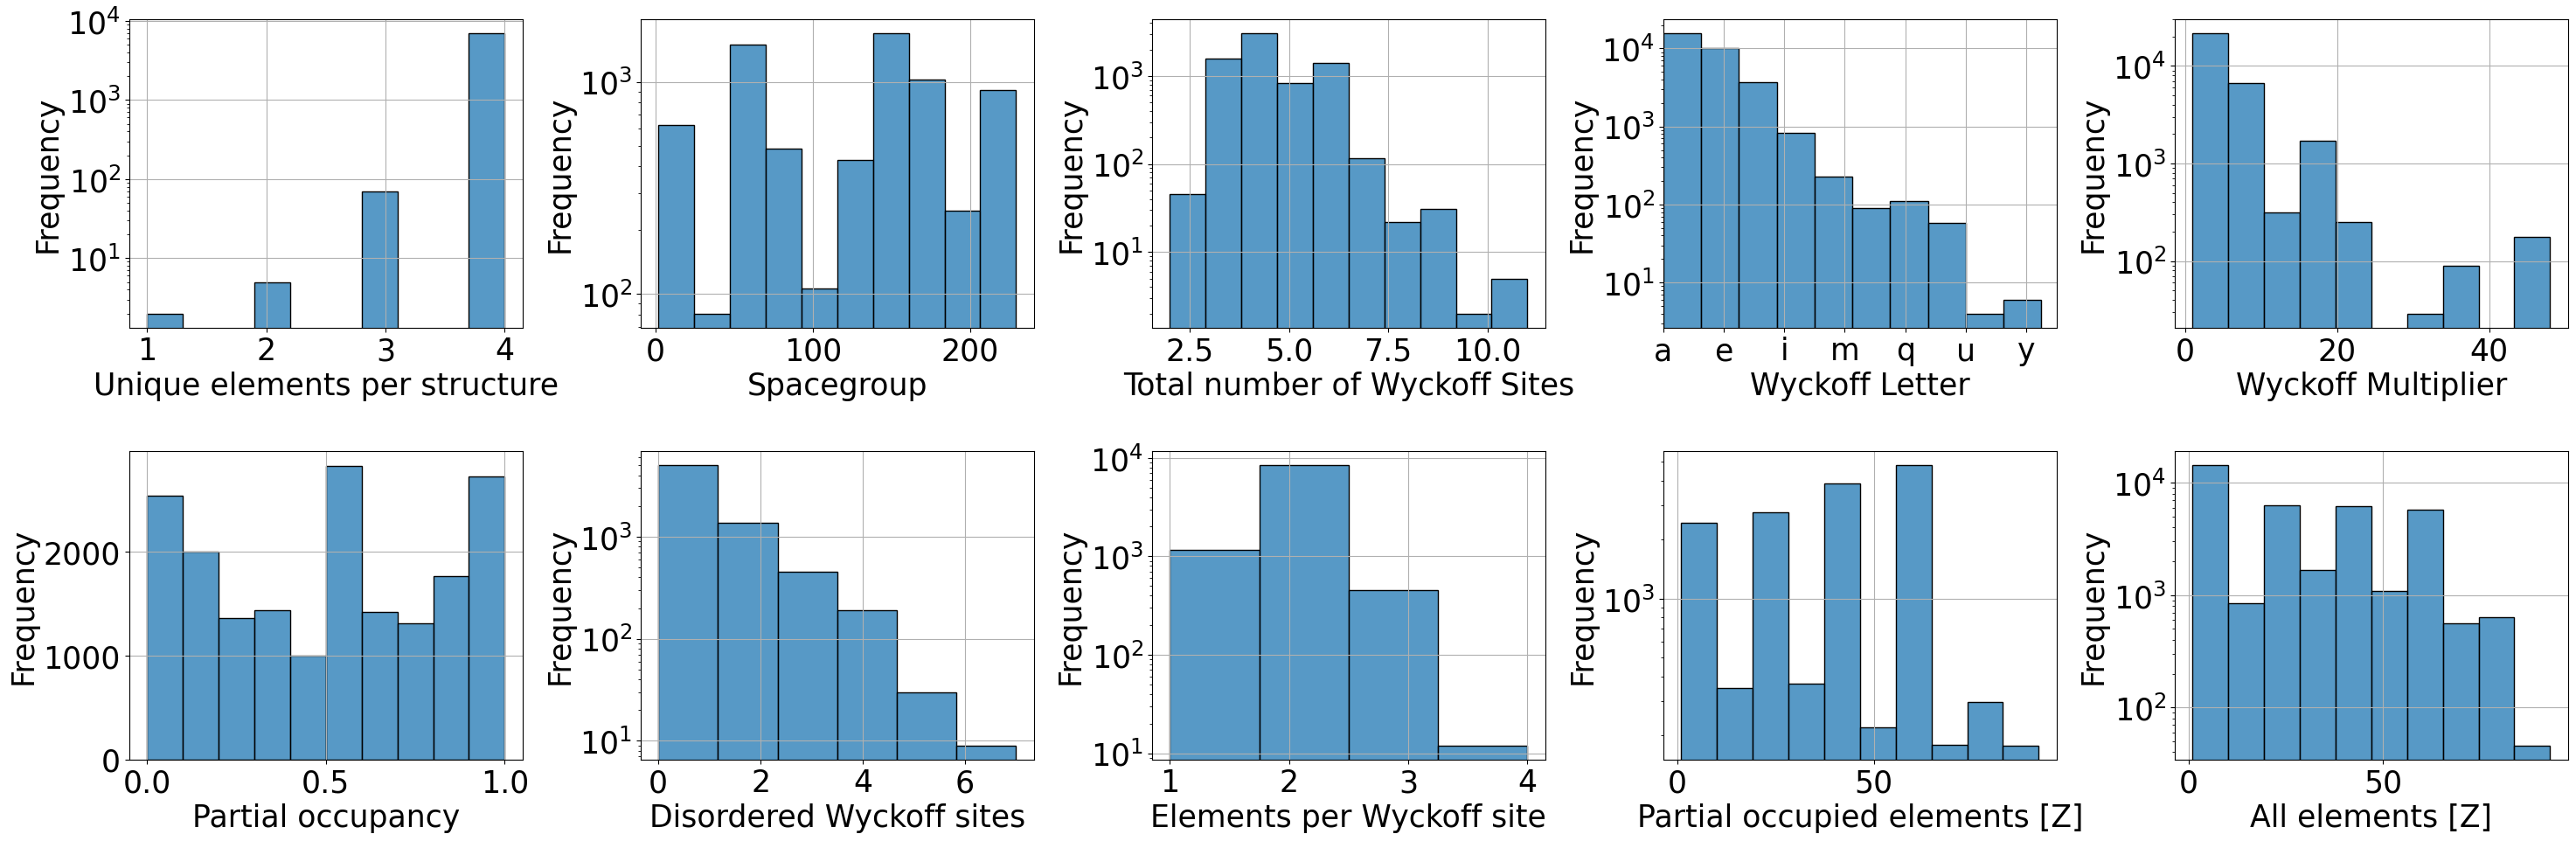

In [90]:
### Plot the representation
total_wyckoff_dict = crystal_rep.total_wyckoff_dict
total_lattice = crystal_rep.total_crystal_features
total_atomistic = crystal_rep.total_atomistic_features
total_element_disorder = crystal_rep.total_element_disorder
total_site_disorder = crystal_rep.total_site_disorder
print('Total Structures:',len(total_wyckoff_dict))
print('Total Lattice Features:',total_lattice.shape)
print('Total Atomistic Features:',total_atomistic.shape)

space_group = np.array(crystal_rep.spacegroup_list)
total_wyckoff_sites = []
wyckoff_sites = []
wyckoff_multipliers = []
disorder = []
disorder_species = []
total_elem_disorder = []
total_disorder = []
all_species = []
total_diff_elem = []

# Loop through all the structures
for idx, wyckoff_dict in enumerate(total_wyckoff_dict):

    # append the total number of wyckoff sites
    total_wyckoff_sites.append(len(wyckoff_dict))

    site_disorder =False

    # Loop through all the wyckoff sites
    disorder_sites = 0
    local_species = []
    for key in wyckoff_dict:
        # Get the wyckoff letter and multiplier
        wyckoff =wyckoff_dict[key]['wyckoff']
        site_num = ord(re.sub('[^a-zA-Z]+', '',wyckoff )) - 97 
        wyckoff_sites.append(site_num)
        wyckoff_multipliers.append(int(wyckoff[:-1]))

        # Get the species and atomic number
        species = wyckoff_dict[key]['species']
        Z_species = wyckoff_dict[key]['Z_species']
        all_species.append(Z_species)
        local_species.append(Z_species)
        # Check if there is site disorder
        if len(species) > 1:
            # Append the site disorder
            disorder_sites +=1
            site_disorder = True
            total_elem_disorder.append(len(species))

            # Loop through all the species
            for elem,occ in species.items():
                disorder.append(occ)
            disorder_species.append(Z_species)
    
    if not site_disorder:
        total_elem_disorder.append(1)
    
    total_diff_elem.append(len(np.unique(np.concatenate(local_species))))
    total_disorder.append(disorder_sites)

# Plot the distribution of the wyckoff sites
fig, ax = plt.subplots(2,5,figsize=(36,11),gridspec_kw={'wspace':0.3,'hspace':0.4})
font_size = 25
Nbins = len(np.unique(total_wyckoff_sites))

sns.histplot(total_diff_elem,bins=Nbins,ax=ax[0,0])
#ax[0,3].hist(wyckoff_multipliers,bins=Nbins)
ax[0,0].set_xlabel('Unique elements per structure',fontsize=font_size)
ax[0,0].set_ylabel('Frequency',fontsize=font_size)
ax[0,0].tick_params(axis='both', which='major', labelsize=font_size)
ax[0,0].tick_params(axis='both', which='minor', labelsize=font_size)
ax[0,0].grid(True)
ax[0,0].set_yscale('log')

sns.histplot(space_group,bins=Nbins,ax=ax[0,1])
#ax[0,1].hist(space_group,bins=Nbins)
ax[0,1].set_xlabel('Spacegroup',fontsize=font_size)
ax[0,1].set_ylabel('Frequency',fontsize=font_size)
ax[0,1].tick_params(axis='both', which='major', labelsize=font_size)
ax[0,1].tick_params(axis='both', which='minor', labelsize=font_size)
ax[0,1].grid(True)
ax[0,1].set_yscale('log')

sns.histplot(total_wyckoff_sites,bins=Nbins,ax=ax[0,2])
#ax[0,0].hist(total_wyckoff_sites,bins=Nbins)
ax[0,2].set_xlabel('Total number of Wyckoff Sites',fontsize=font_size)
ax[0,2].set_ylabel('Frequency',fontsize=font_size)
ax[0,2].tick_params(axis='both', which='major', labelsize=font_size)
ax[0,2].tick_params(axis='both', which='minor', labelsize=font_size)
ax[0,2].grid(True)
ax[0,2].set_yscale('log')

sns.histplot(wyckoff_sites,bins=Nbins,ax=ax[0,3])
#ax[0,2].hist(wyckoff_sites,bins=Nbins)
ax[0,3].set_xlabel('Wyckoff Letter',fontsize=font_size)
ax[0,3].set_ylabel('Frequency',fontsize=font_size)
ax[0,3].tick_params(axis='both', which='major', labelsize=font_size)
ax[0,3].tick_params(axis='both', which='minor', labelsize=font_size)
ax[0,3].grid(True)
ax[0,3].set_xlim(0,26)
ax[0,3].set_xticks(np.arange(0,26,4))
print(ax[0,3].get_xticks())
# map the wyckoff letter to the actual letter
wyckoff_label = {i:chr(i+97) for i in range(26)}
ax[0,3].set_xticklabels([wyckoff_label[i] for i in ax[0,3].get_xticks()])
ax[0,3].set_yscale('log')

sns.histplot(wyckoff_multipliers,bins=Nbins,ax=ax[0,4])
#ax[0,3].hist(wyckoff_multipliers,bins=Nbins)
ax[0,4].set_xlabel('Wyckoff Multiplier',fontsize=font_size)
ax[0,4].set_ylabel('Frequency',fontsize=font_size)
ax[0,4].tick_params(axis='both', which='major', labelsize=font_size)
ax[0,4].tick_params(axis='both', which='minor', labelsize=font_size)
ax[0,4].grid(True)
ax[0,4].set_yscale('log')

sns.histplot(disorder,bins=Nbins,ax=ax[1,0])
#ax[1,0].hist(disorder,bins=Nbins)
ax[1,0].set_xlabel('Partial occupation',fontsize=font_size)
ax[1,0].set_ylabel('Frequency',fontsize=font_size)
ax[1,0].tick_params(axis='both', which='major', labelsize=font_size)
ax[1,0].tick_params(axis='both', which='minor', labelsize=font_size)
ax[1,0].grid(True)
#ax[1,0].set_yscale('log')

sns.histplot(total_disorder,bins=total_site_disorder,ax=ax[1,1])
ax[1,1].set_xlabel('Disordered Wyckoff sites',fontsize=font_size)
ax[1,1].set_ylabel('Frequency',fontsize=font_size)
ax[1,1].tick_params(axis='both', which='major', labelsize=font_size)
ax[1,1].tick_params(axis='both', which='minor', labelsize=font_size)
ax[1,1].grid(True)
ax[1,1].set_yscale('log')

sns.histplot(total_elem_disorder,bins=total_element_disorder+1,ax=ax[1,2])
ax[1,2].set_xlabel('Elements per Wyckoff site',fontsize=font_size)
ax[1,2].set_ylabel('Frequency',fontsize=font_size)
ax[1,2].tick_params(axis='both', which='major', labelsize=font_size)
ax[1,2].tick_params(axis='both', which='minor', labelsize=font_size)
ax[1,2].grid(True)
ax[1,2].set_yscale('log')

disorder_species = np.concatenate((disorder_species))
sns.histplot(disorder_species,bins=Nbins,ax=ax[1,3])
#ax[1,2].hist(disorder_species,bins=Nbins)
ax[1,3].set_xlabel('Partial occupied elements [Z]',fontsize=font_size)
ax[1,3].set_ylabel('Frequency',fontsize=font_size)
ax[1,3].tick_params(axis='both', which='major', labelsize=font_size)
ax[1,3].tick_params(axis='both', which='minor', labelsize=font_size)
ax[1,3].grid(True)
ax[1,3].set_yscale('log')

all_species = np.concatenate((all_species))
sns.histplot(all_species,bins=Nbins,ax=ax[1,4])
#ax[1,3].hist(all_species,bins=Nbins)
ax[1,4].set_xlabel('All elements [Z]',fontsize=font_size)
ax[1,4].set_ylabel('Frequency',fontsize=font_size)
ax[1,4].tick_params(axis='both', which='major', labelsize=font_size)
ax[1,4].tick_params(axis='both', which='minor', labelsize=font_size)
ax[1,4].grid(True)
ax[1,4].set_yscale('log')



In [14]:
np.concatenate(local_species)

array([38, 38, 26, 28,  8,  8,  8])

### Representation learning

In [3]:
print('Total crystal features:',crystal_rep.total_crystal_features.shape)
print('Total number of structures:',print_value.shape[0])
print('Total atomic representation:',print_value.shape)
print('One hot:',print_value[:,:,:101].shape)
print('Frac. coordiante:',print_value[:,:,-30:-27].shape)
print('Wyckoff multiplier:',print_value[:,:,-27:].shape)

NameError: name 'crystal_rep' is not defined

### ICSD

In [3]:
import pickle
# Read the wyckoff dictionary
with open('wyckoff_dict_icsd.pkl','rb') as f:
    wyckoff_dict = pickle.load(f)

# sort the wyckoff dictionary
drop_idx = []
wyckoff_dict_list = []
max_wyckoff_sites = 9
element_occ = 0.0 # 0.01
for i, wyckoff in enumerate(wyckoff_dict):
    # Sort for maximum wyckoff sites
    if len(wyckoff) > max_wyckoff_sites:
        drop_idx.append(i)
        continue
    else:
        # Sort for element occupancy
        for key in wyckoff:
            if any(np.array(list(wyckoff[key]['species'].values())) < element_occ):
                drop_idx.append(i)
                break
        else:
            wyckoff_dict_list.append(wyckoff)

print('Drop:',len(drop_idx))
if len(drop_idx) == 0:
    print('No drop points')
    print_value = np.load('atomic_features_icsd.npy')
    crystal_feat = np.load('crystal_features_icsd.npy')
    space_group = np.load('spacegroup_icsd.npy')
    
else:
    # Load the data
    drop_idx = np.array(drop_idx)
    print_value = np.delete(np.load('atomic_features_icsd.npy'),drop_idx,axis=0)
    crystal_feat = np.delete(np.load('crystal_features_icsd.npy'),drop_idx,axis=0)
    space_group = np.delete(np.load('spacegroup_icsd.npy'),drop_idx)

#np.save('atomic_features_icsd_sorted_occ0.05.npy',print_value)
#np.save('crystal_features_icsd_sorted_occ0.05.npy',crystal_feat)
#np.save('spacegroup_icsd_sorted_occ0.05.npy',space_group)

Drop: 0
No drop points


Total Structures: 138692
[ 0  4  8 12 16 20 24]


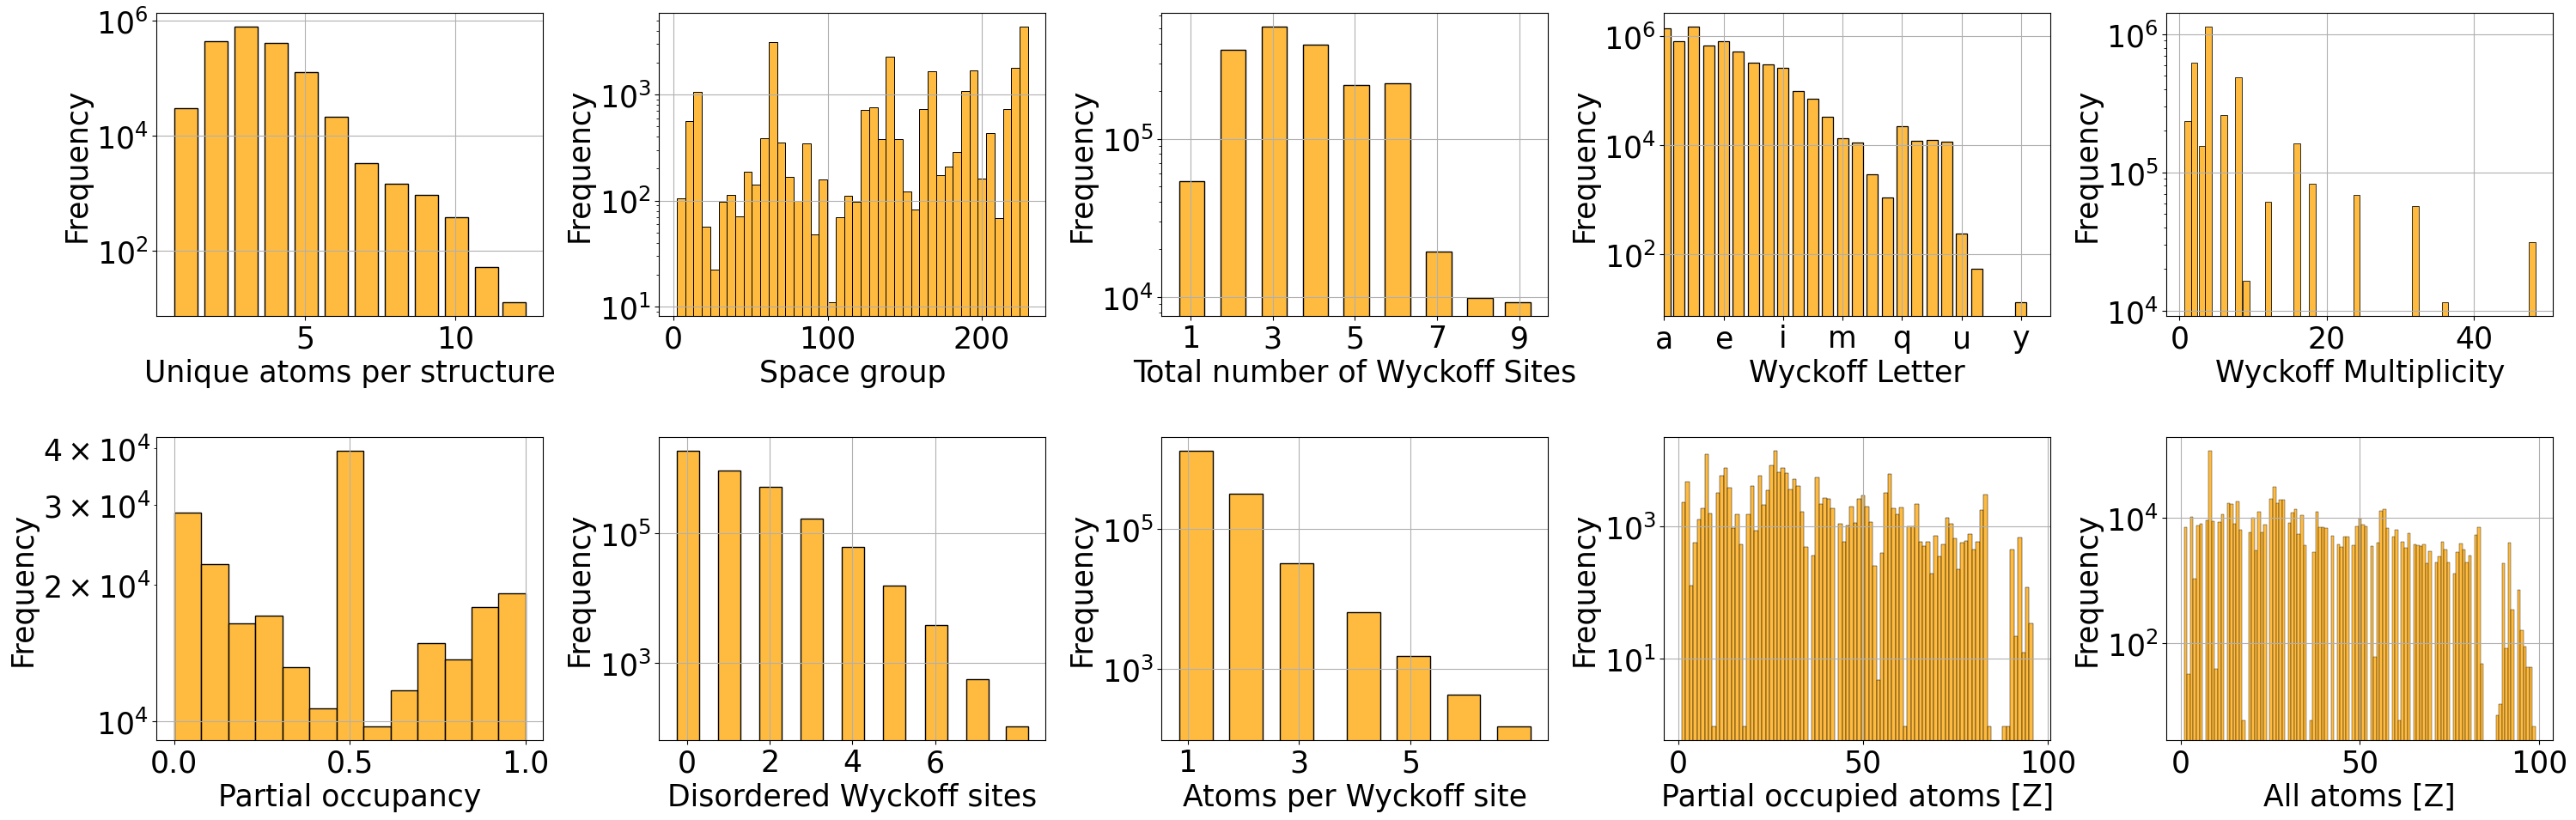

In [4]:

total_wyckoff_dict = wyckoff_dict_list

print('Total Structures:',len(total_wyckoff_dict))
sns.color_palette("Set2")

total_wyckoff_sites = []
wyckoff_sites = []
wyckoff_multipliers = []
disorder = []
disorder_species = []
total_elem_disorder = []
total_disorder = []
all_species = []
total_diff_elem = []

# Loop through all the structures
for idx, wyckoff_dict in enumerate(total_wyckoff_dict):

    # append the total number of wyckoff sites
    total_wyckoff_sites.append(len(wyckoff_dict))

    site_disorder =False

    # Loop through all the wyckoff sites
    disorder_sites = 0
    local_species = []
    for key in wyckoff_dict:
        # Get the wyckoff letter and multiplier
        wyckoff =wyckoff_dict[key]['wyckoff']
        site_num = ord(re.sub('[^a-zA-Z]+', '',wyckoff )) - 97 
        wyckoff_sites.append(site_num)
        wyckoff_multipliers.append(int(wyckoff[:-1]))

        # Get the species and atomic number
        species = wyckoff_dict[key]['species']
        Z_species = wyckoff_dict[key]['Z_species']
        all_species.append(Z_species)
        local_species.append(Z_species)
        # Check if there is site disorder
        if len(species) > 1:
            # Append the site disorder
            disorder_sites +=1
            site_disorder = True
            total_elem_disorder.append(len(species))

            # Loop through all the species
            for elem,occ in species.items():
                disorder.append(occ)
            disorder_species.append(Z_species)
        else: # ordered
            total_elem_disorder.append(1)

    #if not site_disorder:
    #    total_elem_disorder.append(1)
    
    total_diff_elem.append(len(np.unique(np.concatenate(local_species))))
    total_disorder.append(disorder_sites)
    #if disorder_sites>6:
    #    print('Disorder:',idx)

# Plot the distribution of the wyckoff sites
fig, ax = plt.subplots(2,5,figsize=(36,11),gridspec_kw={'wspace':0.3,'hspace':0.4})
font_size = 25
Nbins = 13
stat='frequency' #count
color = 'orange'
edgecolor = 'black'

sns.histplot(total_diff_elem,ax=ax[0,0],stat=stat,shrink = 10,color=color, edgecolor=edgecolor)
ax[0,0].set_xlabel('Unique atoms per structure',fontsize=font_size)
ax[0,0].set_ylabel('Frequency',fontsize=font_size)
ax[0,0].tick_params(axis='both', which='major', labelsize=font_size)
ax[0,0].tick_params(axis='both', which='minor', labelsize=font_size)
ax[0,0].grid(True)
ax[0,0].set_yscale('log')

sns.histplot(space_group,ax=ax[0,1],stat=stat,shrink=1,color=color, edgecolor=edgecolor)
#ax[0,1].hist(space_group,bins=Nbins)
ax[0,1].set_xlabel('Space group',fontsize=font_size)
ax[0,1].set_ylabel('Frequency',fontsize=font_size)
ax[0,1].tick_params(axis='both', which='major', labelsize=font_size)
ax[0,1].tick_params(axis='both', which='minor', labelsize=font_size)
ax[0,1].grid(True)
#ax[0,1].set_ylim(1e3,1e5)
ax[0,1].set_yscale('log')

sns.histplot(total_wyckoff_sites,ax=ax[0,2],stat=stat,shrink=8,color=color, edgecolor=edgecolor)
#ax[0,0].hist(total_wyckoff_sites,bins=Nbins)
ax[0,2].set_xlabel('Total number of Wyckoff Sites',fontsize=font_size)
ax[0,2].set_ylabel('Frequency',fontsize=font_size)
ax[0,2].tick_params(axis='both', which='major', labelsize=font_size)
ax[0,2].tick_params(axis='both', which='minor', labelsize=font_size)
ax[0,2].set_xticks(np.arange(1,10,2))
ax[0,2].grid(True)
ax[0,2].set_yscale('log')

sns.histplot(wyckoff_sites,ax=ax[0,3],stat=stat,shrink=10,color=color, edgecolor=edgecolor)
#ax[0,2].hist(wyckoff_sites,bins=Nbins)
ax[0,3].set_xlabel('Wyckoff Letter',fontsize=font_size)
ax[0,3].set_ylabel('Frequency',fontsize=font_size)
ax[0,3].tick_params(axis='both', which='major', labelsize=font_size)
ax[0,3].tick_params(axis='both', which='minor', labelsize=font_size)
ax[0,3].grid(True)
ax[0,3].set_xlim(0,26)
ax[0,3].set_xticks(np.arange(0,26,4))
print(ax[0,3].get_xticks())
# map the wyckoff letter to the actual letter
wyckoff_label = {i:chr(i+97) for i in range(26)}
ax[0,3].set_xticklabels([wyckoff_label[i] for i in ax[0,3].get_xticks()])
ax[0,3].set_yscale('log')

sns.histplot(wyckoff_multipliers,ax=ax[0,4],stat=stat,shrink=6,color=color, edgecolor=edgecolor)
#ax[0,3].hist(wyckoff_multipliers,bins=Nbins)
ax[0,4].set_xlabel('Wyckoff Multiplicity',fontsize=font_size)
ax[0,4].set_ylabel('Frequency',fontsize=font_size)
ax[0,4].tick_params(axis='both', which='major', labelsize=font_size)
ax[0,4].tick_params(axis='both', which='minor', labelsize=font_size)
ax[0,4].grid(True)
ax[0,4].set_yscale('log')
ax[0,4].set_yscale('log')

sns.histplot(disorder,bins=Nbins,ax=ax[1,0],color=color, edgecolor=edgecolor)
#ax[1,0].hist(disorder,bins=Nbins)
ax[1,0].set_xlabel('Partial occupancy',fontsize=font_size)
ax[1,0].set_ylabel('Frequency',fontsize=font_size)
ax[1,0].tick_params(axis='both', which='major', labelsize=font_size)
ax[1,0].tick_params(axis='both', which='minor', labelsize=font_size)
ax[1,0].grid(True)
ax[1,0].set_yscale('log')

sns.histplot(total_disorder,ax=ax[1,1],stat=stat,shrink=14,color=color, edgecolor=edgecolor)
ax[1,1].set_xlabel('Disordered Wyckoff sites',fontsize=font_size)
ax[1,1].set_ylabel('Frequency',fontsize=font_size)
ax[1,1].tick_params(axis='both', which='major', labelsize=font_size)
ax[1,1].tick_params(axis='both', which='minor', labelsize=font_size)
ax[1,1].grid(True)
ax[1,1].set_xticks(np.arange(0,7,2))
ax[1,1].set_yscale('log')

sns.histplot(total_elem_disorder,ax=ax[1,2],stat=stat,shrink=2,color=color, edgecolor=edgecolor)
ax[1,2].set_xlabel('Atoms per Wyckoff site',fontsize=font_size)
ax[1,2].set_ylabel('Frequency',fontsize=font_size)
ax[1,2].tick_params(axis='both', which='major', labelsize=font_size)
ax[1,2].tick_params(axis='both', which='minor', labelsize=font_size)
ax[1,2].grid(True)
ax[1,2].set_xticks(np.arange(1,7,2))
ax[1,2].set_yscale('log')

disorder_species = np.concatenate((disorder_species))
sns.histplot(disorder_species,ax=ax[1,3],stat=stat,shrink=1,color=color, edgecolor=edgecolor)
#ax[1,2].hist(disorder_species,bins=Nbins)
ax[1,3].set_xlabel('Partial occupied atoms [Z]',fontsize=font_size)
ax[1,3].set_ylabel('Frequency',fontsize=font_size)
ax[1,3].tick_params(axis='both', which='major', labelsize=font_size)
ax[1,3].tick_params(axis='both', which='minor', labelsize=font_size)
ax[1,3].grid(True)
ax[1,3].set_yscale('log')

all_species = np.concatenate((all_species))
sns.histplot(all_species,ax=ax[1,4],stat=stat,shrink=1,color=color, edgecolor=edgecolor)
#ax[1,3].hist(all_species,bins=Nbins)
ax[1,4].set_xlabel('All atoms [Z]',fontsize=font_size)
ax[1,4].set_ylabel('Frequency',fontsize=font_size)
ax[1,4].tick_params(axis='both', which='major', labelsize=font_size)
ax[1,4].tick_params(axis='both', which='minor', labelsize=font_size)
ax[1,4].grid(True)
ax[1,4].set_yscale('log')



In [5]:
print('Total crystal features:',crystal_feat.shape)
print('Total number of structures:',print_value.shape[0])
print('Total atomic representation:',print_value.shape)
print('One hot:',print_value[:,:,:101].shape, 'Max:',np.max(np.sum(print_value[:,:,:101],axis=2)),'Unique:',np.unique(np.sum(print_value[:,:,:101],axis=2)))
print('Frac. coordiante:',print_value[:,:,-30:-27].shape, 'Max:',np.max(print_value[:,:,-30:-27]))
print('Wyckoff multiplier:',print_value[:,:,101:-31].shape, 'Max:',np.max(print_value[:,:,101:-31]),'Unique:',np.unique(print_value[:,:,101:-31]))
print('Wyckoff Letter:',print_value[:,:,-27:].shape, 'Max:',np.max(print_value[:,:,-27:]),'Unique:',np.unique(print_value[:,:,-27:]))
print('Disordered:',print_value[:,:,-31].shape, 'Max:',np.max(print_value[:,:,-31]),'Unique:',np.unique(print_value[:,:,-31]))

Total crystal features: (138692, 236)
Total number of structures: 138692
Total atomic representation: (138692, 9, 183)
One hot: (138692, 9, 101) Max: 1.0000000000000002 Unique: [1. 1. 1. 1.]
Frac. coordiante: (138692, 9, 3) Max: 0.99999


Wyckoff multiplier: (138692, 9, 51) Max: 1.0 Unique: [0. 1.]
Wyckoff Letter: (138692, 9, 27) Max: 1.0 Unique: [0. 1.]
Disordered: (138692, 9) Max: 1.0 Unique: [0. 1.]


### PyTorch


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
import math
from tqdm import tqdm
test_size = 0.2
val_size = 0.1
batch_size = 32
lr = 0.0001
epochs = 10
log_step = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#X = crystal_rep.total_atomistic_features
#Y = crystal_rep.total_crystal_features
#np.save('X_2D_dis_site.npy',X)
#np.save('Y_2D_dis_site.npy',Y)

#X = np.load('X_2D_dis_site.npy')
#Y = np.load('Y_2D_dis_site.npy')

X = np.load('atomic_features_icsd.npy')
Y = np.load('crystal_features_icsd.npy')

#X = np.load('atomic_features_icsd_sorted_occ0.05.npy')
#Y = np.load('crystal_features_icsd_sorted_occ0.05.npy')

print('X:',X.shape)
print('Y:',Y.shape)

# Setup scaler for Y
scaler_Y = StandardScaler()
Y_scaled = Y.copy()
Y_scaled[:,:6] = scaler_Y.fit_transform(Y[:,:6])
# Set X and Y to torch tensors
Y = Y_scaled

x_train_val,x_test,y_train_val,y_test=train_test_split( X \
                                               ,Y,test_size=test_size,random_state=42)
x_train,x_val,y_train,y_val = train_test_split(x_train_val,y_train_val,test_size=val_size,random_state=42)
print('Train:',x_train.shape,y_train.shape)
print('Val:',x_val.shape,y_val.shape)
print('Test:',x_test.shape,y_test.shape)

# 2. Define a custom Dataset class
class CrystalDataset(Dataset):
    def __init__(self, X, Y):
        """
        Initialize the dataset.
        
        Args:
        X (numpy array): Atomic features with shape (N, feature_dim, wyckoff_dim).
        Y (numpy array): Crystal features with shape (N, crystal_dim).
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        """
        Return the size of the dataset.
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Retrieve an item at the specified index.
        
        Args:
        idx (int): Index of the item.
        
        Returns:
        Tuple[Tensor, Tensor]: Atomic and crystal features.
        """
        return self.X[idx], self.Y[idx]

# 3. Create Dataset and DataLoader for each split
train_dataset = CrystalDataset(x_train, y_train)
val_dataset = CrystalDataset(x_val, y_val)
#test_dataset = CrystalDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X: (138692, 9, 183)
Y: (138692, 236)
Train: (99857, 9, 183) (99857, 236)
Val: (11096, 9, 183) (11096, 236)
Test: (27739, 9, 183) (27739, 236)


In [4]:
#np.save('X_val.npy',x_val)
#np.save('Y_val.npy',y_val)
#np.save('X_test.npy',x_test)
#np.save('Y_test.npy',y_test)

train_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for i in range(1,10):
    train_size = train_range[i-1]
    print('Train size:',train_size)
    x_train_new,_,y_train_new,_ = train_test_split(x_train,y_train,test_size=train_size,random_state=42)
    print('Train:',x_train_new.shape,y_train_new.shape)
    #print('Val:',x_val.shape,y_val.shape)
    #np.save(f'X_train_{1-train_size:2f}.npy',x_train_new)
    #np.save(f'Y_train_{1-train_size:2f}.npy',y_train)
    #np.save('X_val_'+str(i)+'.npy',x_val)
    #np.save('Y_val_'+str(i)+'.npy',y_val)


Train size: 0.1
Train: (89871, 9, 183) (89871, 236)
Train size: 0.2
Train: (79885, 9, 183) (79885, 236)
Train size: 0.3
Train: (69899, 9, 183) (69899, 236)
Train size: 0.4
Train: (59914, 9, 183) (59914, 236)
Train size: 0.5
Train: (49928, 9, 183) (49928, 236)
Train size: 0.6
Train: (39942, 9, 183) (39942, 236)
Train size: 0.7
Train: (29957, 9, 183) (29957, 236)
Train size: 0.8
Train: (19971, 9, 183) (19971, 236)
Train size: 0.9
Train: (9985, 9, 183) (9985, 236)


In [7]:
# Example usage: Iterate through the train_loader
for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}")
    print(f"x_batch shape: {x_batch.shape}")  # Shape: (batch_size, 131, 24)
    print(f"y_batch shape: {y_batch.shape}")  # Shape: (batch_size, 236)
    break

Batch 1
x_batch shape: torch.Size([32, 9, 183])
y_batch shape: torch.Size([32, 236])


In [9]:
# Define the VAE model
class VAE(nn.Module):
    def __init__(self, feature_dim, wyckoff_dim, crystal_dim,space_group_dim=230,lattice_dim=6,
                  stride= [2,2,1],kernel=[3,3,4],latent_dim=256, max_filter=64,verbose=False):
        super(VAE, self).__init__()
        self.feature_dim = feature_dim
        self.wyckoff_dim = wyckoff_dim
        self.crystal_dim = crystal_dim
        self.space_group_dim = space_group_dim
        self.stride = stride
        self.kernel_size = kernel
        self.latent_dim = latent_dim
        self.max_filter = max_filter
        self.verbose = verbose
        self.map_size = int(feature_dim / stride[0] / stride[1] / stride[2])

        # Encoder: Atomic features
        self.encoder_conv1 = nn.Conv1d(wyckoff_dim, max_filter * 2 , kernel_size=self.kernel_size[0], stride=self.stride[0], padding=0)
        self.encoder_conv2 = nn.Conv1d(max_filter * 2, max_filter * 4, kernel_size=self.kernel_size[1], stride=self.stride[1], padding=0)
        self.encoder_conv3 = nn.Conv1d(max_filter * 4, max_filter * 8, kernel_size=self.kernel_size[2], stride=self.stride[2], padding=0)

        self.encoder_bn1 = nn.BatchNorm1d(max_filter * 2)
        self.encoder_bn2 = nn.BatchNorm1d(max_filter * 4)
        self.encoder_bn3 = nn.BatchNorm1d(max_filter * 8)
        self.encoder_fc = nn.Linear(max_filter * 8 * (self.map_size) , 1024) #### TODO: NEED TO CHANGE THIS TO BE DYNAMIC

        # Encoder: Crystal features
        self.crystal_fc1 = nn.Linear(crystal_dim, 256)
        self.crystal_fc2 = nn.Linear(256, 128)

        # Latent space
        self.z_mean = nn.Linear(1024 + 128, latent_dim)
        self.z_log_var = nn.Linear(1024 + 128, latent_dim)

        # Decoder: Crystal features
        self.decoder_crystal_fc = nn.Linear(latent_dim, crystal_dim)
        self.decoder_sg = nn.Linear(crystal_dim, space_group_dim)  # 230 space groups
        self.decoder_lattice = nn.Linear(crystal_dim, lattice_dim) # 6 lattice constants and angles

        # Decoder: Atomistic features
        self.last_encoder_layer = self.encoder_conv3.state_dict()['weight'].shape[0]

        self.decoder_fc = nn.Linear(latent_dim, self.last_encoder_layer * self.map_size)
        self.decoder_conv1 = nn.ConvTranspose1d(self.last_encoder_layer, max_filter * 4, kernel_size=self.kernel_size[2], stride=self.stride[2])
        self.decoder_conv2 = nn.ConvTranspose1d(max_filter *4 , max_filter * 2 , kernel_size=self.kernel_size[1], stride=self.stride[1],)
        self.decoder_conv3 = nn.ConvTranspose1d(max_filter * 2, wyckoff_dim, kernel_size=self.kernel_size[0], stride=self.stride[0],)
        self.decoder_bn1 = nn.BatchNorm1d(max_filter * 4)
        self.decoder_bn2 = nn.BatchNorm1d(max_filter * 2)
        self.decoder_bn3 = nn.BatchNorm1d(wyckoff_dim)

        self.element = nn.Linear(feature_dim,101)
        self.wycokff_letter = nn.Linear(feature_dim,27)
        self.wyckoff_multiplier = nn.Linear(feature_dim,51)
        self.frac_coords = nn.Linear(feature_dim,3)
        self.disordered_site = nn.Linear(feature_dim,1)

    def encode(self, x, x2):
        # Atomic feature encoding
        if self.verbose:
            print('X:',x.shape)
            print('X2:',x2.shape)
        #x = x.permute(0, 2, 1)
        #print(x.shape,x2.shape)
        en0 = F.relu(self.encoder_bn1(self.encoder_conv1(x)))
        if self.verbose: print('En0:',en0.shape)     
        en1 = F.relu(self.encoder_bn2(self.encoder_conv2(en0)))
        if self.verbose: print('En1:',en1.shape)
        en2 = F.relu(self.encoder_bn3(self.encoder_conv3(en1)))
        if self.verbose: print('En2:',en2.shape)
        en3 = en2.view(en2.size(0), -1)  # Flatten
        if self.verbose: print('En3:',en3.shape)

        # Get the map size
        self.map_size = en2.shape[-1]

        en4 = F.relu(self.encoder_fc(en3))
        if self.verbose: print('En4:',en4.shape)
        if self.verbose: print('---------------------------------')

        # Crystal feature encoding

        cry0 = F.relu(self.crystal_fc1(x2))
        if self.verbose: print('Cry0:',cry0.shape)
        cry1 = F.relu(self.crystal_fc2(cry0))
        if self.verbose: print('Cry1:',cry1.shape)
        if self.verbose: print('---------------------------------')

        # Combine atomic and crystal features
        latent = torch.cat((en4, cry1), dim=1)
        z_mean = self.z_mean(latent)
        z_log_var = self.z_log_var(latent)

        if self.verbose:
            print('Latent indput',latent.shape)
            print('Z mean',z_mean.shape,'Z_std',z_log_var.shape)
            print('---------------------------------')

        return z_mean, z_log_var

    def sampling(self, z_mean, z_log_var):
        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn_like(std)
        return z_mean + eps * std

    def decode(self, z):
        # Decode crystal features
        # Note for features with cross entropy loss, we do not apply softmax activation (ref: https://stackoverflow.com/questions/55675345/should-i-use-softmax-as-output-when-using-cross-entropy-loss-in-pytorch)
        if self.verbose:
            print('Z:',z.shape)

        crystal_features = F.relu(self.decoder_crystal_fc(z))
        decoded_sg = self.decoder_sg(crystal_features)
        decoded_lattice = self.decoder_lattice(crystal_features)


        if self.verbose:
            print('Crystal Features:',crystal_features.shape)
            print('Decoded SG:',decoded_sg.shape)
            print('Decoded Lattice:',decoded_lattice.shape)
            print('---------------------------------')

        # Decode atomistic features
        dec0 = self.decoder_fc(z)
        if self.verbose: print('Dec0:',dec0.shape)
        dec1 = dec0.view(dec0.size(0), self.last_encoder_layer ,self.map_size)
        if self.verbose: print('Dec1:',dec1.shape)
        dec2 = F.relu(self.decoder_bn1(self.decoder_conv1(dec1)))
        if self.verbose: print('Dec2:',dec2.shape)
        dec3 = F.relu(self.decoder_bn2(self.decoder_conv2(dec2)))
        if self.verbose: print('Dec3:',dec3.shape)

        dec4= F.relu(self.decoder_bn3(self.decoder_conv3(dec3)))
        if self.verbose: print('Dec4:',dec4.shape)

        # Separate the atomistic features. 
        decoded_element = F.softmax(self.element(dec4),dim=2)
        if self.verbose: print('Element:',decoded_element.shape)
        decoded_wyckoff_multiplier = self.wyckoff_multiplier(dec4)
        if self.verbose: print('Wyckoff Multiplier:',decoded_wyckoff_multiplier.shape)
        decoded_frac_coords = self.frac_coords(dec4)
        if self.verbose: print('Frac Coords:',decoded_frac_coords.shape)
        decoded_wyckoff_letter =self.wycokff_letter(dec4)
        if self.verbose: print('Wyckoff Letter:',decoded_wyckoff_letter.shape)
        decoded_disordered_site = self.disordered_site(dec4)
        if self.verbose: print('Disordered Site:',decoded_disordered_site.shape)
        
        
        return decoded_element,decoded_wyckoff_multiplier,decoded_frac_coords,decoded_wyckoff_letter, decoded_sg, decoded_lattice,decoded_disordered_site

    def forward(self, x, x2):
        # Encode
        z_mean, z_log_var = self.encode(x, x2)
        # Latent space sampling
        z = self.sampling(z_mean, z_log_var)
        # Decode
        decoded_element,decoded_wyckoff_multiplier,decoded_frac_coords,decoded_wyckoff_letter, decoded_sg, decoded_lattice,decoded_disordered_site = self.decode(z)
        outputs = {'decoded_element':decoded_element,
                    'decoded_wyckoff_multiplier':decoded_wyckoff_multiplier,
                    'decoded_frac_coords':decoded_frac_coords,
                    'decoded_wyckoff_letter':decoded_wyckoff_letter,
                    'decoded_disordered_site':decoded_disordered_site,
                   'decoded_sg':decoded_sg,
                   'decoded_lattice':decoded_lattice,
                   'z_mean':z_mean,
                   'z_log_var':z_log_var}
        return outputs

# Initialize the VAE
feature_dim = X.shape[2]
wyckoff_dim = X.shape[1]
crystal_dim = Y.shape[1]
kernel = [5,3,2]
stride = [2,3,2]
max_filter = 16
latent_dim = 256

vae = VAE(feature_dim, wyckoff_dim, crystal_dim,verbose=True,kernel=kernel,
          stride=stride,max_filter=max_filter,latent_dim=latent_dim)
# Test the forward pass
x_batch, y_batch = next(iter(train_loader))
out = vae(x_batch, y_batch)

# NOTE: Kernel add an extra dimension for the wyckoff sites 
#from torchsummary import summary1
#summary(vae, [(feature_dim,wyckoff_dim),(crystal_dim,)],)

X: torch.Size([32, 9, 183])
X2: torch.Size([32, 236])
En0: torch.Size([32, 32, 90])
En1: torch.Size([32, 64, 30])
En2: torch.Size([32, 128, 15])
En3: torch.Size([32, 1920])
En4: torch.Size([32, 1024])
---------------------------------
Cry0: torch.Size([32, 256])
Cry1: torch.Size([32, 128])
---------------------------------
Latent indput torch.Size([32, 1152])
Z mean torch.Size([32, 256]) Z_std torch.Size([32, 256])
---------------------------------
Z: torch.Size([32, 256])
Crystal Features: torch.Size([32, 236])
Decoded SG: torch.Size([32, 230])
Decoded Lattice: torch.Size([32, 6])
---------------------------------
Dec0: torch.Size([32, 1920])
Dec1: torch.Size([32, 128, 15])
Dec2: torch.Size([32, 64, 30])
Dec3: torch.Size([32, 32, 90])
Dec4: torch.Size([32, 9, 183])
Element: torch.Size([32, 9, 101])
Wyckoff Multiplier: torch.Size([32, 9, 51])
Frac Coords: torch.Size([32, 9, 3])
Wyckoff Letter: torch.Size([32, 9, 27])
Disordered Site: torch.Size([32, 9, 1])


In [10]:

# Defien loss function and test it
# Define the VAE loss function
def vae_loss_function(model_output, x, y, coeffs,verbose=False):
    """
    Compute the VAE loss.

    Args:
    reconstructed_x (Tensor): Reconstructed output from the decoder.
    x (Tensor): Original input.
    z_mean (Tensor): Mean of the latent variable.
    z_log_var (Tensor): Log variance of the latent variable.
    coeffs (dict): Coefficients for different loss components.

    Returns:
    Tensor: Total loss (scalar).
    """   
    # VAE loss consists of two components: 
    # 1. KL divergence loss. That is a measure of divergence between two distributions.
    # 2. Reconstruction loss for the atoms. That we will seperate into several lossed for each component we want to reconstruct
    # 3. Reconstruction loss for the crystal features
    # We want to minimize the reconstruction loss and the KL divergence loss.
    # Mean over the batch to make the training independent of the batch size.

    # Initialize the losses
    losses = {}

    # Get the model output
    z_mean = model_output['z_mean']
    z_log_var = model_output['z_log_var']
    decoded_sg = model_output['decoded_sg']
    decoded_lattice = model_output['decoded_lattice']

    # Get the decoded atomistic features
    decoded_element = model_output['decoded_element']
    decoded_wyckoff_multiplier = model_output['decoded_wyckoff_multiplier']
    decoded_frac_coords = model_output['decoded_frac_coords']
    decoded_wyckoff_letter = model_output['decoded_wyckoff_letter']
    decoded_disordered_site = model_output['decoded_disordered_site']

    if verbose:
        print('Original:',x.shape)
        print('Reconstructed:',decoded_element.shape,decoded_wyckoff_multiplier.shape,decoded_frac_coords.shape,decoded_wyckoff_letter.shape,decoded_disordered_site.shape)
        print('Z mean:',z_mean.shape)
        print('Z log var:',z_log_var.shape)
        print('Coeffs:',coeffs)
        print('---------------------------------')
    
    #### KL Divergence loss ####
    kl_loss_i = -0.5 *(1 + z_log_var - torch.square(z_mean) - torch.exp(z_log_var))
    kl_loss = torch.mean(  (1/z_mean.shape[1]) * torch.sum(kl_loss_i, dim=1) ) # sum over the latent dimensions and mean over the batch
    
    losses['kl'] = kl_loss
    print(kl_loss_i )
    if verbose:
        print('KL Loss i:',kl_loss_i.shape)
        print('KL Loss:',kl_loss.shape)

    #### Reconstruction loss atomistic features ####
    #if verbose:
    #    if decoded_element[0,0,:].sum() < 1 or decoded_element[0,0,:].sum() > 1:
    #        print('ERROR Element:',decoded_element[0,0,:].sum())
    
    # Loop over wyckoff sites
    element_loss_i = []
    wyckoff_site_loss_i = []
    wyckoff_multiplier_loss_i = []
    disordered_site_loss_i = []
    for i in range(decoded_element.shape[1]):
        # Reconstruction loss of the elemental features
        # Use KL div loss to predict the prob. distribution (ref: https://discuss.pytorch.org/t/loss-function-for-predicting-a-distribution/156681)
        element_loss_i.append(torch.mean(torch.square(decoded_element[:,i,:] - x[:,i,:101]),dim=1)) # MSE between the softmax distribution and the true distribution
        #element_loss_i.append(torch.sum(F.kl_div(F.log_softmax(decoded_element[:,i,:],dim=1), x[:,i,:101],reduction='none'),dim=1)) # KL divergence loss with sum reduction

        # Wyckoff sites reconstruction loss. Cross entropy loss
        wyckoff_site_loss_i.append(F.cross_entropy(decoded_wyckoff_letter[:,i,:], x[:,i,-27:],reduction='none'))
        #wyckoff_site_loss_i.append(torch.mean(torch.square(decoded_wyckoff_letter[:,i,:], x[:,i,-27:]),dim=1)) # MSE between the softmax distribution and the true distribution)
        #wyckoff_site_loss_i.append(torch.square(torch.argmax(decoded_wyckoff_letter[:,i,:],dim=1) - torch.argmax(x[:,i,-27:],dim=1) ) ) # MSE between the softmax distribution and the true distribution)


        # Wyckoof multiplier loss. Cross entropy loss
        wyckoff_multiplier_loss_i.append(F.cross_entropy(decoded_wyckoff_multiplier[:,i,:], x[:,i,101:-31],reduction='none',))
        
        # Disordered site loss. Cross entropy loss
        #disordered_site_loss_i.append(torch.square(decoded_disordered_site[:,i,0] - x[:,i,-31]) )
        #print(x[:,i,-31][:,None], decoded_disordered_site[:,i,:])
        disordered_site_loss_i.append(F.binary_cross_entropy_with_logits(decoded_disordered_site[:,i,0], x[:,i,-31],reduction='none')) # with logits is binary cross entropy and sigmoid activation  http://zhang-yang.medium.com/how-is-pytorchs-binary-cross-entropy-with-logits-function-related-to-sigmoid-and-d3bd8fb080e7
#        print(decoded_disordered_site[:,i,:].t().shape,x[:,i,-31][None,:].shape)
        #print(F.binary_cross_entropy_with_logits(decoded_disordered_site[:,i,0], x[:,i,-31],reduction='none'))

    # Element loss
    element_loss_i = torch.stack(element_loss_i)
    element_loss = torch.mean(torch.sum(element_loss_i,dim=0)) # sum over the wyckoff_sites and mean over the batch
    losses['element'] = element_loss
    if verbose:
        print('Element Loss i:',element_loss_i.shape)
        print('Element Loss:',element_loss.shape)

    # Wyckoff sites reconstruction loss. Cross entropy loss
    wyckoff_site_loss_i = torch.stack(wyckoff_site_loss_i)
    wyckoff_site_loss = torch.mean(torch.sum(wyckoff_site_loss_i,dim=0,dtype=torch.float64)) # sum over the wyckoff sites and mean over the batch
    losses['wyckoff_letter'] = wyckoff_site_loss
    if verbose:
        print('Wyckoff Loss i:',wyckoff_site_loss_i.shape)
        print('Wyckoff Loss:',wyckoff_site_loss.shape)

    # Wyckoof multiplier loss. Cross entropy loss
    wyckoff_multiplier_loss_i = torch.stack(wyckoff_multiplier_loss_i)
    wyckoff_multiplier_loss = torch.mean(torch.sum(wyckoff_multiplier_loss_i,dim=0)) # sum over the wyckoff sites and mean over the batch
    losses['wyckoff_multiplier'] = wyckoff_multiplier_loss
    if verbose:
        print('Wyckoff Multiplier Loss i:',wyckoff_multiplier_loss_i.shape)
        print('Wyckoff Multiplier Loss:',wyckoff_multiplier_loss.shape)

    # Disordered site loss. Cross entropy loss
    disordered_site_loss_i = torch.stack(disordered_site_loss_i)
    disordered_site_loss = torch.mean(torch.sum(disordered_site_loss_i,dim=0)) # sum over the wyckoff sites and mean over the batch
    losses['disordered_site'] = disordered_site_loss
    if verbose:
        print('Disordered Site Loss i:',disordered_site_loss_i.shape)
        print('Disordered Site Loss:',disordered_site_loss.shape)
    
    # Fractional coordinates reconstruction loss. Mean squared error loss
    frac_coords_loss_i = torch.mean(torch.square(decoded_frac_coords - x[:,:,-30:-27]),dim=2) # mse over the wyckoff sites 
    frac_coords_loss_j = torch.sum(frac_coords_loss_i,dim=1) # sum over the fractional coordinates
    frac_coords_loss = torch.mean(frac_coords_loss_j) # mean over the batch
    losses['frac_coords'] = frac_coords_loss
    if verbose:
        print('Frac Coords Loss i:',frac_coords_loss_i.shape)
        print('Frac Coords Loss:',frac_coords_loss.shape)

    #### Reconstruction loss crystal features ####
    # Space group loss. Cross entropy loss
    space_group_loss_i = F.cross_entropy(decoded_sg, y[:,6:],reduce=False)
    space_group_loss = torch.mean(space_group_loss_i) # mean over the batch
    losses['space_group'] = space_group_loss
    if verbose:
        print('Space Group Loss i:',space_group_loss_i.shape)
        print('Space Group Loss:',space_group_loss.shape)

    # Lattice loss. Mean squared error loss
    lattice_loss_i = F.mse_loss(decoded_lattice, y[:,:6],reduce=False)
    lattice_loss = torch.mean(torch.sum(lattice_loss_i,dim=1)) # sum over the lattice constants and mean over the batch
    losses['lattice'] = lattice_loss
    if verbose:
        print('Lattice Loss i:',lattice_loss_i.shape)
        print('Lattice Loss:',lattice_loss.shape)

    # Weighted sum of losses
    for key in losses:
        losses[key] *= coeffs[key]

    # Total loss
    total_loss = torch.sum(torch.stack(list(losses.values()))) # Take all the losses and make them to a list of torch objects then stack them to make them a tensor and sum them
    losses['total'] = total_loss
    if verbose:
        print('Total Loss:',total_loss.shape)
        print('---------------------------------')

    return losses
coeffs = {'kl': 0.1,
          'element':200.0,
          'wyckoff_letter': 1.0,
        'wyckoff_multiplier': 1.0,
          'frac_coords': 1.0,
          'space_group':10.0,
          'lattice':3.0,
          'disordered_site':1.0}
# Forward pass
vae = VAE(feature_dim, wyckoff_dim, crystal_dim,verbose=False,kernel=kernel,stride=stride)
out = vae(x_batch, y_batch)

# Compute loss
loss = vae_loss_function(out, x_batch, y_batch, coeffs,verbose=True);
for key in loss:
    print(f"{key}: {loss[key]}")

Original: torch.Size([32, 9, 183])
Reconstructed: torch.Size([32, 9, 101]) torch.Size([32, 9, 51]) torch.Size([32, 9, 3]) torch.Size([32, 9, 27]) torch.Size([32, 9, 1])
Z mean: torch.Size([32, 256])
Z log var: torch.Size([32, 256])
Coeffs: {'kl': 0.1, 'element': 200.0, 'wyckoff_letter': 1.0, 'wyckoff_multiplier': 1.0, 'frac_coords': 1.0, 'space_group': 10.0, 'lattice': 3.0, 'disordered_site': 1.0}
---------------------------------
tensor([[0.0504, 0.0360, 0.0204,  ..., 0.0762, 0.0137, 0.0835],
        [0.0210, 0.0359, 0.0170,  ..., 0.0516, 0.0117, 0.0915],
        [0.0456, 0.0228, 0.0322,  ..., 0.0491, 0.0205, 0.0634],
        ...,
        [0.0220, 0.0280, 0.0418,  ..., 0.0323, 0.0031, 0.0324],
        [0.0427, 0.0280, 0.0219,  ..., 0.0248, 0.0131, 0.0564],
        [0.0369, 0.0664, 0.0651,  ..., 0.1129, 0.0243, 0.1042]],
       grad_fn=<MulBackward0>)
KL Loss i: torch.Size([32, 256])
KL Loss: torch.Size([])
Element Loss i: torch.Size([9, 32])
Element Loss: torch.Size([])
Wyckoff Loss i

In [14]:
out.keys()

dict_keys(['decoded_element', 'decoded_wyckoff_multiplier', 'decoded_frac_coords', 'decoded_wyckoff_letter', 'decoded_sg', 'decoded_lattice', 'z_mean', 'z_log_var'])

In [31]:
# Training loop
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#log_step = 1
#epochs = 50
#lr = 0.001
# Initialize the VAE
feature_dim = X.shape[2]
wyckoff_dim = X.shape[1]

crystal_dim = Y.shape[1]
vae = VAE(feature_dim, wyckoff_dim, crystal_dim,verbose=False,kernel=kernel,stride=stride)
vae.to(device)

optimizer = Adam(vae.parameters(), lr=lr)

# Initialize the train and validation loss
train_loss_dict = {}
train_loss_dict['total'] = []
train_loss_dict['epoch'] = []

val_loss_dict = {}
val_loss_dict['total'] = []
val_loss_dict['epoch'] = []

best_val_loss = np.inf

# Training loop
for epoch in tqdm(range(epochs)):
    vae.train()
    # Initialize the train loss
    train_loss = 0.0
    train_running_loss = {}

    # Loop through the train loader
    for x_batch, y_batch in train_loader:  # Use both datasets if required
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        # Forward pass
        out = vae(x_batch, y_batch)
        
        # Compute loss
        loss = vae_loss_function(out, x_batch, y_batch, coeffs)
        # Backward pass
        loss['total'].backward()
        optimizer.step()

        # Log batch results
        train_loss += loss['total'].item()
        # Log running loss for each component of the loss
        if len(train_running_loss) == 0:
            train_running_loss = loss
        else:
            for key in loss:
                train_running_loss[key] += loss[key]

    print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss / len(train_loader)}")
    
    # Save the train loss for each component of the loss as a mean over the batches
    for key in train_running_loss:
        if key not in train_loss_dict:
            train_loss_dict[key] = [train_running_loss[key].item() / len(train_loader)]
        else:
            train_loss_dict[key].append(train_running_loss[key].item() / len(train_loader))
    train_loss_dict['epoch'].append(epoch)
    
    # Validate and save model for each log step
    if (epoch + 1) % log_step == 0:
        vae.eval()
        val_loss = 0.0
        val_running_loss = {}
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                # Forward pass
                out_val = vae(x_val, y_val)
                
                # Compute loss
                loss_val = vae_loss_function(out_val, x_val, y_val,coeffs)

                # Log batch results for validation 
                if len(val_running_loss) == 0:
                    val_running_loss = loss_val
                else:
                    for key in loss_val:
                        val_running_loss[key] += loss_val[key]
        # Log epoch results
        print('---------------------------------')
        print(f"Validation Loss:")
        
        for key in val_running_loss:
            # Print all losses
            print(f"{key}: {val_running_loss[key].item()/len(val_loader)}")
            # Save the validation loss
            if key not in val_loss_dict:
                val_loss_dict[key] = [val_running_loss[key].item()/len(val_loader)]
            else:
                val_loss_dict[key].append(val_running_loss[key].item()/len(val_loader))
        val_loss_dict['epoch'].append(epoch)


## Plot all the losses as a function of the epoch
fig, ax = plt.subplots(1,2,figsize=(20,10))
font_size = 20
Nbins = 20

for key in train_loss_dict:
    if key == 'epoch':
        continue
    ax[0].plot(train_loss_dict[key],label=key)
    val_epoch  = np.arange(0,len(val_loss_dict[key])*log_step,log_step)
    ax[1].plot(val_epoch, val_loss_dict[key],label=key)

ax[0].set_xlabel('Epoch',fontsize=font_size)
ax[0].set_ylabel('Loss',fontsize=font_size)
ax[0].set_title('Train Loss',fontsize=font_size)
ax[0].tick_params(axis='both', which='major', labelsize=font_size)
ax[0].tick_params(axis='both', which='minor', labelsize=font_size)
ax[0].grid(True)
ax[0].legend(fontsize=font_size,ncol=2)

ax[1].set_xlabel('Epoch',fontsize=font_size)
ax[1].set_ylabel('Loss',fontsize=font_size)
ax[1].set_title('Validation Loss',fontsize=font_size)
ax[1].tick_params(axis='both', which='major', labelsize=font_size)
ax[1].tick_params(axis='both', which='minor', labelsize=font_size)
ax[1].grid(True)
#ax[1].legend(fontsize=font_size)


  0%|          | 0/10 [00:00<?, ?it/s]

tensor([[0.0449, 0.0029, 0.0021,  ..., 0.0009, 0.0098, 0.0203],
        [0.0057, 0.0570, 0.0058,  ..., 0.0013, 0.0098, 0.0112],
        [0.0134, 0.0387, 0.0002,  ..., 0.0100, 0.0009, 0.0062],
        ...,
        [0.0562, 0.0362, 0.0050,  ..., 0.0027, 0.0037, 0.0037],
        [0.0321, 0.0086, 0.0088,  ..., 0.0200, 0.0001, 0.0018],
        [0.0322, 0.0509, 0.0373,  ..., 0.0061, 0.0139, 0.0069]],
       grad_fn=<MulBackward0>)


  0%|          | 0/10 [00:00<?, ?it/s]


KeyboardInterrupt: 

X: torch.Size([27739, 9, 183])
Y: torch.Size([27739, 236])
Coeff: {'kl': 1.0, 'element': 2000.0, 'wyckoff_letter': 1.0, 'wyckoff_multiplier': 1.0, 'frac_coords': 1.0, 'space_group': 10.0, 'lattice': 3.0, 'disordered_site': 0.1}
Train / Val loss:
Epoch: 2393
---------------------------------
total
Train: 0.6922434181012074
Val: 1.2979786264177038
kl
Train: 0.5349014741651986
Val: 0.5358173326514233
element
Train: 0.09592925028339706
Val: 0.3319878413759429
wyckoff_letter
Train: 0.007135370767981811
Val: 0.07730948714966833
wyckoff_multiplier
Train: 0.00516677590076317
Val: 0.05674614303413479
disordered_site
Train: 0.0007451715414375926
Val: 0.0013288070244350653
frac_coords
Train: 0.03146223255184352
Val: 0.032143998420101474
space_group
Train: 0.0030511749775878594
Val: 0.24394142764738236
lattice
Train: 0.013852252019360462
Val: 0.01870362923063081
---------------------------------
tensor([[5.4773, 1.8040, 0.0200,  ..., 4.4938, 2.0046, 0.8144],
        [2.8334, 0.6663, 0.0584,  ..., 

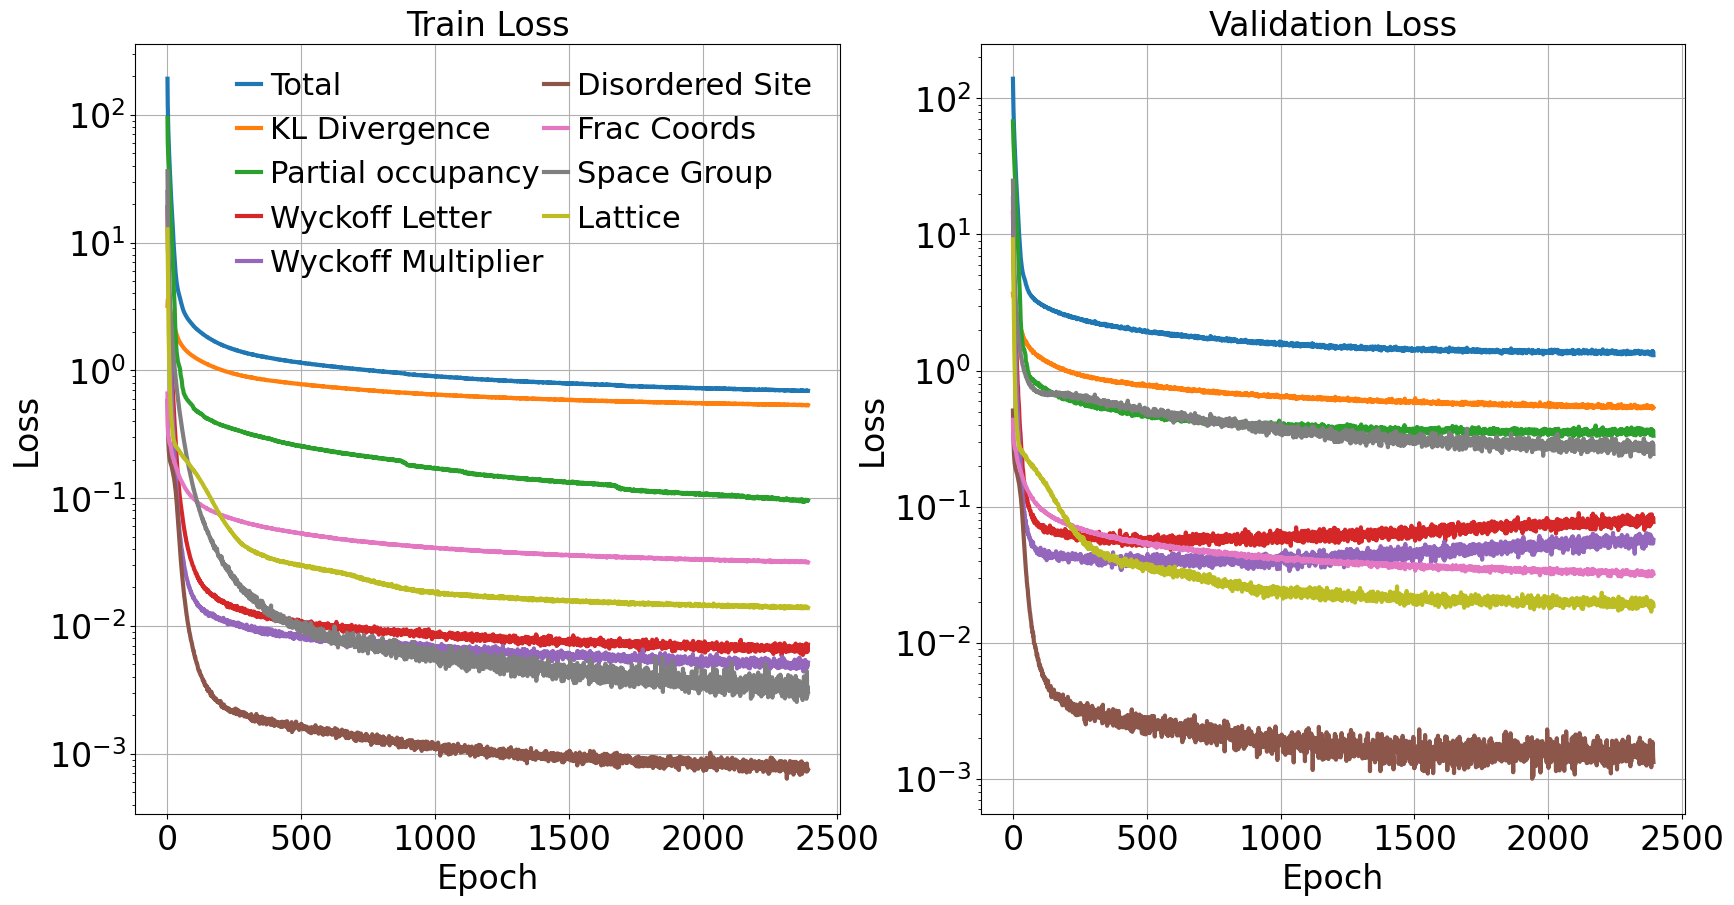

In [11]:
### Test the model on the test set and plot the results


# Load the VAE model
model_dir = 'ICSD_dis_site_most_element_lr_5e-06_epochs_2500_batch_64_test_0.2_val_0.1'

#model_dir =  'ICSD_dis_site_higher_element_lr_5e-06_epochs_2500_batch_32_test_0.2_val_0.1'
#model_dir = 'ICSD_dis_site_highest_element_lr_5e-06_epochs_2500_batch_64_test_0.2_val_0.1'
#model_dir = 'ICSD_dis_site_higher_element_lr_1e-05_epochs_2500_batch_64_test_0.2_val_0.1'
#model_dir = 'ICSD_dis_site_most_KL_element_lr_5e-06_epochs_2500_batch_64_test_0.2_val_0.1'
#model_dir = 'ICSD_dis_site_most_high_KL_element_lr_5e-06_epochs_2500_batch_64_test_0.2_val_0.1' # high error

#model_dir = 'ICSD_trainset_02_dis_site_highest_element_lr_5e-06_epochs_2500_batch_64_test_0.2_val_0.1'
#model_dir = 'ICSD_trainset_04_dis_site_highest_element_lr_5e-06_epochs_2500_batch_64_test_0.2_val_0.1'
#model_dir = 'ICSD_trainset_06_dis_site_highest_element_lr_5e-06_epochs_2500_batch_64_test_0.2_val_0.1'
#model_dir = 'ICSD_trainset_08_dis_site_highest_element_lr_5e-06_epochs_2500_batch_64_test_0.2_val_0.1'
#model_dir = 'ICSD_dis_site_highest_element_lr_5e-06_epochs_2500_batch_64_test_0.2_val_0.1'

#model_dir = 'ICSD_dis_site_highest_element_lr_5e-06_epochs_2500_batch_64_test_0.2_val_0.1'
#model_dir = 'ICSD_occ0.01_dis_site_highest_element_lr_5e-06_epochs_2500_batch_64_test_0.2_val_0.1'
#model_dir = 'ICSD_occ0.02_dis_site_highest_element_lr_5e-06_epochs_2500_batch_64_test_0.2_val_0.1'
#model_dir = 'ICSD_occ0.05_dis_site_highest_element_lr_5e-06_epochs_2500_batch_64_test_0.2_val_0.1'


best_model = True
vae_eval = VAE(feature_dim, wyckoff_dim, crystal_dim,verbose=False,kernel=kernel,stride=stride)

if best_model:
    vae_dict = torch.load(model_dir+'/best_vae_model.pth',map_location=torch.device('cpu'))
else: # use exit model
    vae_dict = torch.load(model_dir+'/exit_vae_model.pth',map_location=torch.device('cpu'))

vae_eval.load_state_dict(vae_dict['model'])
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print('X:',x_test.shape)
print('Y:',y_test.shape)
print('Coeff:',vae_dict['coeffs'])

## Plot all the losses as a function of the epoch
fig, ax = plt.subplots(1,2,figsize=(20,10))
font_size = 24
Nbins = 20
linewidth = 3
train_loss_dict = vae_dict['train_loss']
val_loss_dict = vae_dict['val_loss']

print('Train / Val loss:')
print('Epoch:' ,train_loss_dict['epoch'][-1])
print('---------------------------------')

label_name = {'total':'Total',
                'kl':'KL Divergence',
              'element':'Partial occupancy',
              'wyckoff_letter':'Wyckoff Letter',
              'wyckoff_multiplier':'Wyckoff Multiplier',
              'frac_coords':'Frac Coords',
              'space_group':'Space Group',
              'lattice':'Lattice',
              'disordered_site':'Disordered Site'}


for key in train_loss_dict:
    if key == 'epoch':
        continue
    print(key)
    print(f"Train: {train_loss_dict[key][-1]}")
    print(f"Val: {val_loss_dict[key][-1]}")
    ax[0].plot(train_loss_dict['epoch'],train_loss_dict[key],label=label_name[key],linewidth=linewidth)
    val_epoch  = np.arange(0,len(val_loss_dict[key])*log_step,log_step)
    ax[1].plot(val_loss_dict['epoch'], val_loss_dict[key],label=key,linewidth=linewidth)
print('---------------------------------')

ax[0].set_xlabel('Epoch',fontsize=font_size)
ax[0].set_ylabel('Loss',fontsize=font_size)
ax[0].set_title('Train Loss',fontsize=font_size)
ax[0].tick_params(axis='both', which='major', labelsize=font_size)
ax[0].tick_params(axis='both', which='minor', labelsize=font_size)
ax[0].grid(True)
ax[0].set_yscale('log')
ax[0].legend(fontsize=font_size-2,ncol=2,frameon=False,handlelength=0.8,handletextpad=0.3,columnspacing=0)

ax[1].set_xlabel('Epoch',fontsize=font_size)
ax[1].set_ylabel('Loss',fontsize=font_size)
ax[1].set_title('Validation Loss',fontsize=font_size)
ax[1].tick_params(axis='both', which='major', labelsize=font_size)
ax[1].tick_params(axis='both', which='minor', labelsize=font_size)
ax[1].set_yscale('log')
ax[1].grid(True)
#ax[1].legend(fontsize=font_size)

out_test = vae_eval(x_test, y_test)
loss_test = vae_loss_function(out_test, x_test, y_test,coeffs)
print('Test loss:')
print('---------------------------------')
for key in loss_test:
    # print mean loss
    print(f"{key}: {loss_test[key]/len(x_test)}")
print('---------------------------------')




x_test_plot = x_test.cpu().detach().numpy()
y_test_plot = y_test.cpu().detach().numpy()
vae_element = out_test['decoded_element'].cpu().detach().numpy()
vae_wyckoff_multiplier = out_test['decoded_wyckoff_multiplier'].cpu().detach().numpy()
vae_frac_coords = out_test['decoded_frac_coords'].cpu().detach().numpy()
vae_wyckoff_letter = out_test['decoded_wyckoff_letter'].cpu().detach().numpy()
vae_disordered_site = out_test['decoded_disordered_site'].cpu().detach().numpy()

vae_sg = out_test['decoded_sg'].cpu().detach().numpy()
vae_lattice = out_test['decoded_lattice'].cpu().detach().numpy()
print('X:',x_test_plot.shape)
print('Y:',y_test_plot.shape)
print('VAE element:',vae_element.shape)
print('VAE Wyckoff Multiplier:',vae_wyckoff_multiplier.shape)
print('VAE Frac Coords:',vae_frac_coords.shape)
print('VAE Wyckoff Letter:',vae_wyckoff_letter.shape)
print('VAE SG:',vae_sg.shape)
print('VAE Lattice:',vae_lattice.shape)

# Inverse transform the data
y_test_lattice = scaler_Y.inverse_transform(y_test_plot[:,:6])
y_test_sg = y_test_plot[:,6:]
vae_lattice = scaler_Y.inverse_transform(vae_lattice)


VAE: (27739, 3) (27739, 3) (27739,) (249651,)
Test: (27739, 3) (27739, 3) (27739,) (249651,)
---------------------------------
$a$ (MAE: 0.06)
$\alpha$ (MAE: 0.01)
$b$ (MAE: 0.06)
$\beta$ (MAE: 0.05)
$c$ (MAE: 0.10)
$\gamma$ (MAE: 0.28)
Disordered Site (Acc: 0.99865)
Spacegroup (Acc: 0.996)


(1.0, 228.0, 1.0, 228.0)

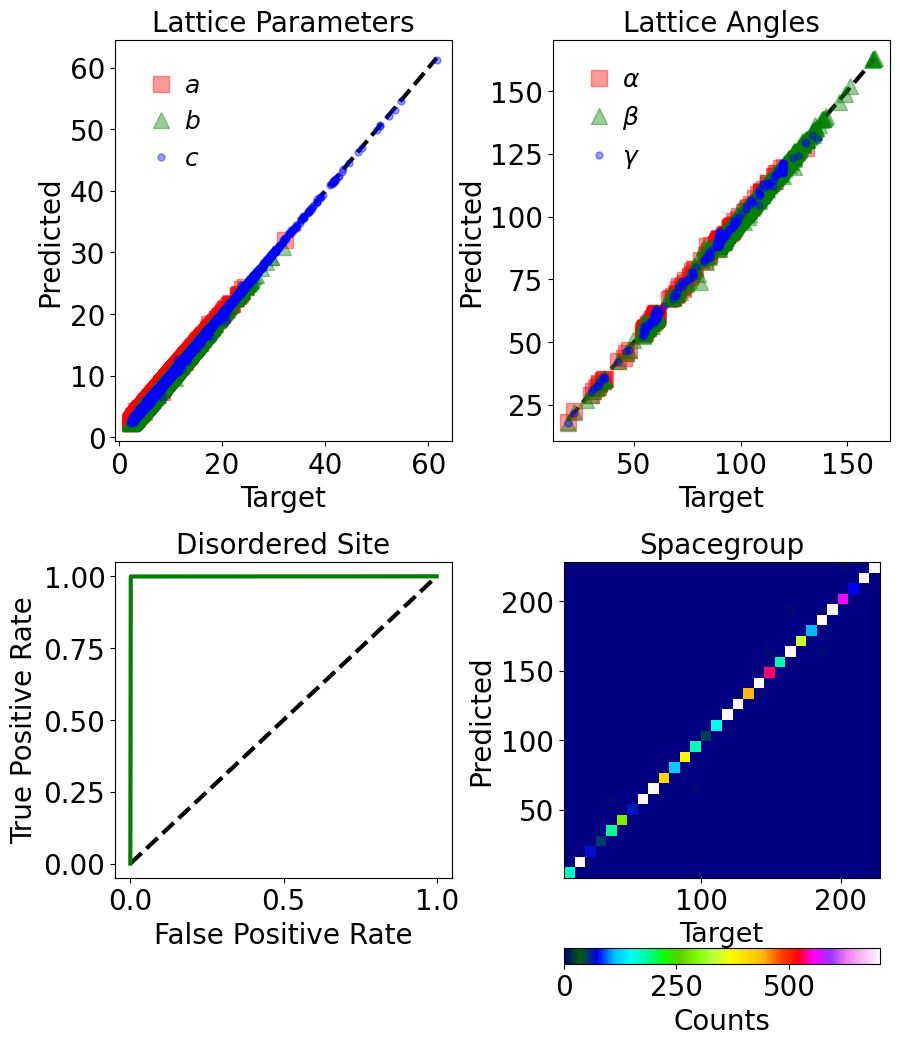

In [12]:
from matplotlib.colors import LogNorm
from sklearn.metrics import roc_curve, auc,accuracy_score
from sklearn.preprocessing import label_binarize


abc_vae = vae_lattice[:, :3]
angles_vae = vae_lattice[:, 3:]
spacegroup_vae = np.argmax(vae_sg, axis=1)
disordered_site_vae = F.sigmoid(torch.tensor(vae_disordered_site)).cpu().detach().numpy().flatten()
disordered_site_vae_index = disordered_site_vae>0.01
disordered_site_vae[~disordered_site_vae_index] = 0
disordered_site_vae_index = disordered_site_vae<0.01
disordered_site_vae[~disordered_site_vae_index] = 1
disordered_site_vae = disordered_site_vae
print('VAE:',abc_vae.shape, angles_vae.shape, spacegroup_vae.shape, disordered_site_vae.shape)

abc_test = y_test_lattice[:, :3]
angles_test = y_test_lattice[:, 3:6]
spacegroup_test = np.argmax(y_test_sg, axis=1)
disordered_site_test = x_test_plot[:,:,-31].flatten()
print('Test:',abc_test.shape, angles_test.shape, spacegroup_test.shape, disordered_site_test.shape)
print('---------------------------------')
# Plot the Crystal representation in three plots
fig, ax = plt.subplots(2, 2, figsize=(10, 12),gridspec_kw={'wspace':0.3,'hspace':0.3})
font_size = 20
handlelength = 0.2
shapes = ['s','^','.']
colors = ['r','g','b']
markersize = [12,11,10]
abc_labels = [r'$a$',r'$b$',r'$c$']
label_loc = [0.1,0.65]
alpha = 0.4
angle_labels = [r'$\alpha$',r'$\beta$',r'$\gamma$']
xlabel = 'Target'
ylabel = 'Predicted'
lw=3
vmin = 0
vmax = 700
bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2')
cmap = 'gist_ncar'
# cmap = 'jet_r'
origin = 'lower'
aspect = 'equal'

ax[0,0].plot([np.min(abc_test),np.max(abc_test)],[np.min(abc_test),np.max(abc_test)],'k--',lw=lw)
ax[0,1].plot([np.min(angles_test),np.max(angles_test)],[np.min(angles_test),np.max(angles_test)],'k--',lw=lw)
#ax[2].plot([np.min(spacegroup_test),np.max(spacegroup_test)],[np.min(spacegroup_test),np.max(spacegroup_test)],'k--')
for i in range(3):
    mae = np.mean(np.abs(abc_test[:,i] - abc_vae[:,i]))
    ax[0,0].plot(abc_test[:,i], abc_vae[:,i], marker=shapes[i], color=colors[i], linestyle='None', label=abc_labels[i],alpha=alpha,markersize=markersize[i])
    ax[0,0].set_xlabel(xlabel, fontsize=font_size)
    ax[0,0].set_ylabel(ylabel, fontsize=font_size)
    ax[0,0].set_title('Lattice Parameters', fontsize=font_size)
    ax[0,0].tick_params(axis='both', which='major', labelsize=font_size)
    ax[0,0].tick_params(axis='both', which='minor', labelsize=font_size)
    
    ax[0,0].legend(fontsize=font_size-2,loc=label_loc,frameon=False,handlelength=handlelength)
    print(abc_labels[i]+f' (MAE: {mae:.2f})')

    mae = np.mean(np.abs(angles_test[:,i] - angles_vae[:,i]))
    ax[0,1].plot(angles_test[:,i], angles_vae[:,i], marker=shapes[i], color=colors[i], linestyle='None', label=angle_labels[i],alpha=alpha,markersize=markersize[i])
    ax[0,1].set_xlabel(xlabel, fontsize=font_size)
    ax[0,1].set_ylabel(ylabel, fontsize=font_size)
    ax[0,1].set_title('Lattice Angles', fontsize=font_size)
    ax[0,1].tick_params(axis='both', which='major', labelsize=font_size)
    ax[0,1].tick_params(axis='both', which='minor', labelsize=font_size)
    ax[0,1].legend(fontsize=font_size-2,loc=label_loc,frameon=False,handlelength=handlelength)

    print(angle_labels[i]+f' (MAE: {mae:.2f})')

# Disordered site

acc_disorder = accuracy_score(disordered_site_test,disordered_site_vae)
print(f'Disordered Site (Acc: {acc_disorder:.5f})')

fpr, tpr, _ = roc_curve(disordered_site_test, disordered_site_vae)
roc_auc = auc(fpr, tpr)
# chnage size of axis
ax[1,0]

ax[1,0].plot([0, 1], [0, 1], color='black',lw=lw, linestyle='--')
ax[1,0].plot(fpr, tpr, color='green',lw=lw, label=f'ROC curve (area = {roc_auc:.2f})')
ax[1,0].set_xlabel('False Positive Rate', fontsize=font_size)
ax[1,0].set_ylabel('True Positive Rate', fontsize=font_size)
ax[1,0].tick_params(axis='both', which='major', labelsize=font_size)
ax[1,0].tick_params(axis='both', which='minor', labelsize=font_size)
ax[1,0].set_title('Disordered Site', fontsize=font_size)
#ax[1,1].legend(fontsize=font_size-2,frameon=False)
divider = make_axes_locatable(ax[1,0])
cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
#fig.add_axes(cax)

# Spacegroup
# Accuracy
spg_accuracy = accuracy_score(spacegroup_test, spacegroup_vae)
#spg_accuracy = np.mean(spacegroup_test == spacegroup_vae)
#mae = np.mean(np.abs(spacegroup_test - spacegroup_vae))
print(f'Spacegroup (Acc: {spg_accuracy:.3f})')

heatmap, xedges, yedges = np.histogram2d(spacegroup_test, spacegroup_vae, bins=30)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax[1,1].imshow(heatmap.T, extent=extent, origin=origin,cmap=cmap,aspect=aspect,vmin=vmin,vmax=vmax)
#ax[2].plot(spacegroup_test, spacegroup_vae, marker='.', color='r', linestyle='None')
ax[1,1].set_xlabel(xlabel, fontsize=font_size-0.5)
ax[1,1].set_ylabel(ylabel, fontsize=font_size)
ax[1,1].set_title('Spacegroup', fontsize=font_size)
ax[1,1].tick_params(axis='both', which='major', labelsize=font_size)
ax[1,1].tick_params(axis='both', which='minor', labelsize=font_size)

divider = make_axes_locatable(ax[1,1])
cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation="horizontal")
cbar.set_label('Counts', fontsize=font_size)
cbar.ax.tick_params(labelsize=font_size)
ax[1,1].axis('equal')


Disordered sites: 45895
Partial occupancy (MAE): 0.05258089162673919
Wyckoff Multiplicity (Acc): 0.9953225582364655
Wyckoff Letter (Acc): 0.9930533043115825
Fractional Coordinates (MAE): 0.071691744
-------------------------------------
Ordered sites: 80174
Element (Acc): 0.9904582532990746
Wyckoff Multiplicity (Acc): 0.9975303714421134
Wyckoff Letter (Acc): 0.9961957741911343
Fractional Coordinates (MAE): 0.079868846


Text(0.5, 1.03, 'Ordered Wyckoff sites')

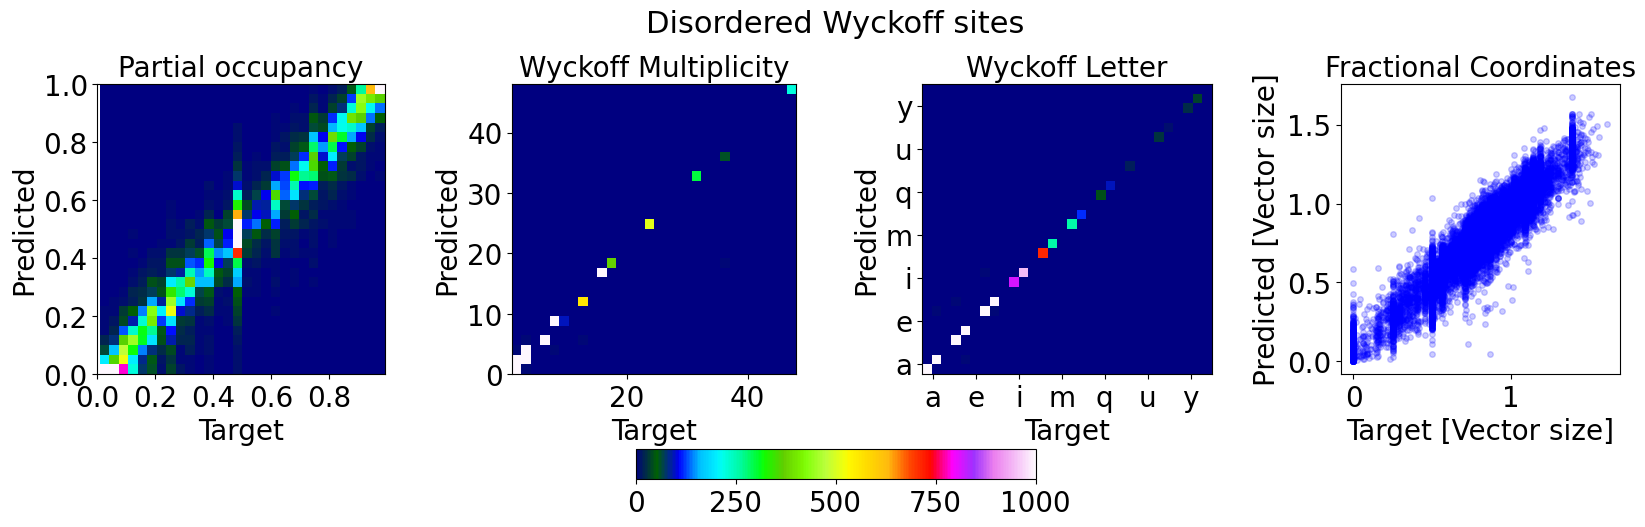

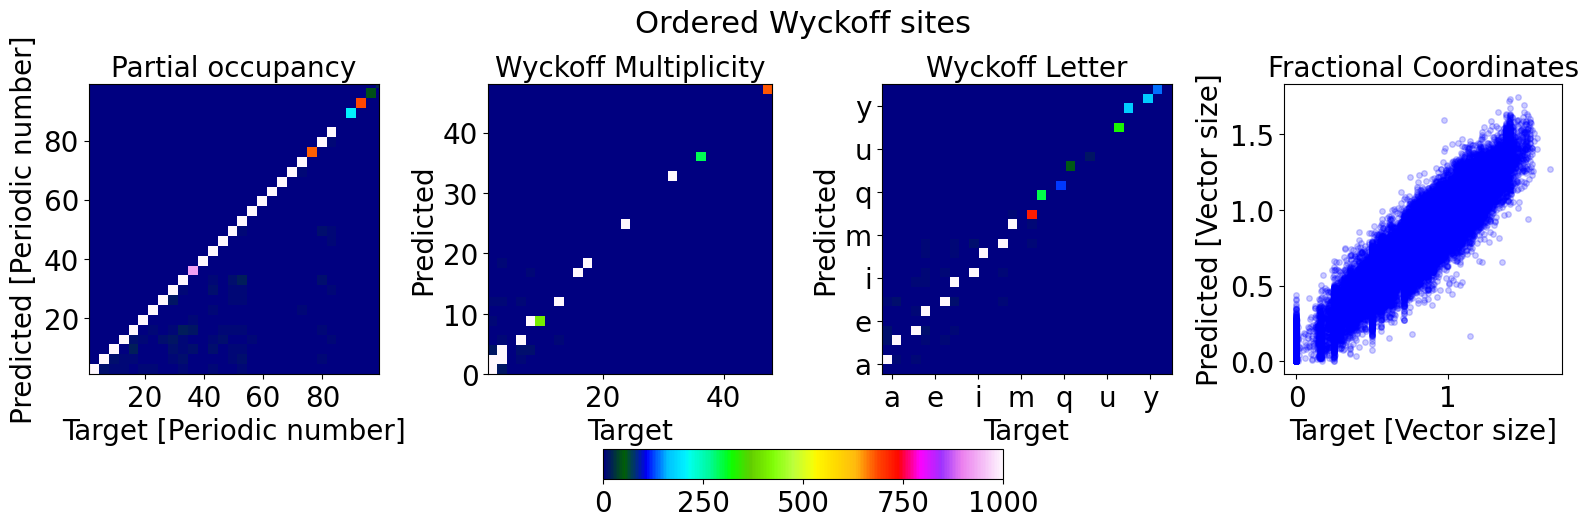

In [13]:
# Remove data points which are zero padding
element_test = x_test_plot[:,:,:101]
frac_coords_test = x_test_plot[:,:,-30:-27]
wyckoff_letter_test = x_test_plot[:,:,-27:]
wyckoff_mult_test = x_test_plot[:,:,101:-31]

element_test_occ_disorder = []
element_test_int_disorder = []
wyckoff_mult_test_plot_disorder = []
wyckoff_letter_test_plot_disorder = []
frac_coords_test_plot_disorder = []

element_test_occ_order = []
element_test_int_order = []
wyckoff_mult_test_plot_order = []
wyckoff_letter_test_plot_order = []
frac_coords_test_plot_order = []

wyckoff_mult_vae_plot_disorder = []
wyckoff_letter_vae_plot_disorder = []
frac_coords_vae_plot_disorder = []
element_vae_occ_disorder = []
element_vae_int_disorder = []


wyckoff_mult_vae_plot_order = []
wyckoff_letter_vae_plot_order = []
frac_coords_vae_plot_order = []
element_vae_occ_order = []
element_vae_int_order = []

for i in range(element_test.shape[0]):
    # Use wyckoff letter and multiplier to remove zero padding
    wyckoff_letter_vae_i = np.argmax(vae_wyckoff_letter[i],axis=1)
    wyckoff_mult_vae_i = np.argmax(vae_wyckoff_multiplier[i],axis=1)

    wyckoff_letter_test_i = np.argmax(wyckoff_letter_test[i],axis=1)
    wyckoff_mult_test_i = np.argmax(wyckoff_mult_test[i],axis=1)

    # Find the zeros in the wyckoff letter and multiplier
    index = wyckoff_letter_vae_i != 0

    # Define element occupations:
    element_vae_i = np.round(vae_element[i,index,:],2)
    element_test_i = np.round(element_test[i,index,:],2)

    # Assume that if a properbility is lower than 1% it is zero
    element_index = element_vae_i > 0.01
    element_vae_i[~element_index] = 0

    # Loop over each wyckoff site
    for site in range(element_vae_i.shape[0]):
        # Define element occupations for the site
        elem_test_list,elem_vae_list = element_test_i[site],element_vae_i[site]

        # Find the elements which are occupied
        element_int_index = np.where(elem_test_list>0)[0]
        # Sort the elements by occupation
        #element_int_vae_index= np.argsort(elem_vae_list)[::-1]

        if len(element_int_index) > 1:
            # Disorder
            n_disorder = len(element_int_index)
            element_int_test_index = np.argsort(elem_test_list)[::-1]

            # Loop over the elements
            for n in range(n_disorder):
                elem = element_int_test_index[n]
                element_test_occ_disorder.append(elem_test_list[elem])
                element_test_int_disorder.append(elem+1) # +1 to get the correct element
                
                

                if elem_vae_list[elem] == 0:
                    element_vae_int_disorder.append(0)
                    element_vae_occ_disorder.append(0)
                else:
                    element_vae_int_disorder.append(elem+1) # +1 to get the correct element
                    element_vae_occ_disorder.append(elem_vae_list[elem])
            # Find the element with the highest occupation
            

            wyckoff_mult_vae_plot_disorder.append(wyckoff_mult_vae_i[site])
            wyckoff_letter_vae_plot_disorder.append(wyckoff_letter_vae_i[site])
            frac_coords_vae_plot_disorder.append(vae_frac_coords[i,site,:])

            wyckoff_mult_test_plot_disorder.append(wyckoff_mult_test_i[site])
            wyckoff_letter_test_plot_disorder.append(wyckoff_letter_test_i[site])
            frac_coords_test_plot_disorder.append(frac_coords_test[i,site,:])
        else:
            # Ordered
            # Loop over the elements
            for elem in element_int_index:
                element_test_occ_order.append(elem_test_list[elem])
                element_test_int_order.append(elem+1)

            element_int_vae_index = np.argmax(elem_vae_list>0)
            element_vae_int_order.append(element_int_vae_index+1) # +1 to get the correct element
            element_vae_occ_order.append(elem_vae_list[element_int_vae_index])
            
            wyckoff_mult_vae_plot_order.append(wyckoff_mult_vae_i[site])
            wyckoff_letter_vae_plot_order.append(wyckoff_letter_vae_i[site])
            frac_coords_vae_plot_order.append(vae_frac_coords[i,site,:])

            wyckoff_mult_test_plot_order.append(wyckoff_mult_test_i[site])
            wyckoff_letter_test_plot_order.append(wyckoff_letter_test_i[site])
            frac_coords_test_plot_order.append(frac_coords_test[i,site,:])


# Plot VAE vs ICSD
# Disordered
fig, ax = plt.subplots(1, 4, figsize=(20, 5),gridspec_kw={'wspace':0.33})
font_size = 20
marker = '.'
color = 'b'
alpha = 0.2
marker = '.'
marker_size = 8
legend_loc = (0,-0.3)
text_loc = (0.2,-0.25)
bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2')
xlabel = 'Target'
ylabel = 'Predicted'
cmap = 'gist_ncar'
origin = 'lower'
aspect = 'equal'
vmin = 0
vmax= 1000
Nbins = 30

handlelength = 0.2
shapes = ['s','^','.']
colors = ['r','g','b']
marker_sizes = [9,8,7]
label_name = [r'$x$',r'$y$',r'$z$']
label_loc = [0.1,0.65]

print('Disordered sites:',len(element_test_occ_disorder))
# Element Occupation
element_test_plot = np.array(element_test_occ_disorder)
element_vae_plot = np.array(element_vae_occ_disorder)

mae_element = np.mean(np.abs(element_test_plot - element_vae_plot))
#ax[0].plot(element_test_plot, element_vae_plot, marker=marker, color=color, 
#            linestyle='None',label=f'MAE: {mae_element:.3f}',alpha=alpha)
# heatmap
heatmap, xedges, yedges = np.histogram2d(element_test_plot, element_vae_plot, bins=Nbins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax[0].imshow(heatmap.T, extent=extent, origin=origin,cmap=cmap,aspect=aspect,vmin=vmin,vmax=vmax)
ax[0].set_xlabel(xlabel, fontsize=font_size)
ax[0].set_ylabel(ylabel, fontsize=font_size)
ax[0].set_title('Partial occupancy', fontsize=font_size)
ax[0].tick_params(axis='both', which='major', labelsize=font_size)
ax[0].tick_params(axis='both', which='minor', labelsize=font_size)
ax[0].set_xticks(np.arange(0,1, step=0.2,))
print('Partial occupancy (MAE):',mae_element)
#ax[0].text(0.2,-0.6,f'MAE: {mae_element:.3f}',
#        horizontalalignment='center',
#        verticalalignment='center',
#        transform = ax[0].transAxes,
#        fontsize=font_size,
#        bbox=bbox)

# Wyckoff Multiplicity +1 to get the correct number
wyckoff_mult_test_plot = np.array(wyckoff_mult_test_plot_disorder)
wyckoff_mult_vae_plot = np.array(wyckoff_mult_vae_plot_disorder)
acc_wyckoff_mult = accuracy_score(wyckoff_mult_test_plot, wyckoff_mult_vae_plot) # same as taking the mean of the wyckoff sites and then the mean of the structures


heatmap, xedges, yedges = np.histogram2d(wyckoff_mult_test_plot, wyckoff_mult_vae_plot, bins=Nbins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax[1].imshow(heatmap.T, extent=extent, origin=origin,cmap=cmap,aspect=aspect,vmin=vmin,vmax=vmax)
#ax[1].plot(wyckoff_mult_test_plot, wyckoff_mult_vae_plot, marker=marker, color=color,
            #linestyle='None',label=f'Acc. : {acc_wyckoff_mult:.2f}',alpha=alpha,markersize=marker_size)
ax[1].set_xlabel(xlabel, fontsize=font_size)
ax[1].set_ylabel(ylabel, fontsize=font_size)
ax[1].set_title('Wyckoff Multiplicity', fontsize=font_size)
ax[1].tick_params(axis='both', which='major', labelsize=font_size)
ax[1].tick_params(axis='both', which='minor', labelsize=font_size)
#ax[1].legend(fontsize=font_size,loc=legend_loc)
#ax[1].text(text_loc[0],text_loc[1],f'Acc: {acc_wyckoff_mult:.3f}',
#        horizontalalignment='center',
#        verticalalignment='center',
#        transform = ax[1].transAxes,
#        fontsize=font_size,
#        bbox=bbox)
print('Wyckoff Multiplicity (Acc):',acc_wyckoff_mult)

# Wyckoff Letter -1 to get the correct letter
wyckoff_letter_test_plot = np.array(wyckoff_letter_test_plot_disorder)
wyckoff_letter_vae_plot = np.array(wyckoff_letter_vae_plot_disorder)
acc_wyckoff_letter = accuracy_score(wyckoff_letter_test_plot, wyckoff_letter_vae_plot)


heatmap, xedges, yedges = np.histogram2d(wyckoff_letter_test_plot, wyckoff_letter_vae_plot, bins=Nbins)
extent = [0, 27, 0, 27]
im = ax[2].imshow(heatmap.T, extent=extent, origin=origin,cmap=cmap,aspect=aspect,vmin=vmin,vmax=vmax)
#ax[2].plot(wyckoff_letter_test_plot, wyckoff_letter_vae_plot, marker=marker, color=color, 
#            linestyle='None',label=f'Acc. : {acc_wyckoff_letter:.2f}',alpha=alpha,markersize=marker_size)
ax[2].set_xlabel(f'{xlabel}', fontsize=font_size)
ax[2].set_ylabel(f'{ylabel}', fontsize=font_size)
ax[2].set_title('Wyckoff Letter', fontsize=font_size)

wyckoff_label = {i:chr(i+97) for i in range(26)}
ax[2].set_xticks(np.arange(1,26,4))
ax[2].set_xticklabels([wyckoff_label[i-1] for i in ax[2].get_xticks()])
ax[2].set_yticks(np.arange(1,26,4))
ax[2].set_yticklabels([wyckoff_label[i-1] for i in ax[2].get_yticks()])
ax[2].tick_params(axis='both', which='major', labelsize=font_size)
ax[2].tick_params(axis='both', which='minor', labelsize=font_size)
#ax[2].legend(fontsize=font_size,loc=legend_loc)
#ax[2].text(text_loc[0],text_loc[1],f'Acc: {acc_wyckoff_letter:.3f}',
#        horizontalalignment='center',
#        verticalalignment='center',
#        transform = ax[2].transAxes,
#        fontsize=font_size,
#        bbox=bbox)
print('Wyckoff Letter (Acc):',acc_wyckoff_letter)

# Fractional Coordinates
frac_coords_test_plot = np.sqrt(np.sum(np.square(frac_coords_test_plot_disorder),axis=1))
frac_coords_vae_plot = np.sqrt(np.sum(np.square(frac_coords_vae_plot_disorder),axis=1))
frac_coords_test_plot = frac_coords_test_plot.flatten()
frac_coords_vae_plot = frac_coords_vae_plot.flatten()
mae_frac_coords = np.mean(np.abs(frac_coords_test_plot - frac_coords_vae_plot))
print('Fractional Coordinates (MAE):',mae_frac_coords)

ax[3].plot(frac_coords_test_plot, frac_coords_vae_plot, marker=marker, color=color, 
            linestyle='None',label=f'MAE: {mae:.2f}',alpha=alpha,markersize=marker_size)
ax[3].set_xlabel(f'{xlabel} [Vector size]', fontsize=font_size)
ax[3].set_ylabel(f'{ylabel} [Vector size]', fontsize=font_size)
ax[3].set_title('Fractional Coordinates', fontsize=font_size)
ax[3].tick_params(axis='both', which='major', labelsize=font_size)
ax[3].tick_params(axis='both', which='minor', labelsize=font_size)
ax[3].set(adjustable='box', aspect='equal')
#ax[3].legend(fontsize=font_size,loc=legend_loc)
#ax[3].text(text_loc[0],text_loc[1],f'MAE: {mae:.3f}',
#        horizontalalignment='center',
#        verticalalignment='center',
#        transform = ax[3].transAxes,
#        fontsize=font_size,
#        bbox=bbox)

fig.subplots_adjust(bottom=0.3)
cbar_ax = fig.add_axes([0.4, 0.09, 0.2, 0.06]) # x, y, width, height
cbar_ax.set_xlabel('Counts', fontsize=font_size)
cbar_ax.tick_params(axis='both', which='major', labelsize=font_size)
cbar_ax.tick_params(axis='both', which='minor', labelsize=font_size)
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

# Set subplot title
fig.suptitle('Disordered Wyckoff sites', fontsize=font_size+2, y=1.03)

print('-------------------------------------')
print('Ordered sites:',len(element_test_int_order))
# Ordered
fig, ax = plt.subplots(1, 4, figsize=(20, 5),gridspec_kw={'wspace':0.1})
vmin = 0
vmax= 1000
# Element INT
acc_element = accuracy_score(element_test_int_order, element_vae_int_order)
heatmap, xedges, yedges = np.histogram2d(element_test_int_order, element_vae_int_order, bins=Nbins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax[0].imshow(heatmap.T, extent=extent, origin=origin,cmap=cmap,aspect=aspect,vmin=vmin,vmax=vmax)
#ax[0].plot(element_test_int_order, element_vae_int_order, marker=marker, color=color,
#            linestyle='None',label=f'Acc. : {acc_element:.2f}',alpha=alpha,markersize=marker_size)
ax[0].set_xlabel(f'{xlabel} [Periodic number]', fontsize=font_size)
ax[0].set_ylabel(f'{ylabel} [Periodic number]', fontsize=font_size)
ax[0].set_title('Partial occupancy', fontsize=font_size)
ax[0].tick_params(axis='both', which='major', labelsize=font_size)
ax[0].tick_params(axis='both', which='minor', labelsize=font_size)
ax[0].set_ylim(1,99)
ax[0].set_xlim(1,99)
ax[0].set_xticks(np.array([20,40,60,80]))
#ax[0].legend(fontsize=font_size,loc=legend_loc)
#ax[0].text(text_loc[0],text_loc[1],f'Acc: {acc_element:.3f}',
#        horizontalalignment='center',
#        verticalalignment='center',
#        transform = ax[0].transAxes,
#        fontsize=font_size,
#        bbox=bbox)
print('Element (Acc):',acc_element)

# Wyckoff Multiplicity +1 to get the correct number
wyckoff_mult_test_plot = np.array(wyckoff_mult_test_plot_order)
wyckoff_mult_vae_plot = np.array(wyckoff_mult_vae_plot_order)
acc_wyckoff_mult = accuracy_score(wyckoff_mult_test_plot, wyckoff_mult_vae_plot) # same as taking the mean of the wyckoff sites and then the mean of the structures
heatmap, xedges, yedges = np.histogram2d(wyckoff_mult_test_plot, wyckoff_mult_vae_plot, bins=Nbins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax[1].imshow(heatmap.T, extent=extent, origin=origin,cmap=cmap,aspect=aspect,vmin=vmin,vmax=vmax)
#ax[1].plot(wyckoff_mult_test_plot, wyckoff_mult_vae_plot, marker=marker, color=color,
#            linestyle='None',label=f'Acc. : {acc_wyckoff_mult:.2f}',alpha=alpha,markersize=marker_size)
ax[1].set_xlabel(xlabel, fontsize=font_size)
ax[1].set_ylabel(ylabel, fontsize=font_size)
ax[1].set_title('Wyckoff Multiplicity', fontsize=font_size)
ax[1].tick_params(axis='both', which='major', labelsize=font_size)
ax[1].tick_params(axis='both', which='minor', labelsize=font_size)
#ax[1].legend(fontsize=font_size,loc=legend_loc)
#ax[1].text(text_loc[0],text_loc[1],f'Acc: {acc_wyckoff_mult:.3f}',
#        horizontalalignment='center',
#        verticalalignment='center',
#        transform = ax[1].transAxes,
#        fontsize=font_size,
#        bbox=bbox)
print('Wyckoff Multiplicity (Acc):',acc_wyckoff_mult)

# Wyckoff Letter -1 to get the correct letter
wyckoff_letter_test_plot = np.array(wyckoff_letter_test_plot_order)
wyckoff_letter_vae_plot = np.array(wyckoff_letter_vae_plot_order)

acc_wyckoff_letter = accuracy_score(wyckoff_letter_test_plot, wyckoff_letter_vae_plot)
heatmap, xedges, yedges = np.histogram2d(wyckoff_letter_test_plot, wyckoff_letter_vae_plot, bins=Nbins)
extent = [0, 27, 0, 27]
im = ax[2].imshow(heatmap.T, extent=extent, origin=origin,cmap=cmap,aspect=aspect,vmin=vmin,vmax=vmax)

#ax[2].plot(wyckoff_letter_test_plot, wyckoff_letter_vae_plot, marker=marker, color=color, 
#            linestyle='None',label=f'Acc. : {acc_wyckoff_letter:.2f}',alpha=alpha,markersize=marker_size)
ax[2].set_xlabel(f'{xlabel}', fontsize=font_size)
ax[2].set_ylabel(f'{ylabel}', fontsize=font_size)
ax[2].set_title('Wyckoff Letter', fontsize=font_size)
ax[2].tick_params(axis='both', which='major', labelsize=font_size)
ax[2].tick_params(axis='both', which='minor', labelsize=font_size)

wyckoff_label = {i:chr(i+97) for i in range(26)}

ax[2].set_xticks(np.arange(1,26,4))
ax[2].set_xticklabels([wyckoff_label[i-1] for i in ax[2].get_xticks()])
ax[2].set_yticks(np.arange(1,26,4))
ax[2].set_yticklabels([wyckoff_label[i-1] for i in ax[2].get_yticks()])

#ax[2].legend(fontsize=font_size,loc=legend_loc)
#ax[2].text(text_loc[0],text_loc[1],f'Acc: {acc_wyckoff_letter:.3f}',
#        horizontalalignment='center',
#        verticalalignment='center',
#        transform = ax[2].transAxes,
#        fontsize=font_size,
#        bbox=bbox)
print('Wyckoff Letter (Acc):',acc_wyckoff_letter)

# Fractional Coordinates
frac_coords_test_plot = np.sqrt(np.sum(np.square(frac_coords_test_plot_order),axis=1))
frac_coords_vae_plot = np.sqrt(np.sum(np.square(frac_coords_vae_plot_order),axis=1))
frac_coords_test_plot = frac_coords_test_plot.flatten()
frac_coords_vae_plot = frac_coords_vae_plot.flatten()
mae_frac_coords = np.mean(np.abs(frac_coords_test_plot - frac_coords_vae_plot))
print('Fractional Coordinates (MAE):',mae_frac_coords)

heatmap, xedges, yedges = np.histogram2d(frac_coords_test_plot, frac_coords_vae_plot, bins=Nbins)
extent = [yedges[0], yedges[-1], yedges[0], yedges[-1]]
#im = ax[3].imshow(heatmap.T, extent=extent, origin=origin,cmap=cmap,aspect=aspect,vmin=vmin,vmax=vmax)
ax[3].plot(frac_coords_test_plot, frac_coords_vae_plot, marker=marker, color=color, 
            linestyle='None',label=f'MAE: {mae:.2f}',alpha=alpha,markersize=marker_size)
ax[3].set_xlabel(f'{xlabel} [Vector size]', fontsize=font_size)
ax[3].set_ylabel(f'{ylabel} [Vector size]', fontsize=font_size)
ax[3].set_title('Fractional Coordinates', fontsize=font_size)
ax[3].tick_params(axis='both', which='major', labelsize=font_size)
ax[3].tick_params(axis='both', which='minor', labelsize=font_size)
ax[3].set(adjustable='box', aspect='equal')
#ax[3].set_adjustable('box')
#for k in range(3):
#    frac_coords_test_plot = np.array(frac_coords_test_plot_order)[:,k]
#    frac_coords_vae_plot = np.array(frac_coords_vae_plot_order)[:,k]
#    mae = np.mean(np.abs(frac_coords_test_plot - frac_coords_vae_plot))
#    ax[3].plot(frac_coords_test_plot, frac_coords_vae_plot, marker=shapes[k], color=colors[k], 
#                linestyle='None',label=label_name[k],alpha=alpha,markersize=marker_sizes[k])
#    ax[3].set_xlabel(f'{xlabel} [Vector size]', fontsize=font_size)
#    ax[3].set_ylabel(f'{ylabel} [Vector size]', fontsize=font_size)
#    ax[3].set_title('Fractional Coordinates', fontsize=font_size)
#    ax[3].tick_params(axis='both', which='major', labelsize=font_size)
#    ax[3].tick_params(axis='both', which='minor', labelsize=font_size)

#ax[3].legend(fontsize=font_size,loc=legend_loc)
#ax[3].text(text_loc[0],text_loc[1],f'MAE: {mae:.3f}',
#        horizontalalignment='center',
#        verticalalignment='center',
#        transform = ax[3].transAxes,
#        fontsize=font_size,
#        bbox=bbox)
#    print(f'Fractional Coordinates (MAE): {label_name[k]}={mae:.3f}')
#ax[3].legend(fontsize=font_size-2,loc=legend_loc)
# Set subplot title

#from mpl_toolkits.axes_grid1 import make_axes_locatable
#divider = make_axes_locatable(ax[3])
#cax = divider.new_vertical(size="5%", pad=0.5, pack_start=True)

fig.subplots_adjust(bottom=0.3)
cbar_ax = fig.add_axes([0.4, 0.09, 0.2, 0.06]) # x, y, width, height
cbar_ax.tick_params(axis='both', which='major', labelsize=font_size)
cbar_ax.tick_params(axis='both', which='minor', labelsize=font_size)
cbar_ax.set_xlabel('Counts', fontsize=font_size)

fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

fig.suptitle('Ordered Wyckoff sites', fontsize=font_size+2,y=1.03)

In [12]:
from pyxtal.symmetry import Group
vae_wyckoff_mult_plot = []
wyckoff_mult_from_letter = []

for i in range(element_test.shape[0]):
    if i % 500 == 0:
        print(f'Progress: {i}/{element_test.shape[0]}')
    # Use wyckoff letter and multiplier to remove zero padding
    wyckoff_letter_vae_i = np.argmax(vae_wyckoff_letter[i],axis=1)
    wyckoff_mult_vae_i = np.argmax(vae_wyckoff_multiplier[i],axis=1)
    spg_i = int(np.argmax(y_test[i,6:]) ) +1

    # Find the zeros in the wyckoff letter and multiplier
    index = wyckoff_letter_vae_i != 0

    # Define wyckoff_letter and wyckoff multiplier
    wyckoff_letter_vae_i_str = np.array([chr(ord('a') + l-1) for l in wyckoff_letter_vae_i[index]]) # Convert to letter from number 
    wyckoff_mult_vae_i_reduced = wyckoff_mult_vae_i[index] 
    
    # Loop over the wyckoff sites and get the multiplicity from the letter
    for vae_mult, letter in zip(wyckoff_mult_vae_i_reduced,wyckoff_letter_vae_i_str):
        try:
            mult_i = Group(spg_i).get_wp_by_letter(letter).multiplicity
        except IndexError:
            mult_i = 0
        wyckoff_mult_from_letter.append(mult_i)
        vae_wyckoff_mult_plot.append(vae_mult)



Progress: 0/27739
Progress: 500/27739
Progress: 1000/27739
Progress: 1500/27739
Progress: 2000/27739
Progress: 2500/27739
Progress: 3000/27739
Progress: 3500/27739
Progress: 4000/27739
Progress: 4500/27739
Progress: 5000/27739
Progress: 5500/27739
Progress: 6000/27739
Progress: 6500/27739
Progress: 7000/27739
Progress: 7500/27739
Progress: 8000/27739
Progress: 8500/27739
Progress: 9000/27739
Progress: 9500/27739
Progress: 10000/27739
Progress: 10500/27739
Progress: 11000/27739
Progress: 11500/27739
Progress: 12000/27739
Progress: 12500/27739
Progress: 13000/27739
Progress: 13500/27739
Progress: 14000/27739
Progress: 14500/27739
Progress: 15000/27739
Progress: 15500/27739
Progress: 16000/27739
Progress: 16500/27739
Progress: 17000/27739
Progress: 17500/27739
Progress: 18000/27739
Progress: 18500/27739
Progress: 19000/27739
Progress: 19500/27739
Progress: 20000/27739
Progress: 20500/27739
Progress: 21000/27739
Progress: 21500/27739
Progress: 22000/27739
Progress: 22500/27739
Progress: 23

0.9947134139750606


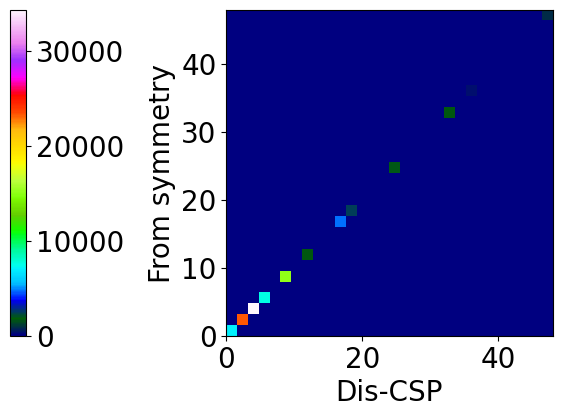

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
font_size = 20
marker = '.'
color = 'b'
alpha = 0.5
markersize= 22
acc_mult = accuracy_score(wyckoff_mult_from_letter, vae_wyckoff_mult_plot)
print(acc_mult)
heatmap, xedges, yedges = np.histogram2d(vae_wyckoff_mult_plot, wyckoff_mult_from_letter, bins=Nbins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax.imshow(heatmap.T, extent=extent, origin=origin,cmap=cmap,aspect=aspect)

#ax.plot(vae_wyckoff_mult_plot, wyckoff_mult_from_letter, marker=marker, color=color,markersize=markersize,
#        linestyle='None',label=f'Acc. : {acc_wyckoff_mult:.2f}',alpha=alpha)

ax.set_xlabel('Dis-CSP', fontsize=font_size)
ax.set_ylabel('From symmetry', fontsize=font_size)
#ax.set_title('Wyckoff Multiplicity', fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
ax.tick_params(axis='both', which='minor', labelsize=font_size)
#ax.legend(fontsize=font_size,loc=(-0,-0.4))
ax.set_xlim(0,48)
ax.set_ylim(0,48)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size="5%", pad=2, pack_start=True)
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation="vertical")
#cbar.set_label('Counts', fontsize=font_size)
cbar.ax.tick_params(labelsize=font_size)

### Validation

In [9]:
print('x1_test:',x_test.shape)
print('y1_test:',y_test.shape)

x1_test: torch.Size([27739, 9, 183])
y1_test: torch.Size([27739, 236])


In [10]:
z_mean_test, z_var_test = vae_eval.encode(x_test,y_test)
z_sample_test = vae_eval.sampling(z_mean_test, z_var_test)
np.save('z_sample_test.npy',z_sample_test.detach().numpy())

In [9]:
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
z_mean_train, z_var_train = vae_eval.encode(x_train,y_train)
z_sample_train = vae_eval.sampling(z_mean_train, z_var_train)
np.save('z_sample_train.npy',z_sample_train.detach().numpy())

In [24]:
# Random encode and sample from the VAE
vae_random = VAE(feature_dim, wyckoff_dim, crystal_dim,verbose=False,kernel=kernel,stride=stride)
z_mean_test, z_var_test = vae_random.encode(x_test,y_test)
z_mean_ran, z_var_ran = vae_eval.encode(x_test,y_test)

z_sample_test = vae_random.sampling(z_mean_ran, z_var_ran)

z_sample_ran = vae_random.sampling(z_mean_ran, z_var_ran)
# Use the pretrained VAE to decode the random samples
decode_ran = vae_eval.decode(z_sample_ran)

#### Estimate latent space distribution

In [14]:
# Do KDE on the latent space
from sklearn.neighbors import KernelDensity
load_str = 'z_sample_train.npy'
z_sample_train = np.load(load_str)
kde = KernelDensity(kernel='gaussian', bandwidth=0.25)
kde.fit(z_sample_train)
# Sample from the learned distribution
z_samples_kde = torch.tensor(kde.sample(n_samples=len(x_test))).float().to(device)
decode_kde = vae_eval.decode(z_samples_kde)


In [11]:
from sklearn.mixture import GaussianMixture

# Get test latent space
z_sample_train = np.load(load_str)
# Fit GMM to latent space of test data
gmm = GaussianMixture(n_components=5, covariance_type='full')
gmm.fit(z_sample_train)

# Sample from the learned distribution
z_samples_gmm = torch.tensor(gmm.sample(n_samples=len(x_test))[0]).float().to(device)
decode_gmm = vae_eval.decode(z_samples_gmm)


In [12]:
z_sample_ran = torch.randn(len(x_test_plot), latent_dim) # Generates random latent vectors from a normal distribution 𝑁(0,𝐼)
decode_ran = vae_eval.decode(z_sample_ran)

In [13]:
z_sample_test = np.load('z_sample_test.npy')
decode_vae = vae_eval.decode(torch.tensor(z_sample_test).float().to(device))

In [14]:
import umap
# Reduce to 2D using UMAP
comp = 2
random_seed = 42
umap_test = umap.UMAP(n_components=comp, random_state=random_seed)
z_test_2d = umap_test.fit_transform(z_sample_test)

umap_ran = umap.UMAP(n_components=comp, random_state=random_seed)
z_ran_2d = umap_ran.fit_transform(z_sample_ran.cpu().numpy())

umap_gmm = umap.UMAP(n_components=comp, random_state=random_seed)
z_gmm_2d = umap_gmm.fit_transform(z_samples_gmm.cpu().numpy())

umap_kde = umap.UMAP(n_components=comp, random_state=random_seed)
z_kde_2d = umap_kde.fit_transform(z_samples_kde.cpu().numpy())


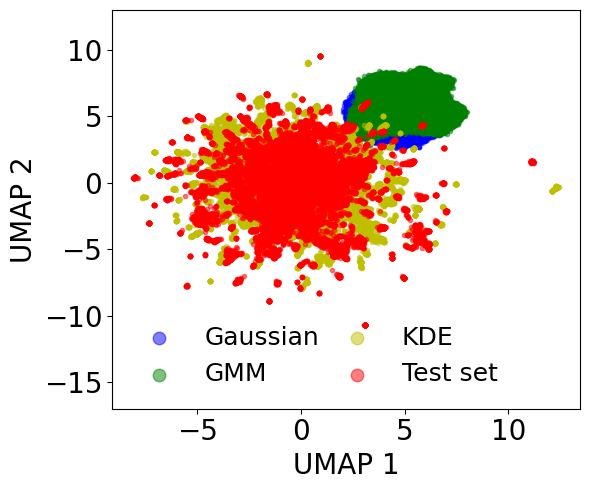

In [15]:
# Plot the latent space in one plot
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
font_size = 20
marker = '.'
color = 'b'
alpha = 0.5
font = 18
# Plot the random data
ax.scatter(z_ran_2d[:,0], z_ran_2d[:,1], marker=marker, color='b',label='Gaussian',alpha=alpha)
# Plot the GMM data
ax.scatter(z_gmm_2d[:,0], z_gmm_2d[:,1], marker=marker, color='g',label='GMM',alpha=alpha)
# Plot the KDE data
ax.scatter(z_kde_2d[:,0], z_kde_2d[:,1], marker=marker, color='y',label='KDE',alpha=alpha)
# Plot the test data
ax.scatter(z_test_2d[:,0], z_test_2d[:,1], marker=marker, color='r',label='Test set',alpha=alpha)

ax.set_xlabel('UMAP 1', fontsize=font_size)
ax.set_ylabel('UMAP 2', fontsize=font_size)
#ax.set_title('Latent space', fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
ax.tick_params(axis='both', which='minor', labelsize=font_size)
ax.legend(fontsize=font_size-2,ncols=2,markerscale=3.,frameon=False,columnspacing=0.5)
ax.set_ylim(-17,13)
plt.tight_layout()

In [14]:
element_ran,wyckoff_multiplier_ran,frac_coords_ran,wyckoff_letter_ran, sg_ran, lattice_ran,disordered_site_ran = decode_ran
lattice_ran = scaler_Y.inverse_transform(lattice_ran.detach().numpy())

element_gmm,wyckoff_multiplier_gmm,frac_coords_gmm,wyckoff_letter_gmm, sg_gmm, lattice_gmm,disordered_site_gmm = decode_gmm
lattice_gmm = scaler_Y.inverse_transform(lattice_gmm.detach().numpy())

element_kde,wyckoff_multiplier_kde,frac_coords_kde,wyckoff_letter_kde, sg_kde, lattice_kde,disordered_site_kde = decode_kde
lattice_kde = scaler_Y.inverse_transform(lattice_kde.detach().numpy())

element_vae, wyckoff_multiplier_vae, frac_coords_vae, wyckoff_letter_vae, sg_vae, lattice_vae, disordered_site_vae = decode_vae
lattice_vae = scaler_Y.inverse_transform(lattice_vae.detach().numpy())

save_dict_gmm = {'abc':np.round(lattice_gmm[:, :3],1),'angles':np.round(lattice_gmm[:, 3:6],1),'spacegroup':np.argmax(sg_gmm.detach().numpy(),axis=1),
                'disordered_site': F.sigmoid(torch.tensor(disordered_site_gmm)).cpu().detach().numpy(),
                'element':element_gmm.detach().numpy(),'wyckoff_letter':wyckoff_letter_gmm.detach().numpy(),
                'wyckoff_mult':wyckoff_multiplier_gmm.detach().numpy(),'frac_coords':frac_coords_gmm.detach().numpy()}


save_dict_kde = {'abc':np.round(lattice_kde[:, :3],1),'angles':np.round(lattice_kde[:, 3:6],1),'spacegroup':np.argmax(sg_kde.detach().numpy(),axis=1),
                'disordered_site': F.sigmoid(torch.tensor(disordered_site_kde)).cpu().detach().numpy(),
                'element':element_kde.detach().numpy(),'wyckoff_letter':wyckoff_letter_kde.detach().numpy(),
                'wyckoff_mult':wyckoff_multiplier_kde.detach().numpy(),'frac_coords':frac_coords_kde.detach().numpy()}
save_dict_vae = {'abc':np.round(lattice_vae[:, :3],1),'angles':np.round(lattice_vae[:, 3:6],1),'spacegroup':np.argmax(sg_vae.detach().numpy(),axis=1),
                'disordered_site': F.sigmoid(torch.tensor(disordered_site_vae)).cpu().detach().numpy(),
                'element':element_vae.detach().numpy(),'wyckoff_letter':wyckoff_letter_vae.detach().numpy(),
                'wyckoff_mult':wyckoff_multiplier_vae.detach().numpy(),'frac_coords':frac_coords_vae.detach().numpy()}
save_dict_ran = {'abc':np.round(lattice_ran[:, :3],1),'angles':np.round(lattice_ran[:, 3:6],1),'spacegroup':np.argmax(sg_ran.detach().numpy(),axis=1),
                'disordered_site': F.sigmoid(torch.tensor(disordered_site_ran)).cpu().detach().numpy(),
                'element':element_ran.detach().numpy(),'wyckoff_letter':wyckoff_letter_ran.detach().numpy(),
                'wyckoff_mult':wyckoff_multiplier_ran.detach().numpy(),'frac_coords':frac_coords_ran.detach().numpy()}


In [17]:
##  Save into pickle files
import pickle
with open('decode_ran.pkl', 'wb') as f:
    pickle.dump(save_dict_ran, f)
with open('decode_gmm.pkl', 'wb') as f:
    pickle.dump(save_dict_gmm, f)
with open('decode_kde.pkl', 'wb') as f:
    pickle.dump(save_dict_kde, f)
with open('decode_vae.pkl', 'wb') as f:
    pickle.dump(save_dict_vae, f)


In [20]:
# Decode the random samples
element_ran,wyckoff_multiplier_ran,frac_coords_ran,wyckoff_letter_ran, sg_ran, lattice_ran,disordered_site_ran = decode_kde
element_ran = element_ran.detach().cpu().numpy()
wyckoff_multiplier_ran = wyckoff_multiplier_ran.detach().cpu().numpy()
frac_coords_ran = frac_coords_ran.detach().cpu().numpy()
wyckoff_letter_ran = wyckoff_letter_ran.detach().cpu().numpy()
sg_ran = sg_ran.detach().cpu().numpy()
lattice_ran = lattice_ran.detach().cpu().numpy()
lattice_ran = scaler_Y.inverse_transform(lattice_ran)
disordered_site_ran = disordered_site_ran.detach().cpu().numpy()

print('element_ran:',element_ran.shape)
print('wyckoff_multiplier_ran:',wyckoff_multiplier_ran.shape)
print('frac_coords_ran:',frac_coords_ran.shape)
print('wyckoff_letter_ran:',wyckoff_letter_ran.shape)
print('sg_ran:',sg_ran.shape)
print('lattice_ran:',lattice_ran.shape)
print('disordered_site_ran:',disordered_site_ran.shape)



element_ran: (27739, 9, 101)
wyckoff_multiplier_ran: (27739, 9, 51)
frac_coords_ran: (27739, 9, 3)
wyckoff_letter_ran: (27739, 9, 27)
sg_ran: (27739, 230)
lattice_ran: (27739, 6)
disordered_site_ran: (27739, 9, 1)


Kolmogorov-Smirnov test: statistic=0.0078, p-value=0.3734
Mann-Whitney U test: statistic=382355201.0000, p-value=0.2082
T-test: statistic=-0.9945, p-value=0.3200
Levene's test for equal variances: statistic=0.0046, p-value=0.9457
Wasserstein Distance: 0.6430
KL Divergence: 0.1099


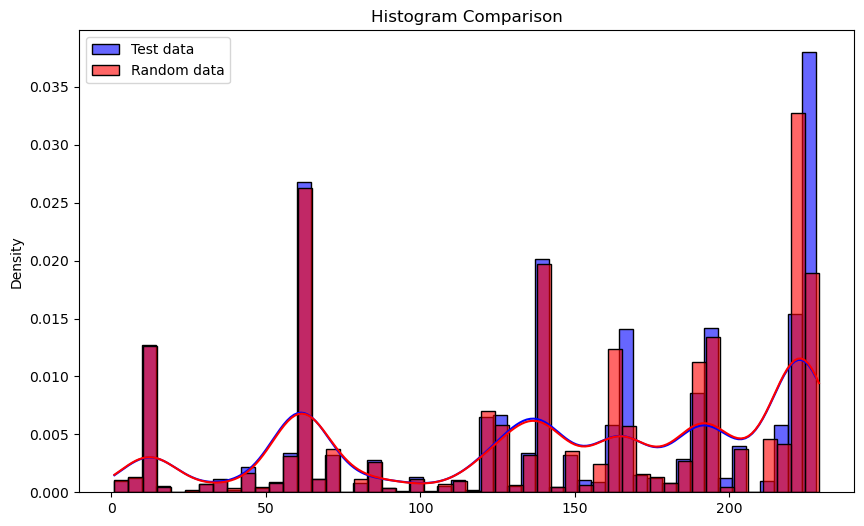

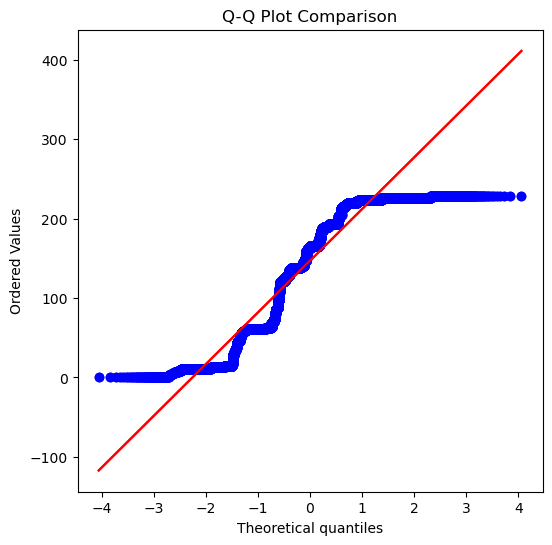

In [57]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

test_data = np.argmax(y_test_sg, axis=1)#abc_test[:,2]
vae_data = np.argmax(sg_ran, axis=1)#lattice_ran[:,2]
#test_data = abc_test[:,2]
#vae_data = lattice_ran[:,2]
#test_data = np.argmax(wyckoff_mult_test,axis=2).flatten()
#vae_data = np.argmax(wyckoff_multiplier_ran,axis=2).flatten()
#test_data = test_data[test_data != 0]
#vae_data = vae_data[vae_data != 0] 

# 1. Kolmogorov-Smirnov Test
ks_statistic, ks_p_value = stats.ks_2samp(test_data, vae_data)
print(f"Kolmogorov-Smirnov test: statistic={ks_statistic:.4f}, p-value={ks_p_value:.4f}")

# 2. Mann-Whitney U Test (non-parametric)
mw_statistic, mw_p_value = stats.mannwhitneyu(test_data, vae_data)
print(f"Mann-Whitney U test: statistic={mw_statistic:.4f}, p-value={mw_p_value:.4f}")

# 3. T-test for means
t_statistic, t_p_value = stats.ttest_ind(test_data, vae_data)
print(f"T-test: statistic={t_statistic:.4f}, p-value={t_p_value:.4f}")

# 4. F-test for variance (Levene's test)
levene_statistic, levene_p_value = stats.levene(test_data, vae_data)
print(f"Levene's test for equal variances: statistic={levene_statistic:.4f}, p-value={levene_p_value:.4f}")

# 5. Wasserstein Distance (Earth Mover's Distance)
wasserstein_dist = stats.wasserstein_distance(test_data, vae_data)
print(f"Wasserstein Distance: {wasserstein_dist:.4f}")

# 6. KL Divergence (requires probability distributions)
hist1, bin_edges1 = np.histogram(test_data, bins=50, density=True)
hist2, bin_edges2 = np.histogram(vae_data, bins=50, density=True)

kl_divergence = stats.entropy(hist1, hist2)
print(f"KL Divergence: {kl_divergence:.4f}")

# 7. Visualization

# Plot histograms
plt.figure(figsize=(10, 6))
sns.histplot(test_data, bins=50, kde=True, color='blue', label='Test data', stat="density", alpha=0.6)
sns.histplot(vae_data, bins=50, kde=True, color='red', label='Random data', stat="density", alpha=0.6)
plt.title("Histogram Comparison")
plt.legend()
plt.show()

# Q-Q Plot to compare distributions
plt.figure(figsize=(6, 6))
stats.probplot(test_data, dist="norm", plot=plt)
stats.probplot(vae_data, dist="norm", plot=plt)
plt.title("Q-Q Plot Comparison")
plt.show()

0/27739
500/27739
1000/27739
1500/27739
2000/27739
2500/27739
3000/27739
3500/27739
4000/27739
4500/27739
5000/27739
5500/27739
6000/27739
6500/27739
7000/27739
7500/27739
8000/27739
8500/27739
9000/27739
9500/27739
10000/27739
10500/27739
11000/27739
11500/27739
12000/27739
12500/27739
13000/27739
13500/27739
14000/27739
14500/27739
15000/27739
15500/27739
16000/27739
16500/27739
17000/27739
17500/27739
18000/27739
18500/27739
19000/27739
19500/27739
20000/27739
20500/27739
21000/27739
21500/27739
22000/27739
22500/27739
23000/27739
23500/27739
24000/27739
24500/27739
25000/27739
25500/27739
26000/27739
26500/27739
27000/27739
27500/27739
(102098,) (102098,)
0.9960136339595291


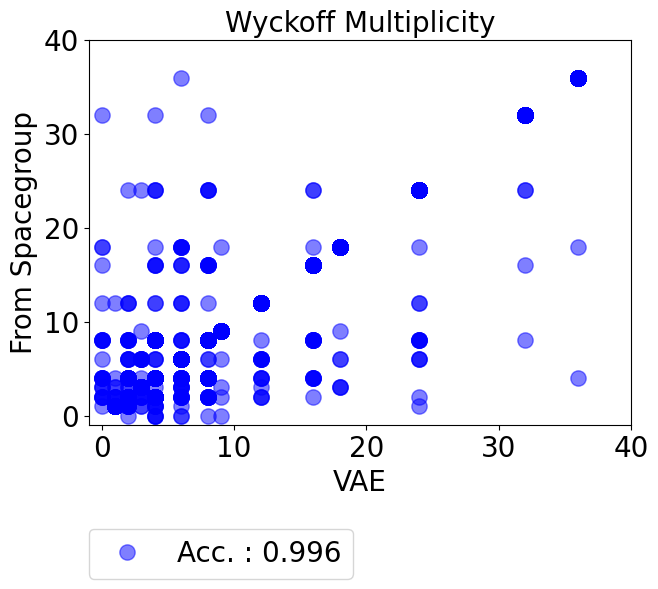

In [18]:
from pyxtal.symmetry import Group

tot_dict = save_dict_kde
vae_wyckoff_mult_plot = []
wyckoff_mult_from_letter = []

for i in range(element_test.shape[0]):
    if i % 500 == 0:
        print(f'{i}/{element_test.shape[0]}')
    # Use wyckoff letter and multiplier to remove zero padding¨
    wyckoff_letter_vae_i = np.argmax(tot_dict['wyckoff_letter'][i],axis=1)
    wyckoff_mult_vae_i = np.argmax(tot_dict['wyckoff_mult'][i],axis=1)
    spg_i = tot_dict['spacegroup'][i] + 1 
    #print(spg_i)

    # Find the zeros in the wyckoff letter and multiplier
    index = wyckoff_letter_vae_i != 0

    # Define wyckoff_letter and wyckoff multiplier
    wyckoff_letter_vae_i_str = np.array([chr(ord('a') + l-1) for l in wyckoff_letter_vae_i[index]]) # Convert to letter from number 
    wyckoff_mult_vae_i_reduced = wyckoff_mult_vae_i[index] # Add one to match the wyckoff multiplier 
    
    # Loop over the wyckoff sites and get the multiplicity from the letter
    for vae_mult, letter in zip(wyckoff_mult_vae_i_reduced,wyckoff_letter_vae_i_str):
        try:
            mult_i = Group(spg_i).get_wp_by_letter(letter).multiplicity
        except IndexError:
            mult_i = 0
        wyckoff_mult_from_letter.append(mult_i)
        vae_wyckoff_mult_plot.append(vae_mult)


fig, ax = plt.subplots(1, 1, figsize=(7, 5))
font_size = 20
marker = '.'
color = 'b'
alpha = 0.5
markersize= 22
acc_mult = accuracy_score(wyckoff_mult_from_letter, vae_wyckoff_mult_plot)
print(np.array(vae_wyckoff_mult_plot).shape,np.array(wyckoff_mult_from_letter).shape)
print(np.mean(np.array(wyckoff_mult_from_letter) == np.array(vae_wyckoff_mult_plot)))
#heatmap, xedges, yedges = np.histogram2d(vae_wyckoff_mult_plot, wyckoff_mult_from_letter, bins=Nbins)
#extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
#im = ax.imshow(heatmap.T, extent=extent, origin=origin,cmap=cmap,aspect=aspect)

ax.plot(vae_wyckoff_mult_plot, wyckoff_mult_from_letter, marker=marker, color=color,markersize=markersize,
        linestyle='None',label=f'Acc. : {acc_mult:.3f}',alpha=alpha)

ax.set_xlabel('VAE', fontsize=font_size)
ax.set_ylabel('From Spacegroup', fontsize=font_size)
ax.set_title('Wyckoff Multiplicity', fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
ax.tick_params(axis='both', which='minor', labelsize=font_size)
#ax.set_aspect('equal')
ax.legend(fontsize=font_size,loc=(-0,-0.4))
ax.set_xlim([-1,40])
ax.set_ylim([-1,40]);

### Traning validtion

In [118]:
df = pd.read_csv('Training_results.csv',delimiter=';',index_col=0)
#df = pd.read_csv('Occ_results.csv',delimiter=';',index_col=0)
df

,ICSD_occ0.0_dis_site,ICSD_occ0.01_dis_site,ICSD_occ0.02_dis_site,ICSD_occ0.05_dis_site
Epoch,1637.000,1086.000,1089.000,1081.000
occipation,0.000,0.010,0.020,0.050
a,0.060,0.060,0.070,0.070
b,0.060,0.060,0.080,0.080
c,0.100,0.110,0.110,0.110
alpha,0.020,0.020,0.020,0.030
beta,0.060,0.060,0.120,0.070
gamma,0.250,0.320,0.320,0.310
Disordered site,99.400,99.800,99.700,99.800
space group,99.800,99.300,99.100,98.900


In [56]:
df.iloc[2,:].name

'a'

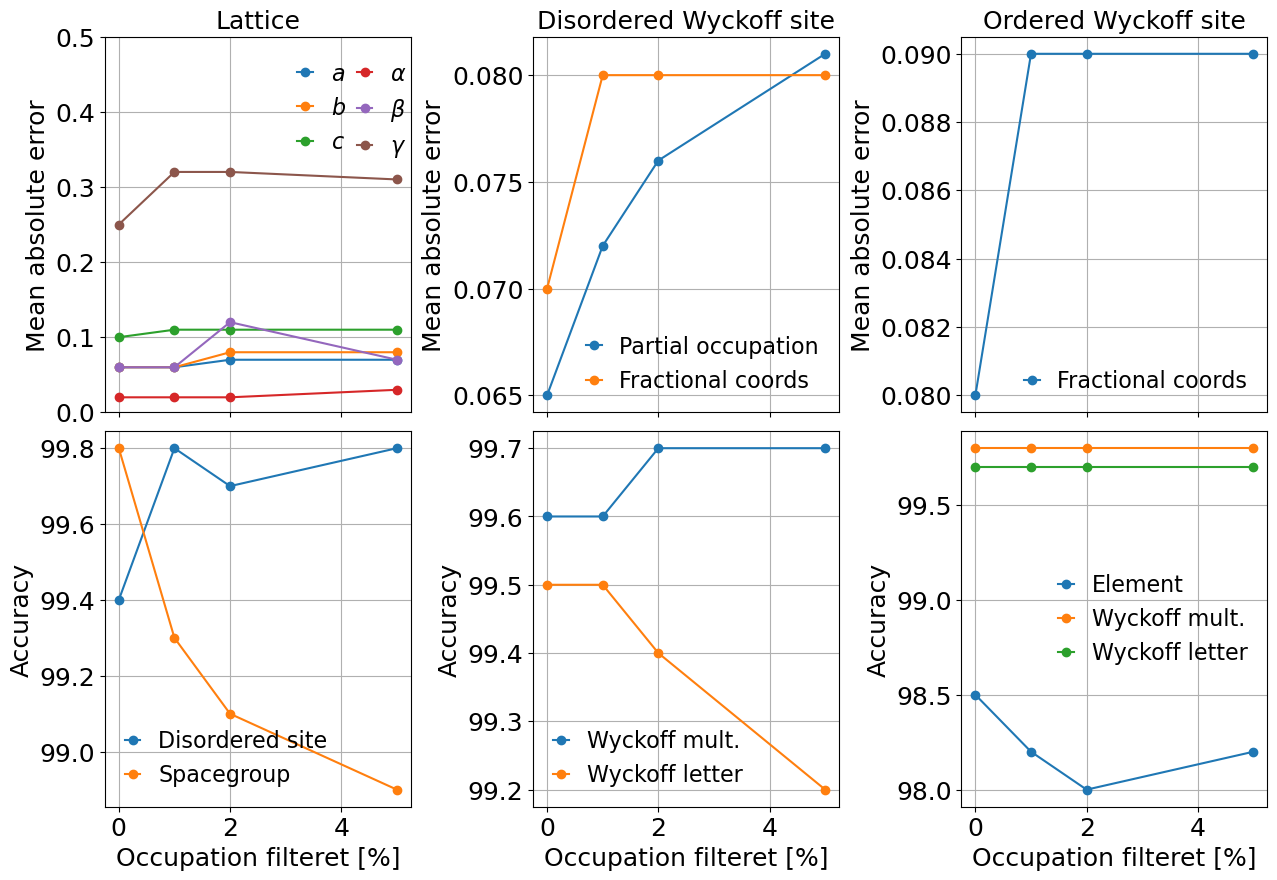

In [122]:
# plot the training results in 3 plots
fig, ax = plt.subplots(2, 3, figsize=(15, 10),gridspec_kw={'wspace':0.4,'hspace':0.05},sharex=True)
font_size = 18
handlelength = 0.7
col_length = 0.5
legend_loc = (0.6,0.65)

#x_name = 'training_set'
#xlabel = 'Procentage of training set [%]'
#x_plot = df.iloc[1,:].values*100

x_name = 'occipation'
xlabel = 'Occupation filteret [%]'
x_plot = df.iloc[1,:].values*100

# lattice
lattice_param = [2,3,4,5,6,7]
label_name = {'a':r'$a$', 'b':r'$b$', 'c':r'$c$', 'alpha':r'$\alpha$', 'beta':r'$\beta$', 'gamma':r'$\gamma$'}
for l in lattice_param:
    ax[0,0].plot(x_plot,df.iloc[l,:].values,marker='o',label=label_name[df.iloc[l,:].name])
ax[0,0].set_ylabel('Mean absolute error', fontsize=font_size)
ax[0,0].set_title('Lattice', fontsize=font_size)
ax[0,0].tick_params(axis='both', which='major', labelsize=font_size)
ax[0,0].tick_params(axis='both', which='minor', labelsize=font_size)
ax[0,0].legend(loc=legend_loc,fontsize=font_size-2,ncol=2,handlelength=handlelength,columnspacing=col_length,frameon=False)
ax[0,0].set_ylim([0,0.5])
ax[0,0].grid()

ax[1,0].plot(x_plot,df.iloc[8,:].values,marker='o',label='Disordered site')
ax[1,0].set_xlabel(xlabel, fontsize=font_size)
ax[1,0].plot(x_plot,df.iloc[9,:].values,marker='o',label='Spacegroup')
ax[1,0].set_ylabel('Accuracy', fontsize=font_size)
ax[1,0].set_xlabel(xlabel, fontsize=font_size)
ax[1,0].tick_params(axis='both', which='major', labelsize=font_size)
ax[1,0].tick_params(axis='both', which='minor', labelsize=font_size)
ax[1,0].legend(loc=0,fontsize=font_size-2,ncol=1,handlelength=handlelength,columnspacing=col_length,frameon=False)
#ax[1,0].set_ylim([0,1])
ax[1,0].grid()

# Disordered site
ax[0,1].plot(x_plot,df.iloc[10,:].values,marker='o',label='Partial occupation')
ax[0,1].plot(x_plot,df.iloc[13,:].values,marker='o',label='Fractional coords')
ax[0,1].set_ylabel('Mean absolute error', fontsize=font_size)
ax[0,1].set_title('Disordered Wyckoff site', fontsize=font_size)
ax[0,1].tick_params(axis='both', which='major', labelsize=font_size)
ax[0,1].tick_params(axis='both', which='minor', labelsize=font_size)
ax[0,1].legend(loc=0,fontsize=font_size-2,ncol=1,handlelength=handlelength,columnspacing=col_length,frameon=False)
ax[0,1].grid()

ax[1,1].plot(x_plot,df.iloc[11,:].values,marker='o',label='Wyckoff mult.')
ax[1,1].plot(x_plot,df.iloc[12,:].values,marker='o',label='Wyckoff letter')
ax[1,1].set_ylabel('Accuracy', fontsize=font_size)
ax[1,1].set_xlabel(xlabel, fontsize=font_size)
ax[1,1].tick_params(axis='both', which='major', labelsize=font_size)
ax[1,1].tick_params(axis='both', which='minor', labelsize=font_size)
ax[1,1].legend(loc=0,fontsize=font_size-2,ncol=1,handlelength=handlelength,columnspacing=col_length,frameon=False)
ax[1,1].grid()

# Ordered site

ax[0,2].plot(x_plot,df.iloc[17,:].values,marker='o',label='Fractional coords')
ax[0,2].set_ylabel('Mean absolute error', fontsize=font_size)
ax[0,2].set_title('Ordered Wyckoff site', fontsize=font_size)
ax[0,2].tick_params(axis='both', which='major', labelsize=font_size)
ax[0,2].tick_params(axis='both', which='minor', labelsize=font_size)
ax[0,2].legend(loc=0,fontsize=font_size-2,ncol=1,handlelength=handlelength,columnspacing=col_length,frameon=False)
ax[0,2].grid()

ax[1,2].plot(x_plot,df.iloc[14,:].values,marker='o',label='Element')
ax[1,2].plot(x_plot,df.iloc[15,:].values,marker='o',label='Wyckoff mult.')
ax[1,2].plot(x_plot,df.iloc[16,:].values,marker='o',label='Wyckoff letter')
ax[1,2].set_ylabel('Accuracy', fontsize=font_size)
ax[1,2].set_xlabel(xlabel, fontsize=font_size)
ax[1,2].tick_params(axis='both', which='major', labelsize=font_size)
ax[1,2].tick_params(axis='both', which='minor', labelsize=font_size)
ax[1,2].legend(loc=0,fontsize=font_size-2,ncol=1,handlelength=handlelength,columnspacing=col_length,frameon=False)
ax[1,2].grid()


### Reconstruction

In [19]:
import numpy as np
from pymatgen.core import Lattice, Structure
from pymatgen.symmetry.groups import SpaceGroup
from pymatgen.symmetry.structure import SymmetrizedStructure
from pymatgen.symmetry.analyzer import SpacegroupOperations
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.util.coord import in_coord_list
from ase.data import chemical_symbols

def structure_validity(crystal, cutoff=0.5):
    dist_mat = crystal.distance_matrix
    # Pad diagonal with a large number
    dist_mat = dist_mat + np.diag(
        np.ones(dist_mat.shape[0]) * (cutoff + 10.))
    if dist_mat.min() < cutoff or crystal.volume < 0.1:
        return False
    else:
        return True

def wyckoff_expand(w_site):
    mult_indexes = []
    letters = []
    index = 0
    
    for item in w_site:
        count = int(item[:-1])  # Extract number -> is this covering double digits
        label = item[-1]       # Extract label
        mult_indexes.extend([index] * count)
        letters.extend([label] * count)
        index += count
    
    return np.array(mult_indexes, dtype=np.int32), letters

def symm_structure_maker(structure, sg_number, equivalent_positions, wyckoff_letters,sym_tolernace):
    sym_ops = SpaceGroup.from_int_number(sg_number).symmetry_ops  
    full_coords = []
    full_species = []
    
    for site in structure.sites:
        for sym_op in sym_ops:
            transformed_coords = sym_op.operate(site.frac_coords) % 1  # bring back to unit cell
            species = site.species
            full_coords.append(transformed_coords)
            full_species.append(species)
    
    # Remove duplicates
    unique_coords = []
    unique_species = []
    tolerance = sym_tolernace
    for i, coord in enumerate(full_coords):
        if not in_coord_list(unique_coords, coord, atol=tolerance):
            unique_coords.append(coord)
            unique_species.append(full_species[i])

    full_structure = Structure(structure.lattice, unique_species, unique_coords)

    #spg = SpacegroupAnalyzer(full_structure,symprec=tolerance)
    #conventional_structure = spg.get_conventional_standard_structure()
    #symmetrized_structure = spg.get_symmetrized_structure()

    symm_struct = SymmetrizedStructure(
        structure=full_structure,
        spacegroup=SpacegroupOperations(SpaceGroup.from_int_number(sg_number).full_symbol, sg_number, sym_ops),
        equivalent_positions=equivalent_positions,
        wyckoff_letters=wyckoff_letters
    )
    
    if not structure_validity(symm_struct):
        raise ValueError("Invalid structure")
    
    if SpacegroupAnalyzer(symm_struct,symprec=tolerance).get_space_group_number() != sg_number:
        raise ValueError(f"Spacegroup mismatch: {sg_number} vs {SpacegroupAnalyzer(symm_struct).get_space_group_number()}")
    
    #print('Real:',sg_number,'Full:',SpacegroupAnalyzer(full_structure).get_space_group_number(),'Sym:',SpacegroupAnalyzer(symm_struct).get_space_group_number())


    #print(symm_struct)
    return symm_struct
    #return full_structure

def process_data_pkl(data_pkl, max_iter = None,element_acc = 0.01,disorder_acc = 0.1,sym_tolernace = 0.001):
    symm_structs = []
    not_symm_structs = []
    failed_count = 0  # Counter for failed items
    
    for i in range(len(data_pkl['abc'])):
        try:
            lattice = Lattice.from_parameters(
                a=data_pkl['abc'][i][0],
                b=data_pkl['abc'][i][1],
                c=data_pkl['abc'][i][2],
                alpha=data_pkl['angles'][i][0],
                beta=data_pkl['angles'][i][1],
                gamma=data_pkl['angles'][i][2]
            )
            
            index_max = np.argmax(data_pkl['wyckoff_letter'][i], axis=1)
            index = index_max != 0

            disordered_site = data_pkl['disordered_site'][i][index]
            disordered_site = disordered_site>disorder_acc
            disordered_site[~disordered_site] = 0
            disordered_site = disordered_site<disorder_acc
            disordered_site[~disordered_site] = 1
            disordered_site = disordered_site

            element_comb = []
            for site, a_list in enumerate(data_pkl['element'][i][index]):
                
                if disordered_site[site] == 1: # Disordered
                    element_index = np.where(a_list > element_acc)[0] + 1
                    disordered = True
                else: # Ordered
                    element_index = np.argmax(a_list) + 1
                    disordered = False
                
                if disordered:
                    disordered_element = {chemical_symbols[elem]: round(float(data_pkl['element'][i][site][elem - 1]),2) for elem in element_index}
                    element_comb.append(disordered_element)
                else:
                    element_comb.append({chemical_symbols[element_index]: 1.0})

            #element_index = [np.where(a_list > element_acc)[0] + 1 for a_list in data_pkl['element'][i][index]]
            #element_comb = [{chemical_symbols[elem]: round(float(data_pkl['element'][i][j][elem - 1]),5) for elem in elem_list} for j, elem_list in enumerate(element_index)]
            frac_coords = data_pkl['frac_coords'][i][index]
            
            structure = Structure(lattice, element_comb, frac_coords)
            not_symm_structs.append(structure)
            spacegroup_int = data_pkl['spacegroup'][i] +1
            
            w_letter = np.array([chr(ord('a') + l - 1) for l in np.argmax(data_pkl['wyckoff_letter'][i][index], axis=1) if l != 0])
            w_multiplier = np.array([m for m in np.argmax(data_pkl['wyckoff_mult'][i][index], axis=1) if m != 0])
            w_site = [str(w) + l for w, l in zip(w_multiplier, w_letter)]
            #print(element_comb)
            #print(w_site,spacegroup_int)


            mult_indexes, letters = wyckoff_expand(w_site)
            symm_struct = symm_structure_maker(structure, spacegroup_int, mult_indexes, letters,sym_tolernace)
            
            symm_structs.append(symm_struct)
            #print(f"Successfully processed index {i}. Total symm_structs: {len(symm_structs)}")
        except Exception as e:
            #print(f"Error processing index {i}: {e}")
            failed_count += 1  # Increment the failed counter
            
            
            # print(element_comb)
        if i % 1000 == 0:
            print(f"Processed index {i} out of {len(data_pkl['abc'])}")
            print(f"Total failed: {failed_count} out of {len(data_pkl['abc'])}")
        if max_iter is not None and i == max_iter:
            break
    return symm_structs
    #return not_symm_structs

mixiter = 1000
element_acc = 0.01  
disorder_acc = 0.1
sym_tolernace = 0.01


In [ ]:
element_kde,wyckoff_multiplier_kde,frac_coords_kde,wyckoff_letter_kde, sg_kde, lattice_kde,disordered_site_kde = decode_kde
lattice_kde = scaler_Y.inverse_transform(lattice_kde.detach().numpy())
save_dict_kde = {'abc':np.round(lattice_kde[:, :3],1),'angles':np.round(lattice_kde[:, 3:6],1),'spacegroup':np.argmax(sg_kde.detach().numpy(),axis=1),
                'disordered_site': F.sigmoid(torch.tensor(disordered_site_kde)).cpu().detach().numpy(),
                'element':element_kde.detach().numpy(),'wyckoff_letter':wyckoff_letter_kde.detach().numpy(),
                'wyckoff_mult':wyckoff_multiplier_kde.detach().numpy(),'frac_coords':frac_coords_kde.detach().numpy()}

struc_kde = process_data_pkl(save_dict_kde,max_iter=7000,
                             element_acc=0.01,disorder_acc=0.1,
                             sym_tolernace=0.01)

write_struc = True 
if write_struc:

    root_dir = 'kde_sym_validity'
    if not os.path.exists(root_dir):
        os.makedirs(root_dir)

    for i,test in enumerate(struc_kde):
        filename = f'kde_{i}_spg{test.spacegroup.int_number}_{test.reduced_formula}.cif'
        
        writer = CifWriter(test,symprec=0.01)
        writer.write_file(test)
        #test.to(fmt='cif',filename=os.path.join(root_dir,filename))

Processed index 0 out of 27739
Total failed: 1 out of 27739
Processed index 1000 out of 27739
Total failed: 980 out of 27739


In [32]:
def structure_validity(crystal, cutoff=0.1):
    dist_mat = crystal.distance_matrix
    # Pad diagonal with a large number
    dist_mat = dist_mat + np.diag(
        np.ones(dist_mat.shape[0]) * (cutoff + 10.))
    if dist_mat.min() < cutoff or crystal.volume < 0.1:
        return False
    else:
        return True
struc_vae_vallidity = [ crystal for crystal in struc_vae if structure_validity(crystal)]
print('VAE')
print(f'{len(struc_vae_vallidity)}/{len(struc_vae)}')
print('GMM')
struc_gmm_vallidity = [ crystal for crystal in struc_gmm if structure_validity(crystal)]
print(f'{len(struc_gmm_vallidity)}/{len(struc_gmm)}')
print('KDE')
struc_kde_vallidity = [ crystal for crystal in struc_kde if structure_validity(crystal)]
print(f'{len(struc_kde_vallidity)}/{len(struc_kde)}')
print('Random')
struc_ran_vallidity = [ crystal for crystal in struc_ran if structure_validity(crystal)]
print(f'{len(struc_ran_vallidity)}/{len(struc_ran)}')

VAE
515/1001
GMM
801/977
KDE
553/1000
Random
612/910


In [23]:

print('KDE')
struc_kde = process_data_pkl(save_dict_kde,max_iter=mixiter,element_acc=element_acc,disorder_acc=disorder_acc,sym_tolernace=sym_tolernace)
struc_kde_vallidity = [ crystal for crystal in struc_kde if structure_validity(crystal)]
print(f'{len(struc_kde_vallidity)}/{len(struc_kde)}')

print('GMM')
struc_gmm = process_data_pkl(save_dict_gmm,max_iter=mixiter,element_acc=element_acc,disorder_acc=disorder_acc,sym_tolernace=sym_tolernace)
struc_gmm_vallidity = [ crystal for crystal in struc_gmm if structure_validity(crystal)]
print(f'{len(struc_gmm_vallidity)}/{len(struc_gmm)}')

print('Random')
struc_ran = process_data_pkl(save_dict_ran,max_iter=mixiter,element_acc=element_acc,disorder_acc=disorder_acc,sym_tolernace=sym_tolernace)
struc_ran_vallidity = [ crystal for crystal in struc_ran if structure_validity(crystal)]
print(f'{len(struc_ran_vallidity)}/{len(struc_ran)}')

print('VAE')
struc_vae = process_data_pkl(save_dict_vae,max_iter=mixiter,element_acc=element_acc,disorder_acc=disorder_acc,sym_tolernace=sym_tolernace)
struc_vae_vallidity = [ crystal for crystal in struc_vae if structure_validity(crystal)]
print(f'{len(struc_vae_vallidity)}/{len(struc_vae)}')



KDE
Processed index 0 out of 27739
Total failed: 0 out of 27739
Processed index 1000 out of 27739
Total failed: 1 out of 27739
164/1000
GMM
Processed index 0 out of 27739
Total failed: 0 out of 27739
Processed index 1000 out of 27739
Total failed: 24 out of 27739
147/977
Random
Processed index 0 out of 27739
Total failed: 0 out of 27739
Processed index 1000 out of 27739
Total failed: 91 out of 27739
118/910
VAE
Processed index 0 out of 27739
Total failed: 0 out of 27739
Processed index 1000 out of 27739
Total failed: 0 out of 27739
146/1001


In [24]:
struc_ran_vallidity = []
for crystal in struc_ran:
    try:
        if structure_validity(crystal):
            struc_ran_vallidity.append(crystal)
    except:
        continue
print(f'{len(struc_ran_vallidity)}/{len(struc_ran)}')


Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
128/914


In [23]:
element_kde,wyckoff_multiplier_kde,frac_coords_kde,wyckoff_letter_kde, sg_kde, lattice_kde,disordered_site_kde = decode_kde
lattice_kde = scaler_Y.inverse_transform(lattice_kde.detach().numpy())
save_dict_kde = {'abc':np.round(lattice_kde[:, :3],1),'angles':np.round(lattice_kde[:, 3:6],1),'spacegroup':np.argmax(sg_kde.detach().numpy(),axis=1),
                'disordered_site': F.sigmoid(torch.tensor(disordered_site_kde)).cpu().detach().numpy(),
                'element':element_kde.detach().numpy(),'wyckoff_letter':wyckoff_letter_kde.detach().numpy(),
                'wyckoff_mult':wyckoff_multiplier_kde.detach().numpy(),'frac_coords':frac_coords_kde.detach().numpy()}

struc_kde = process_data_pkl(save_dict_kde,max_iter=2000,
                             element_acc=0.01,disorder_acc=0.1,
                             sym_tolernace=0.01)
spg_list = []
for test in struc_kde:
    try:
        spg_list.append(test.get_space_group_info()[1])
    except:
        spg_list.append(0)
print(spg_list)

Processed index 0 out of 27739
Total failed: 0 out of 27739
Processed index 1000 out of 27739
Total failed: 813 out of 27739
Processed index 2000 out of 27739
Total failed: 1642 out of 27739
[3, 2, 62, 62, 2, 62, 11, 10, 14, 19, 14, 2, 12, 14, 62, 62, 18, 14, 2, 19, 1, 14, 2, 16, 5, 3, 3, 5, 14, 2, 62, 14, 2, 5, 2, 62, 5, 2, 1, 43, 62, 2, 60, 19, 14, 14, 11, 2, 11, 19, 4, 1, 5, 15, 12, 19, 57, 14, 18, 19, 5, 62, 2, 15, 2, 1, 14, 2, 1, 62, 15, 1, 4, 2, 12, 5, 2, 5, 2, 15, 13, 14, 19, 15, 2, 2, 2, 2, 62, 19, 2, 4, 58, 19, 2, 5, 1, 4, 5, 4, 2, 5, 11, 2, 19, 43, 15, 4, 33, 48, 14, 4, 61, 4, 15, 1, 13, 6, 2, 15, 14, 14, 1, 14, 4, 19, 5, 14, 2, 15, 14, 43, 4, 15, 1, 1, 2, 14, 5, 2, 15, 2, 2, 12, 2, 4, 73, 4, 15, 5, 2, 2, 62, 5, 58, 2, 12, 56, 2, 14, 2, 14, 2, 2, 19, 1, 5, 2, 33, 16, 9, 2, 43, 1, 2, 43, 2, 4, 4, 2, 2, 61, 12, 2, 16, 2, 18, 2, 62, 1, 62, 43, 2, 12, 14, 21, 2, 2, 62, 62, 3, 12, 15, 2, 4, 14, 16, 19, 14, 2, 2, 2, 15, 62, 1, 14, 2, 2, 14, 2, 2, 2, 53, 2, 2, 1, 19, 2, 1, 14, 14, 2

In [ ]:
def structure_validity(crystal, cutoff=0.5):
    dist_mat = crystal.distance_matrix
    # Pad diagonal with a large number
    dist_mat = dist_mat + np.diag(
        np.ones(dist_mat.shape[0]) * (cutoff + 10.))
    if dist_mat.min() < cutoff or crystal.volume < 0.1:
        return False
    else:
        return True

struc_kde_vallidity = [ crystal for crystal in struc_kde if structure_validity(crystal)]
print(f'{len(struc_kde_vallidity)}/{len(struc_kde)}')


write_struc = True 
if write_struc:

    root_dir = 'kde_cifs_vallidity'
    if not os.path.exists(root_dir):
        os.makedirs(root_dir)

    for i,test in enumerate(struc_kde_vallidity):
        filename = f'kde_{i}_spg{test.spacegroup.int_number}_{test.reduced_formula}.cif'
        
        writer = CifWriter(test,symprec=0.01)
        writer.write_file(test)
        #test.to(fmt='cif',filename=os.path.join(root_dir,filename))


359/359


In [16]:
test = struc_kde_vallidity[0]
test

Structure Summary
Lattice
    abc : 8.199999809265144 8.100000381469735 8.600000381469727
 angles : 90.00000250447799 90.00000250447802 87.19999385201697
 volume : 570.5300872343178
      A : 8.199999809265137 0.0 -3.5843336831931083e-07
      B : 0.39568402209217585 8.090330051022065 -3.5406225151746185e-07
      C : 0.0 0.0 8.600000381469727
    pbc : True True True
PeriodicSite: Be (7.419, 7.014, 3.85) [0.863, 0.867, 0.4476]
PeriodicSite: Be (3.261, 5.154, 0.4505) [0.367, 0.637, 0.05238]
PeriodicSite: Be (1.467, 7.014, 4.75) [0.137, 0.867, 0.5524]
PeriodicSite: Be (0.68, 5.122, 3.122) [0.05238, 0.633, 0.363]
PeriodicSite: Be (1.31, 4.469, 7.422) [0.133, 0.5524, 0.863]
PeriodicSite: Be (7.916, 2.969, 3.122) [0.9476, 0.367, 0.363]
PeriodicSite: Be (7.328, 4.469, 1.178) [0.867, 0.5524, 0.137]
PeriodicSite: Be (1.268, 3.621, 1.178) [0.133, 0.4476, 0.137]
PeriodicSite: Be (0.5747, 2.969, 5.478) [0.05238, 0.367, 0.637]
PeriodicSite: Be (7.286, 3.621, 7.422) [0.867, 0.4476, 0.863]
Periodic

In [22]:
from chgnet.model import StructOptimizer

relaxer = StructOptimizer()
result = relaxer.relax(test, fmax=0.1, relax_cell=True, steps=100,)
print("CHGNet relaxed structure", result["final_structure"])
print("relaxed total energy in eV:", result['trajectory'].energies[-1])

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cpu
      Step     Time          Energy          fmax
FIRE:    0 17:10:40      674.454174      341.415350
FIRE:    1 17:10:43      404.296818      282.556692
FIRE:    2 17:10:47      390.811558      157.541162
FIRE:    3 17:10:50      247.678814      165.640866
FIRE:    4 17:10:54       90.909519      175.044976
FIRE:    5 17:10:57      -18.510075      246.260082
FIRE:    6 17:11:01      -83.763885      106.551442
FIRE:    7 17:11:05     -127.038517       62.351501
FIRE:    8 17:11:08     -194.524269       57.731534
FIRE:    9 17:11:12     -266.560192      588.511080
FIRE:   10 17:11:16     -298.180962      190.042752
FIRE:   11 17:11:20     -318.089476      192.987681
FIRE:   12 17:11:23     -435.286331      233.293226
FIRE:   13 17:11:27     -424.325409      231.933145
FIRE:   14 17:11:31     -399.614296      693.558844
FIRE:   15 17:11:35     -443.579378      325.888665
FIRE:   16 17:11:39     -429.549894      169.

KeyboardInterrupt: 

In [16]:
# Load the model
from chgnet.model.dynamics import CHGNetCalculator
from chgnet.model import CHGNet
print('Using CHGNET model')
model = CHGNet.load()
device = 'cpu'
model.to(device)


Using CHGNET model
CHGNet v0.3.0 initialized with 412,525 parameters


CHGNet(
  (composition_model): AtomRef(
    (fc): Linear(in_features=94, out_features=1, bias=False)
  )
  (graph_converter): CrystalGraphConverter(algorithm='fast', atom_graph_cutoff=6, bond_graph_cutoff=3)
  (atom_embedding): AtomEmbedding(
    (embedding): Embedding(94, 64)
  )
  (bond_basis_expansion): BondEncoder(
    (rbf_expansion_ag): RadialBessel(
      (smooth_cutoff): CutoffPolynomial()
    )
    (rbf_expansion_bg): RadialBessel(
      (smooth_cutoff): CutoffPolynomial()
    )
  )
  (bond_embedding): Linear(in_features=31, out_features=64, bias=False)
  (bond_weights_ag): Linear(in_features=31, out_features=64, bias=False)
  (bond_weights_bg): Linear(in_features=31, out_features=64, bias=False)
  (angle_basis_expansion): AngleEncoder(
    (fourier_expansion): Fourier()
  )
  (angle_embedding): Linear(in_features=31, out_features=64, bias=False)
  (atom_conv_layers): ModuleList(
    (0-3): 4 x AtomConv(
      (activation): SiLU()
      (twoBody_atom): GatedMLP(
        (mlp_c

In [76]:
with open('struc_kde.pkl', 'wb') as f:
    pickle.dump(save_dict_kde, f)

In [87]:
root_dir = 'kde_cifs_sym'
if not os.path.exists(root_dir):
    os.makedirs(root_dir)

for i,test in enumerate(struc_kde):
    filename = f'kde_{i}_spg{test.spacegroup.int_number}_{test.reduced_formula}.cif'
    test.to(fmt='cif',filename=os.path.join(root_dir,filename))

In [25]:
from pymatgen.io.cif import CifWriter

idx = 12
print('abc:',save_dict_kde['abc'][idx])
print('angles:',save_dict_kde['angles'][idx])
test = struc_kde[idx]
test.to(fmt='cif',filename='test.cif')
#CifWriter(test,symprec=0.01).write_file('test_sym.cif')
test

abc: [3.6629267 3.7578514 3.7746341]
angles: [89.9965  89.99713 83.56071]


SymmetrizedStructure
Full Formula (Er18 Ir24)
Reduced Formula: Er3Ir4
Spacegroup: P4/m-32/m (221)
abc   :   3.662927   3.757851   3.774634
angles:  89.996499  89.997134  83.560705
Sites (42)
  #  SP           a         b         c  Wyckoff
---  ----  --------  --------  --------  ---------
  0  Er    0.985914  0.999148  0.995662  1a
  1  Er    0.000852  0.014086  0.004338  1b

In [173]:
sym_test = SpacegroupAnalyzer(struc_kde[idx],symprec=0.001)
sym_test.get_space_group_number(), struc_kde[idx].get_space_group_info()

(11, ('P2_1/m', 11))

In [127]:
sym_test = SpacegroupAnalyzer(struc_kde[idx],symprec=0.01)
sym_test.get_space_group_number()
sym_test = sym_test.get_symmetrized_structure()
sym_test.to(fmt='cif',filename='test.cif')
sym_test

SymmetrizedStructure
Full Formula (Sr191.616 Mn27.096 Fe0.432 Mo93.264 O192)
Reduced Formula: Sr191.616Mn27.096Fe0.432Mo93.264O192
Spacegroup: P1 (1)
abc   :   8.640010   7.841029   8.173285
angles:  90.001539  89.984259  87.152039
Sites (507)
  #  SP                                   a         b         c  Wyckoff
---  ----------------------------  --------  --------  --------  ---------
  0  Sr:0.998                      0.714928  0.743117  0.587433  1a
  1  Sr:0.998                      0.256883  0.285072  0.412567  1a
  2  Sr:0.998                      0.714928  0.256883  0.412567  1a
  3  Sr:0.998                      0.743117  0.714928  0.412567  1a
  4  Sr:0.998                      0.285072  0.743117  0.412567  1a
  5  Sr:0.998                      0.587433  0.256883  0.714928  1a
  6  Sr:0.998                      0.587433  0.743117  0.285072  1a
  7  Sr:0.998                      0.256883  0.714928  0.412567  1a
  8  Sr:0.998                      0.285072  0.256883  0.412567 

In [97]:
test = struc_kde[idx]
test

SymmetrizedStructure
Full Formula (Sr191.616 Mn27.096 Fe0.432 Mo93.264 O192)
Reduced Formula: Sr191.616Mn27.096Fe0.432Mo93.264O192
Spacegroup: F4/m-32/m (225)
abc   :   8.640010   7.841029   8.173285
angles:  90.001539  89.984259  87.152039
Sites (507)
  #  SP               a         b         c  Wyckoff
---  --------  --------  --------  --------  ---------
  0  Sr:0.998  0.714928  0.743117  0.587433  8c
  1  Sr:0.998  0.285072  0.256883  0.412567  4a
  2  Sr:0.998  0.587433  0.285072  0.743117  4b
  3  Sr:0.998  0.714928  0.412567  0.256883  24e

In [99]:
test.to('test_sym.cif',fmt='cif')

"# generated using pymatgen\ndata_Sr191.616Mn27.096Fe0.432Mo93.264O192\n_symmetry_space_group_name_H-M   'P 1'\n_cell_length_a   8.64001021\n_cell_length_b   7.84102869\n_cell_length_c   8.17328548\n_cell_angle_alpha   90.00153930\n_cell_angle_beta   89.98425892\n_cell_angle_gamma   87.15203902\n_symmetry_Int_Tables_number   1\n_chemical_formula_structural   Sr191.616Mn27.096Fe0.432Mo93.264O192\n_chemical_formula_sum   'Sr191.616 Mn27.096 Fe0.432 Mo93.264 O192'\n_cell_volume   553.02812726\n_cell_formula_units_Z   1\nloop_\n _symmetry_equiv_pos_site_id\n _symmetry_equiv_pos_as_xyz\n  1  'x, y, z'\nloop_\n _atom_site_type_symbol\n _atom_site_label\n _atom_site_symmetry_multiplicity\n _atom_site_fract_x\n _atom_site_fract_y\n _atom_site_fract_z\n _atom_site_occupancy\n  Sr  Sr0  1  0.71492767  0.74311692  0.58743325  0.998\n  Sr  Sr1  1  0.25688308  0.28507233  0.41256675  0.998\n  Sr  Sr2  1  0.71492767  0.25688308  0.41256675  0.998\n  Sr  Sr3  1  0.74311692  0.71492767  0.41256675  0.

In [190]:
struc_kde[0]

SymmetrizedStructure
Full Formula (U8 Al7.848 Fe0.128 Au8)
Reduced Formula: U8Al7.848Fe0.128Au8
Spacegroup: P2_1/n2_1/m2_1/a (62)
abc   :   7.122351   7.184401   5.410800
angles:  90.001901  89.990276  88.555704
Sites (24)
  #  SP                         a         b         c  Wyckoff
---  ------------------  --------  --------  --------  ---------
  0  U                   0.53611   0.645349  0.231992  4c
  1  U                   0.46389   0.145349  0.768008  4c
  2  Al:0.981, Fe:0.016  0.338635  0.602603  0.935766  8d

In [16]:
from pymatgen.io.cif import CifWriter

root_dir = 'kde_cifs'
if not os.path.exists(root_dir):
    os.makedirs(root_dir)

for k, symm_struc in enumerate(struc_kde):
    # Save to cif
    filename = f"{root_dir}/kde_{k}_{symm_struc.formula}.cif"
    writer = CifWriter(symm_struc,symprec=0.01)
    writer.write_file(filename)
    print(symm_struc)

SymmetrizedStructure
Full Formula (Tb8 F15.992)
Reduced Formula: Tb8F15.992
Spacegroup: P2_1/n2_1/m2_1/a (62)
abc   :   6.205406   7.758111   4.951168
angles:  89.997960  89.999559  88.073363
Sites (24)
  #  SP              a         b         c  Wyckoff
---  -------  --------  --------  --------  ---------
  0  Tb       0.233432  0.732115  0.626622  4c
  1  Tb       0.766568  0.232115  0.373378  4c
  2  F:0.999  0.867877  0.711585  0.306594  8d
SymmetrizedStructure
Full Formula (Cu3.86 Te4 O12)
Reduced Formula: Cu3.86Te4O12
Spacegroup: P12_1/c1 (14)
abc   :   9.700598   5.247536   3.933088
angles:  89.998193  98.065739  88.094899
Sites (20)
  #  SP               a         b         c  Wyckoff
---  --------  --------  --------  --------  ---------
  0  Cu:0.965  0.74313   0.297215  0.837541  4e
  1  Te        0.066403  0.924667  0.974942  2a
  2  Te        0.933597  0.424667  0.525058  4e
  3  O         0.585682  0.168174  0.369768  4e
  4  O         0.348562  0.153188  0.123237  4e
Sy

SymmetryUndeterminedError: 

In [17]:
max_iter = 1000
print('KDE data')
struc_kde = process_data_pkl(save_dict_kde,max_iter=max_iter)
print('---------------------------------')
print('GMM data')
struc_gmm = process_data_pkl(save_dict_gmm,max_iter=max_iter)
print('---------------------------------')
print('Random data')
struc_ran = process_data_pkl(save_dict_ran,max_iter=max_iter)
print('---------------------------------')
print('VAE data')
struc_vae = process_data_pkl(save_dict_vae,max_iter=max_iter)

KDE data
Processed index 0 out of 27739
Total failed: 0 out of 27739
Error processing index 129: list index out of range
Error processing index 653: list index out of range
Error processing index 692: list index out of range
Processed index 1000 out of 27739
Total failed: 3 out of 27739
---------------------------------
GMM data
Processed index 0 out of 27739
Total failed: 0 out of 27739
Error processing index 9: list index out of range
Error processing index 43: list index out of range
Error processing index 44: list index out of range
Error processing index 53: list index out of range
Error processing index 59: list index out of range
Error processing index 67: list index out of range
Error processing index 71: list index out of range
Error processing index 76: list index out of range
Error processing index 110: list index out of range
Error processing index 117: list index out of range
Error processing index 124: list index out of range
Error processing index 156: list index out of 

In [73]:
## TESTING THE CODE WITH THE TEST SET
def process_data_pkl(data_pkl,max_iter=None):
    symm_structs = []
    failed_count = 0  # Counter for failed items
    
    for i in range(len(data_pkl['abc'])):
        lattice = Lattice.from_parameters(
            a=data_pkl['abc'][i][0],
            b=data_pkl['abc'][i][1],
            c=data_pkl['abc'][i][2],
            alpha=np.round(data_pkl['angles'][i][0],2),
            beta=np.round(data_pkl['angles'][i][1],2),
            gamma=np.round(data_pkl['angles'][i][2],2)
        )
        
        index_max = np.argmax(data_pkl['wyckoff_letter'][i], axis=1)
        index = index_max != 0

        element_acc = 0.01
        disordered_site = data_pkl['disordered_site'][i][index]
        element_comb = []
        for site, a_list in enumerate(data_pkl['element'][i][index]):
            
            if disordered_site[site] == 1: # Disordered
                element_index = np.where(a_list > element_acc)[0] + 1
                disordered = True
            else: # Ordered
                element_index = np.argmax(a_list) + 1
                disordered = False
            
            if disordered:
                disordered_element = {chemical_symbols[elem]: round(float(data_pkl['element'][i][site][elem - 1]),5) for elem in element_index}
                element_comb.append(disordered_element)
            else:
                element_comb.append({chemical_symbols[element_index]: 1.0})


        #element_index = [np.where(a_list > element_acc)[0] + 1 for a_list in data_pkl['element'][i][index]]
        #element_comb = [{chemical_symbols[elem]: round(float(data_pkl['element'][i][j][elem - 1]),5) for elem in elem_list} for j, elem_list in enumerate(element_index)]
        frac_coords = data_pkl['frac_coords'][i][index]
        
        structure = Structure(lattice, element_comb, frac_coords)
        print(structure)
        spacegroup_int = data_pkl['spacegroup'][i] +1 # Because the spacegroup is 0 index
        
        w_letter = np.array([chr(ord('a') + l - 1) for l in np.argmax(data_pkl['wyckoff_letter'][i][index], axis=1) if l != 0])
        w_multiplier = np.array([m for m in np.argmax(data_pkl['wyckoff_mult'][i][index], axis=1) if m != 0])
        w_site = [str(w) + l for w, l in zip(w_multiplier, w_letter)]
        print(w_site,spacegroup_int,i)
        
        mult_indexes, letters = wyckoff_expand(w_site)
        symm_struct = symm_structure_maker(structure, spacegroup_int, mult_indexes, letters)
        
        symm_structs.append(symm_struct)
        print(f"Successfully processed index {i}. Total symm_structs: {len(symm_structs)}")
        # print(element_comb)
        print(f"Total failed: {failed_count} out of {len(data_pkl['abc'])}")
        if max_iter is not None and i == max_iter:
            break
    return symm_structs

test_struc = process_data_pkl(save_dict_test,max_iter=1000)

Full Formula (Md1 Zn0.51 Ga0.49 N0.49 O0.51)
Reduced Formula: Md1Zn0.51Ga0.49N0.49O0.51
abc   :   1.226841   1.175043   0.680754
angles:   0.050000   0.140000   0.190000
pbc   :       True       True       True
Sites (3)
  #  SP                       a         b        c
---  ----------------  --------  --------  -------
  0  Md:0.49, Zn:0.51  0.666667  0.333333  0.90188
  1  Md:0.51, Ga:0.49  0.666667  0.333333  0.87912
  2  N:0.49, O:0.51    0.666667  0.333333  0.50066
['2b', '2b', '2b'] 186 0
Successfully processed index 0. Total symm_structs: 1
Total failed: 0 out of 27739
Full Formula (Tb1 Al0.11 Fe0.89 O2)
Reduced Formula: Tb1Al0.11Fe0.89O2
abc   :   0.412253   0.347892   0.160691
angles:   0.050000   0.140000   0.190000
pbc   :       True       True       True
Sites (4)
  #  SP                     a     b      c
---  ----------------  ------  ----  -----
  0  Tb                0.5632  0.25  0.519
  1  Al:0.11, Fe:0.89  0.5     0     0
  2  O                 0.964   0.25  0.402
 

KeyboardInterrupt: 

In [68]:
wyckoff_dict[15692]

{0: {'wyckoff': '6b',
  'species': {'Mg': 1.0},
  'frac_coords': array([0.33333333, 0.66666667, 0.16666667]),
  'Z_species': array([12]),
  'charge_disorder': False},
 1: {'wyckoff': '6a',
  'species': {'C': 1.0},
  'frac_coords': array([0.  , 0.  , 0.25]),
  'Z_species': array([6]),
  'charge_disorder': False},
 2: {'wyckoff': '18e',
  'species': {'O': 1.0},
  'frac_coords': array([0.2778, 0.    , 0.25  ]),
  'Z_species': array([8]),
  'charge_disorder': False}}

In [56]:
X_idx = np.arange(0,len(X),1)
Y_idx = np.arange(0,len(Y),1)

In [58]:
idx_train_val,idx_test,idy_train_val,idy_test=train_test_split(  X_idx,Y_idx,test_size=test_size,random_state=42)
idx_train,idx_val,idy_train,idy_val = train_test_split(idx_train_val,idy_train_val,test_size=val_size,random_state=42)

In [67]:
idx_test[62]

15692

In [64]:
Group(166)


-- Spacegroup --# 166 (R-3m)--
36i	site symm: 1
18h	site symm: .m
18g	site symm: 1
18f	site symm: 1
9e	site symm: -1
9d	site symm: -1
6c	site symm: 3m
3b	site symm: -32/m
3a	site symm: -32/m

In [48]:
save_dict_test = {'abc':y_test_plot[:, :3],
             'angles':y_test_plot[:, 3:6],
            'spacegroup':np.argmax(y_test_plot[:, 6:], axis=1),
            'disordered_site':x_test_plot[:,:, -31],
            'element':x_test_plot[:,:, :101],
            'wyckoff_letter':x_test_plot[:,:, -27:],
            'wyckoff_mult':x_test_plot[:,:, 101:-31],
            'frac_coords':x_test_plot[:,:, -30:-27],
             }

In [45]:
save_dict_vae['spacegroup'][5], spacegroup_test[5]

(220, 220)

In [ ]:
wyckoff_dict_i = wyckoff_dict[:10]
spg_i = space_group[:10]
print_value_i = print_value[:10]
crystal_feat_i = crystal_feat[:10]

save_dict = {'abc':crystal_feat_i[:, :3],
             'angles':crystal_feat_i[:, 3:6],
            'spacegroup':spg_i,
            'disordered_site':print_value_i[:,:, -31],
            'element':print_value_i[:,:, :101],
            'wyckoff_letter':print_value_i[:,:, -27:],
            'wyckoff_mult':print_value_i[:,:, 101:-31],
            'frac_coords':print_value_i[:,:, -30:-27],
             }

In [182]:
p_test = Structure.from_file('LaO_Quaternary/La-O_Quaternary_CollCode75457.cif')
p_test

Structure Summary
Lattice
    abc : 22.3095 5.6975 5.6936
 angles : 90.0 90.0 90.0
 volume : 723.7042510169999
      A : 22.3095 0.0 1.3660628882788939e-15
      B : -3.488712569071022e-16 5.6975 3.488712569071022e-16
      C : 0.0 0.0 5.6936
    pbc : True True True
PeriodicSite: Rb1 (Rb+:0.945) (15.44, 1.36, 1.423) [0.692, 0.2387, 0.25]
PeriodicSite: Rb1 (Rb+:0.945) (15.44, 4.338, 4.27) [0.692, 0.7613, 0.75]
PeriodicSite: Rb1 (Rb+:0.945) (6.872, 4.338, 4.27) [0.308, 0.7613, 0.75]
PeriodicSite: Rb1 (Rb+:0.945) (6.872, 1.36, 1.423) [0.308, 0.2387, 0.25]
PeriodicSite: Rb1 (Rb+:0.945) (4.283, 4.209, 1.423) [0.192, 0.7387, 0.25]
PeriodicSite: Rb1 (Rb+:0.945) (4.283, 1.489, 4.27) [0.192, 0.2613, 0.75]
PeriodicSite: Rb1 (Rb+:0.945) (18.03, 1.489, 4.27) [0.808, 0.2613, 0.75]
PeriodicSite: Rb1 (Rb+:0.945) (18.03, 4.209, 1.423) [0.808, 0.7387, 0.25]
PeriodicSite: La1 (La3+) (-2.581e-16, 4.214, 1.423) [0.0, 0.7397, 0.25]
PeriodicSite: La1 (La3+) (-9.081e-17, 1.483, 4.27) [0.0, 0.2603, 0.75]
Per

### OLD CODE

In [ ]:
abc_test = y_test_lattice[:, :3]
angles_test = y_test_lattice[:, 3:6]
spacegroup_test = np.argmax(y_test_sg, axis=1)
disordered_site_test = x_test_plot[:,:,-31].flatten()
element_test = x_test_plot[:,:,:101]
frac_coords_test = x_test_plot[:,:,-30:-27]
wyckoff_letter_test = x_test_plot[:,:,-27:]
wyckoff_mult_test = x_test_plot[:,:,101:-31]

save_dict =  {'abc':abc_test,
              'angles':angles_test,
              'spacegroup':spacegroup_test,
              'disordered_site':disordered_site_test,
              'element':element_test,
              'wyckoff_letter':wyckoff_letter_test,
              'wyckoff_mult':wyckoff_mult_test,
              'frac_coords':frac_coords_test,
              'vae_wyckoff_mult':vae_wyckoff_mult_plot,
              'wyckoff_mult_from_letter':wyckoff_mult_from_letter,
              'total_structures':len(element_test)}

with open('test_rep.pkl', 'wb') as f:
    pickle.dump(save_dict, f)

with open('test_rep.pkl', 'rb') as f:
    data = pickle.load(f)

In [21]:
def symm_structure_maker(structure, sg_number, equivalent_positions, wyckoff_letters):
    """make a full symmetrized structure from a structure (inequivalent sites), spacegroup number, equivalent sites and wyckoff letters
    equivalent sites = np.array of sites, len should be the same as the number of full sites 
    wyckoff letters = list of letters for each full site. both of these should just be the expanded version of the wyckoff sites
    """
    from pymatgen.core.sites import PeriodicSite
    from pymatgen.core.structure import Structure
    from pymatgen.core.composition import Composition
    from pymatgen.symmetry.groups import SpaceGroup
    from pymatgen.util.coord import in_coord_list
    from pymatgen.symmetry.structure import SymmetrizedStructure
    from pymatgen.symmetry.analyzer import SpacegroupOperations

    sym_ops = SpaceGroup.from_int_number(sg_number).symmetry_ops  
    full_coords = []
    full_species = []
    for site in structure.sites:
        for sym_op in sym_ops:
            transformed_coords = sym_op.operate(site.frac_coords) # apply op to site
            transformed_coords = transformed_coords % 1 # bring back to unit cell
            species = site.species # works for both disordered and ordered instead of a string
        full_coords.append(transformed_coords)
        full_species.append(species)
        
    #remove duplicates
    unique_coords = []
    unique_species = []
    tolerance = 1e-5 #tolerance for duplicates distance
    for i, coord in enumerate(full_coords):
        if not in_coord_list(unique_coords, coord, atol=tolerance):
            unique_coords.append(coord)
            unique_species.append(full_species[i])
    full_structure = Structure(structure.lattice, unique_species, unique_coords)
    
    
    symm_struct = SymmetrizedStructure(structure=full_structure,
                                      spacegroup=SpacegroupOperations(SpaceGroup.from_int_number(sg_number).full_symbol, sg_number, sym_ops),
                                      equivalent_positions=equivalent_positions,
                                      wyckoff_letters=wyckoff_letters)
    return symm_struct

    


In [20]:
# Reconstruction of the structure
index = 5899
struc = crystal_rep.total_sym_structures[index]
spg = crystal_rep.spacegroup_list[index]
crystal_feat = crystal_rep.total_crystal_features[index]
atomistic_feat = crystal_rep.total_atomistic_features[index]
spg,struc


(176,
 SymmetrizedStructure
 Full Formula (Na1 La9 Si6 O26)
 Reduced Formula: NaLa9(Si3O13)2
 Spacegroup: P6_3/m (176)
 abc   :   9.690600   9.690600   7.185700
 angles:  90.000000  90.000000 120.000000
 Sites (42)
   #  SP                          a         b        c  Wyckoff
 ---  -------------------  --------  --------  -------  ---------
   0  Na+:0.25, La3+:0.75  0.333333  0.666667  0.498    4f
   1  La3+                 0.9864    0.75483   0.25     6h
   2  Si4+                 0.37081   0.96815   0.25     6h
   3  O2-                  0.67196   0.51866   0.25     6h
   4  O2-                  0.46311   0.8751    0.25     6h
   5  O2-                  0.25254   0.91626   0.42552  12i
   6  O2-                  0         0         0.25     2a)

In [369]:
# Extract the element
element = [a_list for a_list in atomistic_feat[:,:101] if a_list[-1] != 1]
element_index = [np.where(a_list>0)[0] +1 for a_list in element ]
element_str = []
element_occ = []
element_comb = []
for i,elem_list in enumerate(element_index):
    element_occ.append([element[i][elem-1] for elem in elem_list ])
    element_str.append([chemical_symbols[elem] for elem in elem_list ])
    element_comb.append({chemical_symbols[elem]:+element[i][elem-1] for elem in elem_list })
    #element_comb.append([{'element':chemical_symbols[elem],'occu':element[i][elem-1],'spin':None,'oxidation_state':None} for elem in elem_list ])

# Extract the spacegroup and lattice
spg_test_int = np.argmax(crystal_feat[6:]) +1 
spg_test_str = Group(spg_test_int).symbol
lattice = Lattice.from_parameters(a=crystal_feat[0], b=crystal_feat[1], c=crystal_feat[2], alpha=crystal_feat[3], beta=crystal_feat[4], gamma=crystal_feat[5])

# Extract wyckoff sites
w_letter_test = np.array([chr(ord('a') + l-1) for l in np.argmax(atomistic_feat[:,-27:],axis=1) if l!=0])
w_multiplier_test =np.array([ m+1 for m in np.argmax(atomistic_feat[:,101:-30],axis=1)  if m!=0])
w_site = [str(w)+l for w,l in zip(w_multiplier_test,w_letter_test)]

# Extract the fractional coordinates
index = np.argmax(atomistic_feat[:,-27:],axis=1) !=0
frac_coords = atomistic_feat[index,-30:-27]

# Get reconstructed sites
recon_sites = [PeriodicSite(elem,coord,lattice) for elem,coord in zip(element_comb,frac_coords)]

spg_test_int,lattice, w_site, element_comb,frac_coords, recon_sites

(176,
 Lattice
     abc : 9.6906 9.6906 7.1857
  angles : 90.0 90.0 119.99999999999999
  volume : 584.3876756337166
       A : 9.6906 0.0 5.933781135908671e-16
       B : -4.845299999999999 8.392305777913482 5.933781135908671e-16
       C : 0.0 0.0 7.1857
     pbc : True True True,
 ['4f', '6h', '6h', '6h', '6h', '12i', '2a'],
 [{'Na': 0.25, 'La': 0.75},
  {'La': 1.0},
  {'Si': 1.0},
  {'O': 1.0},
  {'O': 1.0},
  {'O': 1.0},
  {'O': 1.0}],
 array([[0.33333333, 0.66666667, 0.498     ],
        [0.9864    , 0.75483   , 0.25      ],
        [0.37081   , 0.96815   , 0.25      ],
        [0.67196   , 0.51866   , 0.25      ],
        [0.46311   , 0.8751    , 0.25      ],
        [0.25254   , 0.91626   , 0.42552   ],
        [0.        , 0.        , 0.25      ]]),
 [PeriodicSite: Na:0.25, La:0.75 (8.882e-16, 5.595, 3.578) [0.3333, 0.6667, 0.498],
  PeriodicSite: La (5.901, 6.335, 1.796) [0.9864, 0.7548, 0.25],
  PeriodicSite: Si (-1.098, 8.125, 1.796) [0.3708, 0.9681, 0.25],
  PeriodicSite: O

In [ ]:
import pyxtal

In [412]:
w_letter_test

array(['f', 'h', 'h', 'h', 'h', 'i', 'a'], dtype='<U1')

In [357]:
recon_struc = Structure.from_sites(recon_sites)
recon_struc

Structure Summary
Lattice
    abc : 9.6906 9.6906 7.1857
 angles : 90.0 90.0 119.99999999999999
 volume : 584.3876756337166
      A : 9.6906 0.0 5.933781135908671e-16
      B : -4.845299999999999 8.392305777913482 5.933781135908671e-16
      C : 0.0 0.0 7.1857
    pbc : True True True
PeriodicSite: Na:0.25, La:0.75 (8.882e-16, 5.595, 3.578) [0.3333, 0.6667, 0.498]
PeriodicSite: La (5.901, 6.335, 1.796) [0.9864, 0.7548, 0.25]
PeriodicSite: Si (-1.098, 8.125, 1.796) [0.3708, 0.9681, 0.25]
PeriodicSite: O (3.999, 4.353, 1.796) [0.672, 0.5187, 0.25]
PeriodicSite: O (0.2477, 7.344, 1.796) [0.4631, 0.8751, 0.25]
PeriodicSite: O (-1.992, 7.69, 3.058) [0.2525, 0.9163, 0.4255]
PeriodicSite: O (0.0, 0.0, 1.796) [0.0, 0.0, 0.25]

In [382]:
struc

SymmetrizedStructure
Full Formula (Na1 La9 Si6 O26)
Reduced Formula: NaLa9(Si3O13)2
Spacegroup: P6_3/m (176)
abc   :   9.690600   9.690600   7.185700
angles:  90.000000  90.000000 120.000000
Sites (42)
  #  SP                          a         b        c  Wyckoff
---  -------------------  --------  --------  -------  ---------
  0  Na+:0.25, La3+:0.75  0.333333  0.666667  0.498    4f
  1  La3+                 0.9864    0.75483   0.25     6h
  2  Si4+                 0.37081   0.96815   0.25     6h
  3  O2-                  0.67196   0.51866   0.25     6h
  4  O2-                  0.46311   0.8751    0.25     6h
  5  O2-                  0.25254   0.91626   0.42552  12i
  6  O2-                  0         0         0.25     2a

In [407]:
test = SpacegroupAnalyzer(struc).get_symmetry_dataset().equivalent_atoms
test_w = SpacegroupAnalyzer(struc).get_symmetry_dataset().wyckoffs
test_w

['f',
 'f',
 'f',
 'f',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'i',
 'i',
 'i',
 'i',
 'i',
 'i',
 'i',
 'i',
 'i',
 'i',
 'i',
 'i',
 'a',
 'a']

In [364]:
w_multiplier_test

array([ 4,  6,  6,  6,  6, 12,  2])

In [373]:
SpacegroupOperations(spg_test_int,spg_test_str)

TypeError: SpacegroupOperations.__init__() missing 1 required positional argument: 'symmops'

In [415]:
from pymatgen.symmetry.structure import SymmetrizedStructure
from pymatgen.symmetry.analyzer import SpacegroupOperations

SymmetrizedStructure(structure=recon_struc,
                     spacegroup=notuse,
                     equivalent_positions=w_multiplier_test,
                     wyckoff_letters=w_site)

SymmetrizedStructure
Full Formula (Na0.25 La1.75 Si1 O4)
Reduced Formula: Na0.25La1.75Si1O4
Spacegroup: P6_3/m (176)
abc   :   9.690600   9.690600   7.185700
angles:  90.000000  90.000000 120.000000
Sites (7)
  #  SP                       a         b        c  Wyckoff
---  ----------------  --------  --------  -------  ---------
  0  O                 0         0         0.25     12a
  1  Na:0.25, La:0.75  0.333333  0.666667  0.498    14f
  2  La                0.9864    0.75483   0.25     46h
  3  O                 0.25254   0.91626   0.42552  112i

In [416]:
struc

SymmetrizedStructure
Full Formula (Na1 La9 Si6 O26)
Reduced Formula: NaLa9(Si3O13)2
Spacegroup: P6_3/m (176)
abc   :   9.690600   9.690600   7.185700
angles:  90.000000  90.000000 120.000000
Sites (42)
  #  SP                          a         b        c  Wyckoff
---  -------------------  --------  --------  -------  ---------
  0  Na+:0.25, La3+:0.75  0.333333  0.666667  0.498    4f
  1  La3+                 0.9864    0.75483   0.25     6h
  2  Si4+                 0.37081   0.96815   0.25     6h
  3  O2-                  0.67196   0.51866   0.25     6h
  4  O2-                  0.46311   0.8751    0.25     6h
  5  O2-                  0.25254   0.91626   0.42552  12i
  6  O2-                  0         0         0.25     2a

In [417]:
recon_struc

Structure Summary
Lattice
    abc : 9.6906 9.6906 7.1857
 angles : 90.0 90.0 119.99999999999999
 volume : 584.3876756337166
      A : 9.6906 0.0 5.933781135908671e-16
      B : -4.845299999999999 8.392305777913482 5.933781135908671e-16
      C : 0.0 0.0 7.1857
    pbc : True True True
PeriodicSite: Na:0.25, La:0.75 (8.882e-16, 5.595, 3.578) [0.3333, 0.6667, 0.498]
PeriodicSite: La (5.901, 6.335, 1.796) [0.9864, 0.7548, 0.25]
PeriodicSite: Si (-1.098, 8.125, 1.796) [0.3708, 0.9681, 0.25]
PeriodicSite: O (3.999, 4.353, 1.796) [0.672, 0.5187, 0.25]
PeriodicSite: O (0.2477, 7.344, 1.796) [0.4631, 0.8751, 0.25]
PeriodicSite: O (-1.992, 7.69, 3.058) [0.2525, 0.9163, 0.4255]
PeriodicSite: O (0.0, 0.0, 1.796) [0.0, 0.0, 0.25]

### Laten space illustration

In [ ]:
sampling(self, z_mean, z_log_var):
        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn_like(std)
        return z_mean + eps * std

TypeError: exp(): argument 'input' (position 1) must be Tensor, not float

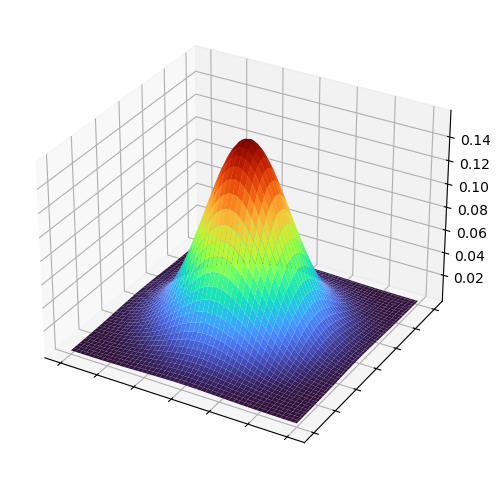

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set parameters for the Gaussian distribution
mean = [0, 0, 0]  # Mean of the distribution
cov = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]  # Covariance matrix

# Create a grid of points
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
x, y = np.meshgrid(x, y)

# Compute the Gaussian function
z = (1 / (2 * np.pi * np.sqrt(np.linalg.det(cov)))) * \
    np.exp(-0.5 * (x**2 + y**2))  # Simplified for independent x, y

# Create a 3D surface plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='turbo', edgecolor='none')
plt.yticks(color='w')
plt.xticks(color='w')
#plt.zticks(color='w')
# make the ticks invisible


# Set plot labels and title
#ax.set_xlabel('X-axis')
#ax.set_ylabel('Y-axis')
#ax.set_zlabel('Z-axis')

# Show the plot
plt.show()

In [21]:
vae.sampling(torch.tensor(mean), torch.tensor(cov))

tensor([[-1.5315, -1.5230,  0.7135],
        [ 0.7476,  1.8238,  0.6297],
        [ 0.2191,  0.3661, -1.1402]])